In [2]:
import warnings
warnings.filterwarnings("ignore")
#for handling RAM
import gc 

#stats
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import pingouin as pg


#my to go packages
import math
import random
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap


#for readin
import glob # Package for Unix-style pathname pattern expansion
import os   # Python operating system interface

#for signal processing
from scipy.interpolate import CubicSpline,interp1d
import scipy.signal as signal
import scipy.stats as stats
from scipy.signal import filtfilt, butter
from scipy.fft import rfft, rfftfreq
from scipy.stats import sem 
from scipy.stats import norm
from scipy.stats import ttest_rel

#other packages
import ast
import itertools
from itertools import groupby
from more_itertools import consecutive_groups
import more_itertools as mit
from operator import itemgetter
import statistics
from sklearn.mixture import GaussianMixture



# functions

In [3]:
#helper functions for speed array
def find_abs_speed_noSmooth(timepoint,ps): #find the raw speed array without applying any smoothing

    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        ps = ps.values
        timepoint = timepoint.values
    except AttributeError:
        pass

    prev = abs((ps[1:-1] - ps[0:-2])/(timepoint[1:-1] -timepoint[0:-2]))
    post = abs((ps[1:-1] -ps[2:])/ (timepoint[1:-1] -timepoint[2:]))
               
    ds[1:-1] = np.where(prev >= post,prev,post)
    ds[0] = abs((ps[1] - ps[0])/ (timepoint[1] - timepoint[0]))
    ds[-1] = abs((ps[-1] - ps[-2])/ (timepoint[-1] - timepoint[-2]))
    
    return ds
def find_abs_speed_pup(ps): #this is same as find_abs_speed, but now using a smoothed speed array for pupil
    #by using 5 points to calculate speed instead of 2
    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        nminus1 = ps.iloc[1:-3].values
        nplus1 = ps.iloc[3:-1].values
        nminus2 = ps.iloc[0:-4].values
        nplus2 = ps.iloc[4:].values

        ds[0] = abs(ps.iloc[1] - ps.iloc[0])
        ds[1] = abs(ps.iloc[2] - ps.iloc[1])
        ds[-1] = abs(ps.iloc[-1] - ps.iloc[-2])
        ds[-2] = abs(ps.iloc[-2] - ps.iloc[-3])
    except AttributeError:
        nminus1 = ps[1:-3]
        nplus1 = ps[3:-1]
        nminus2 = ps[0:-4]
        nplus2 = ps[4:]

        ds[0] = abs(ps[1] - ps[0])
        ds[1] = abs(ps[2] - ps[1])
        ds[-1] = abs(ps[-1] - ps[-2])
        ds[-2] = abs(ps[-2] - ps[-3])
               
    ds[2:-2] = abs((nplus1 + nplus2- nminus1 - nminus2  )/6)
    
    
    return ds
def find_abs_speed_sacc(vec):#this is same as find_abs_speed, but now using a smoothed speed array,for saccade 
    # because we're using.iloc and .values, need to make sure the 
    # vec input is from dataframe
    try:
        nminus1 = vec.iloc[1:-3].values
        nplus1 = vec.iloc[3:-1].values
        nminus2 = vec.iloc[0:-4].values
        nplus2 = vec.iloc[4:].values
    except AttributeError:
        nminus1 = vec[1:-3]
        nplus1 = vec[3:-1]
        nminus2 = vec[0:-4]
        nplus2 = vec[4:]
    #calculate derivative
    d = (nplus1 + nplus2- nminus1 - nminus2  )/6

    return d

In [4]:
#other helper functions
def consecutive(data, stepsize=10,
                findSame = False): # helper function for findGazeShift, deBlink, and more
    """
    @ data = row vector
    @ stepsize =  the larger the step size, the more difference it allows for two groups
                to be considered within the same cluster
    @ findSame = if True, find concecutive data point of the same value, this is set true
                 for finding blink counts using the blink mask (a df of 0 and 1 )
    """
    # this will split an array of numbers into many subarrays of consecutive numbers
    # the stepsize controls for how close of the two numbers for them to be considered
    # in the same cluster; e.g. [1,2,3,4,5,10] would be clustered together if stepsize = 5

    #data is the array of timepoint where the saccade velocity array crossed the threshold
    if findSame:
        stepsize = 0
        return np.split(data, np.where(abs(np.diff(data)) > stepsize)[0]+1)
    return np.split(data, np.where(np.diff(data) > stepsize)[0]+1)
def smooth(x,window_len=11,window='hanning'): #smoothing function
    try:
        x = x.values
    except:
        pass
    # about np windows:
    # https://numpy.org/doc/stable/reference/routines.window.html
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    #this is to prepare the input for convolve i.e. add 1/2 window length padding before and after
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]] 
    
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    #sliding window
    y=np.convolve(w/w.sum(),s,mode='valid')
    
    #get rid of the paddings
    return y[int(window_len/2):int(-0.5*window_len)] #select the data points to get rid of the delay
def strictly_increasing(L):#check if an array is uniformly increasing
    return all(x<y for x, y in zip(L, L[1:]))
def fs(width,height):#setting plot size
    plt.rcParams['figure.figsize'] = (width,height)


In [5]:
#function used for blink identification
def mad_func(ds,mad_threshold): #calculate the median absolute diviation (MAD)
    
    """
    function that calculate the median absolute diviation (MAD)
    ---------------------------------------------
    input: 
    ds: median absolute dilation speed, which is calculated in dilation_speed_filter
    mad_threshold: the threshold of median deviation (MAD); any data that is above median dilation speed + threshold*(MAD) will be rejected
    ---------------------------------------------
    output:
    returns a float and a boolean, first is the threshold, second is the bool array
    """
    try:
        ds = np.where(np.isnan(ds),0,ds)
    except:
        ds = np.where(ds.isnull(),0,ds)
    mad = np.nanmedian(abs(ds - np.nanmedian(ds))) # median absolute deviation
    rej_threshold = np.median(ds) + mad_threshold * mad # reject data above this threshold
       
    #returning an bool array, true = rejected, false = keep
    return (abs(ds) >= rej_threshold)  , rej_threshold
def reject_outlier(pt,rejarr, minGapLen = 0.03, borderlen = 0.05, borderlenBefore = 0,
                   freq = 1000): # 
    """
  
    ---------------------------------------------
    input:
    pt: pupil timestamps from pup_raw
    rejarr: pupil diameter with nans, assigning nan to the pupil array using the output of dilation_speed_filter()
    ---------------------------------------------
    output: return a dictionary, each key is the starting time of the nan value, each value is the end time of nan
    
    """
    borderN = borderlen* freq #number of adjacent data points that needs to be rejected
    borderNbefore = borderlenBefore * freq
    gapMinN = minGapLen * freq #number of data points in the gap
    
    b = np.where(rejarr==True, np.nan,rejarr)
    idx0 = np.flatnonzero(np.r_[True, np.diff(np.isnan(b))!=0,True])
    count = np.diff(idx0)
    idx = idx0[:-1]
    valid_mask =  np.isnan(b[idx])
    out_idx = idx[valid_mask]
    out_count = count[valid_mask]
    m = out_idx + out_count-1
    out = list(zip(out_idx, m))

    if len(out) == 0:
        return out

    #if the number of consecutively rejected data satisfies as a gap, record it
    outbool = np.array([(out[i][-1] - out[i][0])> gapMinN for i in range(len(out))])
    conRejarr = np.array(out)[outbool]
    gapCorrarr = [[]]*len(conRejarr)
    
    for i in range(len(conRejarr)):
        conRejarr[i][0] = max(0,conRejarr[i][0]-borderNbefore)
        #print(conRejarr[i][-1],conRejarr[i][-1]+borderN)
        conRejarr[i][-1] = min(len(pt)-1,conRejarr[i][-1]+borderN)
        gapCorrarr[i] = np.arange(conRejarr[i][0],conRejarr[i][-1]+1)
   
    return np.array(gapCorrarr)
def blkLen(rowInput,blkLen):#counts how many blink has occured using the mask df
    #blink len default = how many consecutive points for one event to be registered as blink
    #count this as 1 blink event
    boolMask = [list(g)[0]>0 for k, g in groupby(rowInput) ]
    repeatingVal = np.array([list(g) for k, g in groupby(rowInput)])
    
    blkArr = repeatingVal[boolMask]
    blkCnt = sum([len(i) > blkLen for i in blkArr])
    return blkCnt
def medianVariance(vec):#vec is the result from find_abs_speed_pup/sacc
    try:
        val = np.nanmedian(abs(vec - np.nanmedian(vec)))
    except:
        print('F**k! medianVariance function encountered an error:')
        print('dtype of vec:' + str(type(vec)))
        print('np.nanmedian(vec) :' + str(np.nanmedian(vec)))
    return val

In [6]:
#older functions
def interpolate_blink(paddedRejIndex,paddedRejBool, timestamp,pupilsize,
                      maxGapLen = 0.5,freq = 200):#paddedRejIndex = output from reject_outlier; ..Bool is the pseudodf['paddedDsRej']
    # check for the length for each gap, if it's longer than the maximum length defined for a gap
    # then don't interpolate, just leave it blank
    interpolateIndex = paddedRejIndex[[len(i)<maxGapLen*freq for i in paddedRejIndex]]
    """ i found that it works better to not smooth the pupil size
     """
    pupilsize = np.array(smooth(pupilsize))
   
    #for each blink, select the onset/offset pupil size, as well as two equal distant time point,call it ref list
    refList = np.array([np.array([max(0,i[0] - len(i)),i[0],i[-1],min(len(timestamp)-1,i[-1] + len(i))]) for i in interpolateIndex])
    
    #use the refList to retrieve the paddedRejIndex, if more than 2 values are True, i.e. the first and last reference points
    #are also rejected data, then use the linear interpolation, else if the first and last ref points can be retrieved,
    #use cubic spline interpolation
    linearList = refList[np.sum(paddedRejBool.values[refList],axis = 1) > 2]
    cubicList = refList[np.sum(paddedRejBool.values[refList],axis = 1)== 2]
    
    #use the linearlist or cubic list, find the timestamp or pupilsize values used for interpolation
    cubictss = timestamp.values[cubicList]
    cubicarr = pupilsize[cubicList]#pupilsize.values[cubicList]
    
    lineartss = timestamp.values[linearList]
    lineararr = pupilsize[linearList]#pupilsize.values[linearList]
    
    #calculate the interpolated values; Index is the array of timestamp arrays, FuncList is the interpolated value
    cubicIndex = [np.array(timestamp.iloc[cubicList[i][1]:cubicList[i][2]]) for i in range(len(cubicList))]
    csFuncList = [CubicSpline(cubictss[i],cubicarr[i])(cubicIndex[i]) for i in range(len(cubicList))]

    linearIndex = [np.array(timestamp.iloc[linearList[i][1]:linearList[i][2]]) for i in range(len(linearList))]
    lFuncList = [interp1d(lineartss[i],lineararr[i])(linearIndex[i]) for i in range(len(linearList))]
   
    return cubicIndex,csFuncList,linearIndex,lFuncList
def dsclean(thisdf,arr):
    """
    this is the main function for reject, clean, and interpolate
    thisdf is the df of the specific subject
    #1st it, arr = 'diameter_3d', 2+ it, arr = 'diameter_3dNew'
    
    note: outside the function, these four variables needs to be specified, e.g.
    maxGapLen = 1; minGapLen = 0.0 ; freq = 1000; gapMinN = minGapLen*freq; gapMaxN = maxGapLen*freq
    
    
    """
    #1st ite
    arr = thisdf[arr] #1st it, arr = diameter_3d, 2+ it, arr = diameter_3dNew
    rejarr,rejThreshold = mad_func(find_abs_speed(thisdf.pupil_timestamp,arr),3.5)    #need to get rid of zeros
    thisdf['dsRej'] = (rejarr == True) | (arr.isnull()) | (arr == 0)

    paddedDsRej = reject_outlier(thisdf.pupil_timestamp,thisdf.dsRej,minGapLen = minGapLen,borderlen=0.025,freq= 1000)
    thisdf['paddedDsRej'] = np.where(thisdf.index.isin(np.concatenate(paddedDsRej)),True,False)

    gapCorrarr = np.where(thisdf.paddedDsRej)[0]
    #the sum of sublist in gapCorrarrparsed is the same length as the gapCorrarr
    gapCorrarrParsed = [np.array(list(group)) for group in mit.consecutive_groups(gapCorrarr)] 

    #if the gap is shorter than minimum length, don't count it as a gap (but i've set min gap len to 0)
    outbool = np.array([(gapCorrarrParsed[i][-1] - gapCorrarrParsed[i][0])> gapMinN for i in range(len(gapCorrarrParsed))])
    gapCorrarrParsed = np.array(gapCorrarrParsed)[outbool]
    #correct the paddedDsRej, excluding shorter-than-gap values, i.e. set those to false
    thisdf['paddedDsRejNoGap'] = np.where(thisdf.index.isin(np.concatenate(gapCorrarrParsed)),True,False)

    #also don't interpolate for gap length longer than maximum gap len
    #first iteration use diameter 3d
    csts,csi,lts,li = interpolate_blink(paddedRejIndex = gapCorrarrParsed,
                                        paddedRejBool = thisdf['paddedDsRejNoGap'],
                                        timestamp = thisdf.pupil_timestamp,
                                        pupilsize = arr,
                                        freq = 1000) #this pupilsize is different for iteretions

    #for this 1st iteration, make a copy of diameter 3d to add the interpolated data
    thisdf['diameterThisIter'] = arr #this pupilsize is different for iteretions
    try:
        thisdf.loc[np.where(thisdf['pupil_timestamp'].isin(np.concatenate(csts)))[0],'diameterThisIter'] = np.concatenate(csi)
        thisdf.loc[np.where(thisdf['pupil_timestamp'].isin(np.concatenate(lts)))[0],'diameterThisIter'] = np.concatenate(li)
    except ValueError: 
        print('no array to concat')
    """
    minPup = np.mean(thisdf['diameterThisIter']) - 3*np.std(thisdf['diameterThisIter'])
    maxPup = np.mean(thisdf['diameterThisIter']) + 3*np.std(thisdf['diameterThisIter'])

    #also reject periods of pupil size that's larger the 3 sd away from the median, callit diameter_3dNew
    thisdf['diameter_3dNew'] = np.where(((thisdf['diameterThisIter']<minPup)|(thisdf['diameterThisIter']>maxPup)),0, thisdf['diameterThisIter'] )
    """
    return thisdf
def tlclean(thisdf,windown = 501,mad = 10,
            psCol = 'diameterThisIter',tsCol = 'pupil_timestamp',psColNew = 'diameter_3dNew'):
    
    #make trendline by interpolating and smoothing
    cs = CubicSpline(thisdf[tsCol][~thisdf[psCol].isnull()].values,
                   thisdf[psCol][~thisdf[psCol].isnull()].values)
    interp = cs(thisdf[tsCol])
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(thisdf[psCol] -smoothed,mad)[0]
    thisdf['dsRej'] = (tlmad == True) | (thisdf[psCol].isnull() == True) | (thisdf[psCol] == 0)

    #don't pad the tl deviations
    arr = thisdf[psCol]
    gapCorrarr = (np.where(thisdf.dsRej)[0]) 
    #the sum of sublist in gapCorrarrparsed is the same length as the gapCorrarr
    gapCorrarrParsed = np.array([np.array(list(group)) for group in mit.consecutive_groups(gapCorrarr)]) 

    #preparation for interpolation
    interpolateIndex = gapCorrarrParsed[[len(i)<maxGapLen*freq for i in gapCorrarrParsed]]
    refList = np.array([np.array([max(0,i[0] - len(i)),i[0],i[-1],min(len(thisdf[tsCol])-1,i[-1] + len(i))]) for i in interpolateIndex])
    increasingList = np.array([strictly_increasing(i) for i in refList])

    linearList = refList[(np.sum(thisdf['dsRej'].values[refList],axis = 1) > 2) | (increasingList== False) ]
    cubicList = refList[(np.sum(thisdf['dsRej'].values[refList],axis = 1)== 2) & (increasingList)]

    #use the linearlist or cubic list, find the thisdf[tsCol] or arr values used for interpolation
    cubictss = thisdf[tsCol].values[cubicList]
    cubicarr = arr.values[cubicList]
    #correct for nan
    cubicList = cubicList[np.isnan(cubicarr).sum(axis = 1) !=1]##
    cubictss = cubictss[np.isnan(cubicarr).sum(axis = 1) !=1]##
    cubicarr = cubicarr[np.isnan(cubicarr).sum(axis = 1) !=1] ##

    #for linear
    lineartss = thisdf[tsCol].values[linearList]
    lineararr = arr.values[linearList]
    #correct for nan
    linearList = linearList[np.isnan(lineararr).sum(axis = 1) !=1]##
    lineartss = lineartss[np.isnan(lineararr).sum(axis = 1) !=1]##
    linearr = lineararr[np.isnan(lineararr).sum(axis = 1) !=1] ##


    #calculate the interpolated values; Index is the array of thisdf[tsCol] arrays, FuncList is the interpolated value
    cubicIndex = [np.array(thisdf[tsCol].iloc[cubicList[i][1]:cubicList[i][2]]) for i in range(len(cubicList))]
    csFuncList = [CubicSpline(cubictss[i],cubicarr[i])(cubicIndex[i]) for i in range(len(cubicList))]

    linearIndex = [np.array(thisdf[tsCol].iloc[linearList[i][1]:linearList[i][2]]) for i in range(len(linearList))]
    lFuncList = [interp1d(lineartss[i],lineararr[i])(linearIndex[i]) for i in range(len(linearList))]

    #for this 1st iteration, make a copy of diameter 3d to add the interpolated data
    thisdf[psColNew] = arr #copy the old ps column, then modify it using the interpolated values
    thisdf.loc[np.where(thisdf[tsCol].isin(np.concatenate(cubicIndex)))[0],psColNew] = np.concatenate(csFuncList)
    thisdf.loc[np.where(thisdf[tsCol].isin(np.concatenate(linearIndex)))[0],psColNew] = np.concatenate(lFuncList)
    
    return thisdf
def tl(thisdf,windown = 501,mad = 10,
       psCol = 'diameterThisIter',tsCol = 'pupil_timestamp',psColNew = 'diameter_3dNew'):
    #make trendline by interpolating and smoothing
    cs = CubicSpline(thisdf[tsCol][~thisdf[psCol].isnull()].values,
                   thisdf[psCol][~thisdf[psCol].isnull()].values)
    interp = cs(thisdf[tsCol])
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(thisdf[psCol] -smoothed,mad)[0]
    return tlmad
def tlFinal(x,y,windown = 101,mad = 10):
    #this is for doing trialwise tl rejection, not very necessay but since the input format
    #is slightly different from the tl function, i'm including it as a sepearte one
    cs = CubicSpline(x[~np.isnan(y)],
                    y[~np.isnan(y)])
    interp = cs(x)
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(y-smoothed,mad)[0]
    return tlmad

In [7]:
#core functions
def deBlink(rawPup,timestamp,
            returnMask = False,
            maxGapt = 2,
            minGapt= 0.003,
            freq = 1000,
            borderlenBef=0.001,
            borderlenAft=0.01,
            clusterLapse = 0.15,
            plotSteps = False,
            madThreshold = 3.5,
            minPupAllowed = 2000
            ):
    """
    #this function clean the pupil array, and generate a boolean blink mask array
    @ rawPup = each row in the epoched pupil table
    @ timestamp = 
    @ returnMask: if true, return the boolean mask only (this is necessday because df.apply can't return two dfs)
    @ minGapt = 
    @ freq = 
    @ borderlenBef = paddings to add after each blink
    @ borderlenAft = paddings to add before each blink
    @ clusterLapse = larger value will count more distant blinks as one, resulting in more data rejected
    @ plotSteps = if True, generate a plot for the cleaning step
    @ madThreshold = speed threshold for rejection
    @ minPupAllowed = the min pupil size allowed for it to not be classified as err
    """
    #find the raw rej arr; This use a smoothed pupil change speed array to find the threshold
    #crossings
    rejarr = mad_func(find_abs_speed_pup(rawPup),madThreshold)[0] | (rawPup < minPupAllowed)

    #initialize two mask array, these will store the processed blink mask
    rejarr_padded = np.zeros(len(rejarr))
    rejarr_blkMask = np.zeros(len(rejarr))

    #pad the mask
    try:
        np.put(rejarr_padded, np.concatenate(reject_outlier(timestamp, rejarr, minGapLen= minGapt,freq = freq,
                                                             borderlenBefore=borderlenBef,
                                                    borderlen=borderlenAft)), 1, mode='clip')
    except ValueError:
        rejarr_padded = rejarr

    #identify clusters in the mask (if two blink are too close, count them as one cluster and mask off the lapse between)
    #put the resulting mask into rejarr_blkMask, this will be returned as output
    try:
        consecutiveBlkFilter = np.array([np.arange(i[0], i[-1]+1) for i in consecutive(np.where(rejarr_padded)[0], 
                                                                                       stepsize= clusterLapse*freq)])
        np.put(rejarr_blkMask, np.concatenate(consecutiveBlkFilter), 1, mode='clip')
    except ValueError:
        rejarr_blkMask = rejarr_padded
    except IndexError: 
        return rawPup
        
    blkMask = rejarr_blkMask.copy()

    #just return the mask if necessary
    if returnMask:
        return blkMask

    """clean"""
    #use this mask to clean the pupil, mask off the data in blink
    #creating a copy for the plot because we will change the value of maskedPup 
    maskedPup_plt = np.where(rejarr_blkMask, np.nan, rawPup) 
    maskedPup = maskedPup_plt.copy() 

    """interpolation"""
    # reshape the clusted blink mask into arrays of clusted index, if its lenth if larger than the 
    # maximum gap lenth * frequency, then don't interpolate for this cluster, just leave it blank
    rejCluster = consecutive(np.where(rejarr_blkMask)[0], 1)
    rejCluster = np.array([k for k in rejCluster if len(k) < maxGapt*freq])

    #find four index for interpolation
    indexForInterp = np.array([np.array([max(0, i[0] - len(i)),
                                        max(0, i[0]-1),
                                        min(i[-1]+1, len(timestamp)-1),
                                        min(len(timestamp)-1, i[-1] + len(i))]) for i in rejCluster])
    
    #when applying this function to a df, sometime it required the input to be in specific format
    try:
        timestamp = timestamp.values
        rawPup = rawPup.values
    except AttributeError:
        timestamp = np.array(timestamp)
        rawPup = np.array(rawPup)
    
    #run the following if there there are available blink clusters for interpolation, interpolate
    try:
        #get the timestamp and pupil size (masked) for creating the interpolation function
        tsForInterp = timestamp[indexForInterp]
        cleanPupForInterp = maskedPup[indexForInterp]
        
        #get the timestemp for exptrapolate the missing pupil size
        tsForExtrap = [timestamp[i] for i in rejCluster]
        
        #for each available blink cluster,try use the cubic spline interpolation of 4 points
        #but if any point if nan, then use linear; but if it still can't (e.g. only one data point availble)
        #then don't interpolate, leave it as nan
        for i in range(len(rejCluster)):
            try:
                pupExtrapolated = CubicSpline(tsForInterp[i], cleanPupForInterp[i])(tsForExtrap[i].astype(float))
            except ValueError:
                try:  # if cant find reference points, use linear interpolation
                    pupExtrapolated = interp1d(tsForInterp[i][1:3], cleanPupForInterp[i][1:3])(tsForExtrap[i].astype(float))
                # if still gives error, then dont interpolate (usually the case with trial start/end)
                except ValueError:
                    pupExtrapolated = np.nan
            #fill each blink cluster with interpolated pupil value
            maskedPup[rejCluster[i]] = pupExtrapolated
    except IndexError:
        pass

    if plotSteps:
        fig, ax = plt.subplots(nrows=5)
        #plot speed and threshold of rejection
        sns.scatterplot(x= timestamp, y= find_abs_speed_pup(rawPup), ax=ax[0])
        ax[0].hlines(mad_func(find_abs_speed_pup(rawPup), 3.5)[1],
                    xmin=timestamp[0], xmax=timestamp[-100], colors='r')
        #plot the unfilted mask
        sns.scatterplot(x=timestamp, y=rawPup, hue=rejarr, ax=ax[1])
        #plot the filtered mask
        sns.scatterplot(x=timestamp, y=rawPup, hue=rejarr_blkMask, ax=ax[2])
        #plot the pupil data after it's been masked
        sns.scatterplot(x=timestamp, y=maskedPup_plt, ax=ax[3])
        #plot the interpolated pupil size
        sns.scatterplot(x=timestamp, y=maskedPup, ax=ax[4])
        
        ax[1].sharex(ax[0])
        ax[2].sharex(ax[0])
        ax[3].sharex(ax[0])
        ax[4].sharex(ax[0])

    
    return maskedPup
def findGazeShift(xvec,threshold = 6, countTogether = 50, 
                   baseline = None, winlen = 50,shiftmin = 2.14,
                   baselinePadding = 0):
    """
    @ xvec =  the gaze position (it should be each row in the saccRetro_X df)
    @ threshold = the velocity filter threshold
    @ countTogether = the maximum delay for two gaze shift cluster to be count as one
    @ baseline = if none, calculate relative baseline  (i.e. in regard to position before and after shift)
                else it should be a list of index to indicate baseline rage, e.g. [500,1000]
    @ winlen = for the onset of each identified gazeshift cluster, get the [-winlen,0] and [winlen, 2+ winlen]
            to calculate the mean gaze position before and after the shift occur
    @ shiftmin = the minimum shift in gaze position for it to be considered as a real shift
            default = 2.14 pixel = 0.057 visual degree
    @ baselinePadding = the padding to add before the identified gaze shift, this is only meaningful if baseline
                        is None (i.e. the shift regarding to gaze position before and after)
    
    """
    # get speed vector
    # since we are using 4 time points to calculate the speed array (see find abs speed sacc function)
    # the len of dx, dy is 4 points less than the length of xvec. 
    dx = find_abs_speed_sacc(xvec)
    #get threshold, then get a boolean array, for finding threshold crossing clusters
    thresholdx = [np.nanmedian(dx) + medianVariance(dx) *threshold,np.nanmedian(dx) - medianVariance(dx) *threshold]
    cx = (dx>thresholdx[0]) | (dx < thresholdx[1])
    cx = np.r_[False,False,cx,False,False] #correct for the four lost points


    # Deselect period at the beginning and the end of the position array i.e.掐头去尾
    # and re-identify the saccade cluster after applying both masks
    # if two clusteres are close enough (50ms), then count them as one
    onsetoffsetmask = np.r_[np.zeros(winlen + baselinePadding),np.ones(len(cx) - 3*winlen - 2* baselinePadding),np.zeros(2*winlen + baselinePadding)].astype(bool) #to deselect data in the first and last 50ms 
    maskedcx = np.where(cx & onsetoffsetmask)[0] 
    msCluster = consecutive(maskedcx,countTogether)

    # initialize the output array with zeros, calculate the mean pos before and after the shift
    gazeshift = np.zeros(len(xvec))    

    try:
        for i in msCluster:
            #if user doesn't provide a baseline value, use relative baseline
            if baseline == None:
                befIndex = [i[0] - winlen - baselinePadding,i[0]- baselinePadding]
            else:
                befIndex = baseline
            try:
                posbef = np.nanmean(xvec.iloc[befIndex[0] : befIndex[1]])
                posaft = np.nanmean(xvec.iloc[i[0] + winlen + baselinePadding : i[0] + 2*winlen + baselinePadding]) 

            except AttributeError: # this is to account for when using df.apply(raw = True),xvec is an array, not series
                posbef = np.nanmean(xvec[befIndex[0] : befIndex[1]])
                posaft = np.nanmean(xvec[i[0] + winlen + baselinePadding: i[0] + 2*winlen + baselinePadding]) 

            if abs(posaft - posbef) > shiftmin: 
                #toss away a ms if its less than a minimum visual degree 
                gazeshift[i[0]] = posaft - posbef 
            else:
                pass
    except IndexError: #i.e. if msCluster is empty, it gives error when trying to index i[0], in this case just return the 0 array
        return gazeshift
    return gazeshift

In [8]:

#this is originally used to linearly interpolate 
#missing saccade data
def linearInterpolate(x,y,method = 'linear'):
    """
    methods needs to be one of the scipy.interpolate.interp1d methods
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
    """
    #if the entire trial is nan, return nan
    if np.isnan(np.array(y)).sum() == len(y):
        interp = np.empty(len(y))
        interp[:] = np.nan
        return interp
    #else,interpolate
    try:
        li = interp1d(x[~y.isnull()],
                        y[~y.isnull()],
                        fill_value="extrapolate",kind = method)
        interp = li(x)
    except AttributeError: #handling np.array and pandas df conversion
        li = interp1d(x[~np.isnan(y)],
                        y[~np.isnan(y)],fill_value="extrapolate",kind = method)
        
    interp = li(x)
    return interp

In [9]:
#plotting function
def legend_without_duplicate_labels(ax,locVal = 'best'):
    #https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),loc = locVal)
def deBlinkSample(rawPup, samplesize = 10): #plot n trial samples with the deblink process
    fs(12,12)
    select = np.random.randint(0,len(rawPup),size = samplesize)

    #select some smaple 
    sample_raw = rawPup.iloc[select,1:]

    #Clean once
    cleanOnceSample = sample_raw.apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                                clusterLapse = 0.05, borderlenAft = 0.2,
                                                borderlenBef= 0.05,madThreshold = 4),axis = 1,raw = True)

    #second clean
    onceSmoothSample = cleanOnceSample.rolling(11,min_periods=1,center  = True,axis =1).mean()
    cleanTwiceSample = onceSmoothSample.apply(lambda x: deBlink(rawPup = x,timestamp = np.linspace(0,5,len(x)),
                                            borderlenBef = 0.05,borderlenAft = 0.05,minGapt = 0.002,
                                            clusterLapse = 0.05,madThreshold = 6),axis =1,raw = True)
    fig,ax = plt.subplots(nrows = 3)

    x = np.linspace(0,5,5000)
    [ax[0].plot(x,sample_raw.iloc[i,:],alpha = 0.8) for i in range(len(select))]
    [ax[1].plot(x,cleanOnceSample.iloc[i,:],alpha = 0.84,linewidth = 2) for i in range(len(select))]
    [ax[2].plot(x,cleanTwiceSample.iloc[i,:],alpha = 0.8,linewidth = 2) for i in range(len(select))]

    ax[1].set_ylim(ax[2].get_ylim())
    ax[0].set_ylim(ax[2].get_ylim())

    plt.show()
def pupilPlot(normPup,blPup, 
              eventt = 3,
              blt  = 0.1,
              freq = 1000,
              type = 'grand',
              levels = ['cue_blk_validity','cued_item'],
              pltRatio = [0.2,3], pltN = 3,
              eventBoundary = [0,0.5,2.5],
              eventName = ['retrocue','delay','probe'],
              blHeight = None,
              mainFigHeight = None,
              cList = [],
              figH = 5.5, figW = 16,
              tightPlot = True,
              textSize = 12,
              sigPeriod = None,
              sigAx = 0,
              sigBarHeight = 30,
              textOffset = 10,
              tickSize = 10
              ):
    """
    @ normPup = normalized pupil df with trial info columns in the end
    @ blPup = the pupil df with the baseline
    @ eventt = the time for the event of interest
    @ blLen = the time for the baseline
    @ freq = sampling frequency, defalut 1000
    @ type = the type of plot, 
           - grand avg: ;
           - subj avg: ;
    @ levels = the group by levels, e.g. block validity and cued item
    @ pltRatio = ratio for the plot for baseline and event
    @ pltN = how many plots, default 3
    @ eventBoundary = use to plot vertical lines on the plot to represent certain events
    @ eventName = the text label for these events
    @ blHeight = ylim for the baseline plots, if None, set ylim using max and min
    @ mainFigHeight = ylim for the main plots, if None, set ylim using max and min
    @ cList = the color list used for plots; default color- the ones i carefully preseletced, very pretty
    @ figH = figure height for each plot, default 5.5
    @ figW = figure width, default 16
    @ tightPlot = if true, set the plot layout to be tighter
    @ textSize = the text label on the plot size
    @ sigPeriod = 2 item list [start, end]
    @ sigAx = axes to draw the sigbar
    @ sigBarHeight = height of the significant bar, the larger the thicker
    @ textOffset = the height of text offset, the larger , the lower the text
    @ tickSize = size for ticks
    --------------
    return NormMean: the groupby df
    """
    eventLen = int(eventt*freq)
    blLen = int(blt*freq)

    if not type in ['grand','subj']:
        raise 'Your plot should either be grand avg or subj avg'
    if len(eventBoundary) != len(eventName):
        raise 'your event name array should be the same size as your event boundary(time) array'
    if type == 'grand':
        normmean = normPup.groupby(levels).mean().iloc[:,:eventLen]
        norm_sterr = normPup.groupby(levels).sem().iloc[:,:eventLen]
        norm_upper = normmean.iloc[:,:] +norm_sterr.iloc[:,:] 
        norm_lower = normmean.iloc[:,:] -norm_sterr.iloc[:,:] 

        normmeanBL = blPup.groupby(levels).mean().iloc[:,:blLen]
        norm_sterrBL = blPup.groupby(levels).sem().iloc[:,:blLen]
        norm_upperBL = normmeanBL.iloc[:,:] +norm_sterrBL.iloc[:,:] 
        norm_lowerBL = normmeanBL.iloc[:,:] -norm_sterrBL.iloc[:,:]

        #the mean df will be returned
        returnMean = normmean    
        returnSd = norm_sterr
    elif type == 'subj':
        subj_levels = levels + ['subj']
        normmean = normPup.groupby(subj_levels).mean().iloc[:,:eventLen].groupby(levels).mean()
        norm_sterr = normPup.groupby(subj_levels).mean().iloc[:,:eventLen].groupby(levels).sem()
        norm_upper = normmean.iloc[:,:] +norm_sterr.iloc[:,:] 
        norm_lower = normmean.iloc[:,:] -norm_sterr.iloc[:,:] 
        
        normmeanBL = blPup.groupby(subj_levels).mean().iloc[:,:blLen].groupby(levels).mean()
        norm_sterrBL = blPup.groupby(subj_levels).mean().iloc[:,:blLen].groupby(levels).sem()
        norm_upperBL = normmeanBL.iloc[:,:] +norm_sterrBL.iloc[:,:] 
        norm_lowerBL = normmeanBL.iloc[:,:] -norm_sterrBL.iloc[:,:]

        #the subj df will be returned
        returnMean = normPup.groupby(subj_levels).mean().iloc[:,:eventLen]
        returnSd =  normPup.groupby(subj_levels).sem().iloc[:,:eventLen]

    condN = normmean.shape[0]
    #if color list is not right length, use sns generated color
    if len(cList) < condN:
        print('input color list is too short, plot default color ')
        cList = sns.color_palette("flare",n_colors = condN)
     
    #setting up plotting params
    fs(figW,pltN*figH) #set figure size
    fig,ax = plt.subplots(nrows= pltN, ncols=2, sharex=False, sharey = False,
                          gridspec_kw={'width_ratios': pltRatio,})
    x = np.linspace(0,eventt,norm_sterr.shape[1])
    xBL = np.linspace(0,blt,norm_sterrBL.shape[1])

    #height parameters
    if blHeight == None:
        blHeight = [norm_lowerBL.min().min(), norm_upperBL.max().max()]
    if mainFigHeight == None:
        minH = norm_lower.min().min()
        maxH = norm_upper.max().max()
    
    #set height
    [ax[i][0].set_ylim(blHeight) for i in range(pltN)]
    if mainFigHeight != None:

        [ax[i][1].set_ylim(mainFigHeight) for i in range(pltN)]
        minH = mainFigHeight[0]
        maxH = mainFigHeight[1]

    #plot mean plot for the baseline and for the trial
    [ax[i//2][0].fill_between(xBL,norm_upperBL.iloc[i,0:norm_sterrBL.shape[1]],norm_lowerBL.iloc[i,0:norm_sterrBL.shape[1]],
                        color = cList[i],alpha = 0.2,)  for i in range(condN)]
    [ax[i//2][0].plot(xBL,normmeanBL.iloc[i,0:norm_sterrBL.shape[1]],
                      linewidth = 2.5,color = cList[i],) for i in range(condN) ]

    [ax[i//2][1].fill_between(x,norm_upper.iloc[i,0:norm_sterr.shape[1]],norm_lower.iloc[i,0:norm_sterr.shape[1]],
                        color = cList[i],alpha = 0.1, )  for i in range(condN)]
    [ax[i//2][1].plot(x,normmean.iloc[i,0:norm_sterr.shape[1]],
                      color = cList[i],linewidth = 3,) for i in range(condN) ]
    
    if sigPeriod != None:
        ax[sigAx][1].hlines(0,x[sigPeriod[0]],x[sigPeriod[1]],colors = cList[0],
           linewidth = sigBarHeight)
    
    #add vertical line and text
    for ff in range(pltN):
        ax[ff][1].vlines(eventBoundary,minH, maxH, linestyles = 'dashed',colors= 'black')
    for i,m in zip(eventBoundary,eventName):
        ax[0][1].text(i,maxH - textOffset,m,c = 'black',size = textSize)
    [ax[i][j].tick_params( labelsize=tickSize) for i in range(pltN) for j in range(2)]   

    [ax[i][1].yaxis.set_major_locator(ticker.MultipleLocator(50)) for i in range(3)]

    #make the plots tighter
    if tightPlot:
        plt.subplots_adjust(hspace = 0.1)
        plt.subplots_adjust(wspace = 0.06)
    
    #plt.xticks(fontsize= figW, )
    plt.show()

    return returnMean,returnSd

In [10]:

# for behavioral response from psychopy

def find_click_time(click,time):
    try:
        rt = time[np.nonzero(click)[0][0]]
    except IndexError:
        rt = np.nan
    return rt

# load params

In [11]:
pd.set_option('display.max_columns', 500)


In [12]:
#read in the mega df
local_username = 'yud070'
pathEL = 'Z:/LiteBrite_YueyingDong/22AK01ELRaw_tracker/'
pathpy = 'Z:/LiteBrite_YueyingDong/22AK01ELRaw_psychopy/'

readIn = [f for f in os.listdir(pathEL)]

In [13]:
relevantCols = ['RECORDING_SESSION_LABEL','AVERAGE_GAZE_X',
       'AVERAGE_GAZE_Y','AVERAGE_PUPIL_SIZE','EYE_TRACKED','IP_LABEL','IP_START_TIME',
      'LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','SAMPLE_MESSAGE','TIMESTAMP','TRIALID']
pupCols = ['EYE_TRACKED','LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','AVERAGE_PUPIL_SIZE',
           'IP_LABEL','TIMESTAMP','TRIALID']

In [14]:
#plotting params // pending refractor
ts = [1000,1250,1750,2250,4250,4750] #stim onset, rest, retrocue, delay, probecue

fixation_ts = 0.5
stim_ts = 0.25 #+ fixation_ts
precue_ts = 0.5 + stim_ts
retrocue_ts = 0.5 + precue_ts
post_cue_ts = 2 + retrocue_ts
probe_cue = 0.5 + post_cue_ts
probe_ts = 3 + post_cue_ts
iti = 0.5 + probe_ts

epoch_array = np.array([0,stim_ts,precue_ts,retrocue_ts,post_cue_ts,probe_cue])#[,post_cue_ts,,probe_ts]
epoch_name = ['stim','rest','retrocue','rest','probe_cue','probe']


In [15]:
epoch_array

array([0.  , 0.25, 0.75, 1.25, 3.25, 3.75])

In [16]:
#some specified params
leftEyeSubj = ['173','175']
rightEyeSubj = ['183','185']

#events
events = ['fixateRest','stim','precueRest', 'retrocue',
                            'postcueRest','probecue', 'probe', 'ITI','trialEnd']
eventIndex = [0,1000,1250, 1750,2250,4250,4750,7750,8250]

In [17]:
#take the first 5s in each recording, though the interest period is [0.5,4.75], but the padding
#is included for better interpolating

#params for reading in
included = 5000

#params for cleaning
sdThreshold = 6
pltAll = True
interpCorrection = np.zeros(len(readIn))
maxGapLen = 0.5
minGapLen = 0.0
freq = 1000
gapMinN = minGapLen*freq

In [18]:
#for plotting
cList = ['#fda48c','#f23908','#93648f','#33202a','#66b3ba','#03838f',]
cDict = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#593247'} #{"['high']":'red',"['medium']":'green',"['low']":'blue'}


# readIn 

### readin Psychopy

In [ ]:
psyFull = pd.read_csv('Z:/LiteBrite_Yueying/22AK01ELRaw_psychopy/allsubj.csv').iloc[:,1:]

### readin Pupil

In [ ]:
pathUnparsed = 'Z:/LiteBrite_Yueying/temp/unparsed/'

pupFullTrial_raw = pd.concat((pd.read_csv(f).iloc[:,1:] for f in glob.glob(pathUnparsed + 'pupRaw'+'/*.csv')), ignore_index=True)


### readin events

In [ ]:
pathUnparsed = 'Z:/LiteBrite_Yueying/temp/unparsed/'

eventDf = pd.concat((pd.read_csv(f).iloc[:,1:] for f in glob.glob(pathUnparsed + 'event'+'/*.csv')), ignore_index=True)


### readin gaze

In [ ]:
saccFullTrial_x_raw = pd.concat((pd.read_csv(f).iloc[:,1:] for f in glob.glob(pathUnparsed + 'saccX'+'/*.csv')), ignore_index=True)
saccFullTrial_y_raw = pd.concat((pd.read_csv(f).iloc[:,1:] for f in glob.glob(pathUnparsed + 'saccY'+'/*.csv')), ignore_index=True)

# behavioral response

## get rt from psyfull

In [ ]:
#use the left click arrary and the time array to identify the time of mouse first click
psyFull['mouse_click'] = [ast.literal_eval(i) for i in psyFull['mouse.leftButton']]
psyFull['mouse_time'] = [ast.literal_eval(i) for i in psyFull['mouse.time']]
psyFull['rt'] = [find_click_time(i,n) for i,n in zip(psyFull['mouse_click'],psyFull['mouse_time'])]

#add a column of block validity condition
psyFull['blk_validity'] = [ast.literal_eval(i)[0] for i in psyFull.cue_blk_validity]
#add a column of blk+trial condition
psyFull['blk_trl_cond'] = psyFull.blk_validity+psyFull.cue_condition


missing_ts = psyFull[(psyFull['mouse_click'].apply(sum) ==0) ].reset_index(drop = True)

In [ ]:
#count how many trials are missing for each subj
missingRsp = missing_ts.participant.value_counts().reset_index(drop = False,name = 'missCnt')

## individual memory performance

### individual error

In [ ]:
#plot size params
indPlotSize = [3,3]

#column/row
ny = 5
nx = (len(readIn)//ny) +1
fs(indPlotSize[0] *ny,indPlotSize[1] *nx)

fig,ax = plt.subplots(nrows= nx, ncols = ny)
counter_x = 0
counter_y = 0

for i in readIn:
    i = float(i)
    sns.histplot(x = 'abs_distance_to_probed_item',hue = 'cue_condition',hue_order = ['valid','invalid'],
                                      data = psyFull[psyFull. participant == i],bins = 10,
                                      ax = ax[counter_x][counter_y])
    ax[counter_x][counter_y].set_xlim(0, 100)
    ax[counter_x][counter_y].set_ylim(0, 100)
    ax[counter_x][counter_y].set_title(str(i))
    
    counter_x+=1
    if counter_x == nx:
        counter_y+=1
        counter_x = 0

plt.show()

In [ ]:
#mean ind error
#plot size params

nx = (len(readIn)//ny) +1
fs(indPlotSize[0] *ny,indPlotSize[1] *nx)
x = np.linspace(0,5,5000)

fig,ax = plt.subplots(nrows= nx, ncols = ny,sharey = True)

counter_x = 0
counter_y = 0



for f in readIn:
    f = float(f)
    subjavg = psyFull[psyFull.participant == f].reset_index(drop = True)
    
    sns.barplot(x = 'cue_condition',
                 y = 'abs_distance_to_probed_item' ,
                order=['invalid','valid'],
                data = subjavg,ax = ax[counter_x][counter_y])

    ax[counter_x][counter_y].set_title(f)

    counter_x+=1
    if counter_x == nx:
        counter_y+=1
        counter_x = 0
plt.ylim([0,50])

In [ ]:
#break down the previous plots into block conditions

nx = (len(readIn)//ny) +1
fs(indPlotSize[0] *ny,indPlotSize[1] *nx)
x = np.linspace(0,5,5000)

fig,ax = plt.subplots(nrows= nx, ncols = ny,sharey = True)

counter_x = 0
counter_y = 0
cDict = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#593247'} 


for f in readIn:
    f = float(f)
    subjavg = psyFull[psyFull.participant == f].reset_index(drop = True)
    
    sns.barplot(x = 'cue_condition',hue ='blk_validity',
                 y = 'abs_distance_to_probed_item' ,hue_order = ['high','medium','low'],palette=cDict.values(),
                order=['invalid','valid'],
                data = subjavg,ax = ax[counter_x][counter_y],)

    #only keep the legend in the first column
    ax[counter_x][counter_y].set_title(f)
    if counter_y !=0:
        ax[counter_x][counter_y].legend().set_visible(False)

    counter_x+=1
    if counter_x == nx:
        counter_y+=1
        counter_x = 0

plt.title('memory error for individuals; block vs trial validity')

### individual rt

In [ ]:
fig,ax = plt.subplots(nrows= nx, ncols = ny)
counter_x = 0
counter_y = 0

for i in readIn:
    i = float(i)
    sns.histplot(x = 'rt',hue = 'cue_condition',hue_order = ['valid','invalid'],
                                      data = psyFull[psyFull. participant == i],bins = 10,
                                      ax = ax[counter_x][counter_y])
    ax[counter_x][counter_y].set_xlim(0, 3)
    ax[counter_x][counter_y].set_ylim(0, 100)
    ax[counter_x][counter_y].set_title(str(i))
    
    counter_x+=1
    if counter_x == nx:
        counter_y+=1
        counter_x = 0

plt.show()

In [ ]:


fig,ax = plt.subplots(nrows= nx, ncols = ny,sharey = True)

counter_x = 0
counter_y = 0
cDict = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#593247'} 


for f in readIn:
    f = float(f)
    subjavg = psyFull[psyFull.participant == f].reset_index(drop = True)
    
    sns.barplot(x = 'cue_condition',
                 y = 'rt' ,
                order=['invalid','valid'],
                data = subjavg,ax = ax[counter_x][counter_y])

    ax[counter_x][counter_y].set_title(f)

    counter_x+=1
    if counter_x == nx:
        counter_y+=1
        counter_x = 0

In [ ]:
#break down the previous plots into block conditions

fig,ax = plt.subplots(nrows= nx, ncols = ny,sharey = True)

counter_x = 0
counter_y = 0


for f in readIn:
    f = float(f)
    subjavg = psyFull[psyFull.participant == f].reset_index(drop = True)
    
    sns.barplot(x = 'cue_condition',hue ='blk_validity',
                 y = 'rt' ,hue_order = ['high','medium','low'],palette=cDict.values(),
                order=['invalid','valid'],
                data = subjavg,ax = ax[counter_x][counter_y],)

    #only keep the legend in the first column
    ax[counter_x][counter_y].set_title(f)
    if counter_y !=0:
        ax[counter_x][counter_y].legend().set_visible(False)

    counter_x+=1
    if counter_x == nx:
        counter_y+=1
        counter_x = 0

plt.title('rt for individuals; block vs trial validity')

## quality check

In [ ]:
#get rid of the trials without response
psyFull = psyFull[~psyFull.identifier.isin(missing_ts.identifier)]

#get the aveage rt and response error
rtSubj = psyFull.groupby(['blk_validity','cue_condition','participant']).rt.mean().reset_index(drop = False)
memoryErrorSubj = psyFull.groupby(['blk_validity','cue_condition','participant']).abs_distance_to_probed_item.mean().reset_index(drop = False)

# Clean


## Pupil

### clean + smooth

In [ ]:
#Clean once
cleanOnce = pupFullTrial_raw.iloc[:,1:].apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                              borderlenBef= 0.05, borderlenAft = 0.2,
                                              clusterLapse = 0.05, madThreshold = 4),axis = 1,raw = True)

#second clean
onceSmooth = cleanOnce.rolling(11,min_periods=1,center  = True,axis =1).mean()
cleanTwice = onceSmooth.apply(lambda x: deBlink(rawPup = x,timestamp = np.linspace(0,5,len(x)),
                                        borderlenBef = 0.05,borderlenAft = 0.05,minGapt = 0.002,
                                        clusterLapse = 0.05,madThreshold = 6),axis =1,raw = True)



In [ ]:
#reset Index, add back the trial id
pupFullTrial = cleanTwice.reset_index(drop = True)
pupFullTrial.insert(0,'TRIALID',pupFullTrial_raw.TRIALID)


### correction 

In [ ]:
#median sd mask
stdmask = pd.DataFrame()
temp = pupFullTrial.merge(psyFull[['participant','identifier']],how = 'left',
                   left_on='TRIALID', right_on='identifier')

for i in temp.participant.unique():
    tempdf = temp[temp.participant == i]

    #calculate upper/lower bounds
    stdupper = np.nanmedian(tempdf.iloc[:,1:included+1])  + sdThreshold* medianVariance(tempdf.iloc[:,1:included+1])
    stdlower = np.nanmedian(tempdf.iloc[:,1:included+1])  - sdThreshold* medianVariance(tempdf.iloc[:,1:included+1])
    #create std mask for this subj
    stdmask_temp = (tempdf.iloc[:,1:included+1] > stdupper) | (tempdf.iloc[:,1:included+1] < stdlower)
    stdmask_temp.insert(0,'TRIALID',tempdf.TRIALID)
    
    stdmask = pd.concat([stdmask,stdmask_temp])

In [ ]:
#no one cared who i was until I put on the df.mask
#filter out the invalid data
pupFullTrial.iloc[:,1:] = pupFullTrial.iloc[:,1:].mask(stdmask.iloc[:,1:],np.nan)

### rejection

In [ ]:
#keep the trial if it has more than 90% data retained in the period of interest
#trialwise
pupClean = pupFullTrial[(pupFullTrial.iloc[:,ts[1]:ts[-2]+1].isnull().sum(axis = 1)) < (0.125* 3000)] .reset_index(drop = True)
pupClean = pupClean[~pupClean.TRIALID.isin(missing_ts.identifier)]

In [ ]:
#subjwise rej, if more than 30% missing (90 trials), rej subj
pupClean = pupClean.merge(psyFull[['participant','identifier',
                                      'cue_blk_validity','cued_item',]],how = 'left',
                   left_on='TRIALID', right_on='identifier')
#count how many trials each subj still have 
trlRemain = pupClean.participant.value_counts().reset_index().rename(columns={'index':'participant',
                                                                              'participant':'cnt'})

#also consider the rejection base on behavioral response
trlRemain['pupRejCnt'] = 300 - trlRemain.cnt
trlRemain = trlRemain.merge(right = missingRsp,how = 'outer',right_on = 'index',left_on = 'participant').replace(np.nan,0)
trlRemain['rejCnt'] = trlRemain.pupRejCnt + trlRemain.missCnt

#reject subject
rejsubj = trlRemain[trlRemain.rejCnt > 0.3*300].participant
pupClean = pupClean[~pupClean.participant.isin(rejsubj)].reset_index(drop = True)

In [ ]:
#also reject the subject for psychopy file
readIn = pupClean.participant.unique()
psyFull = psyFull[psyFull.participant.isin(readIn)]

In [ ]:
pupClean.shape

In [ ]:
len(pupClean)/len(pupFullTrial_raw)

### see sample 

In [ ]:

deBlinkSample(rawPup =pupFullTrial_raw, samplesize = 3)

### validity check

In [ ]:
#load params
subjtest = pupClean.participant.unique()
indPlotSize = (12,6)

#plot size params
ny = 5
nx = (len(subjtest)//ny) +1
fs(indPlotSize[0] *ny,indPlotSize[1] *nx)
x = np.linspace(0,5,5000)

In [ ]:
fig,ax = plt.subplots(nrows= nx, ncols = ny)
counter_x = 0
counter_y = 0

for f in readIn:
    f = str(f)
    subjdf = pupClean[(pupClean['participant'] == f)|
                      (pupClean['participant'] == float(f))].reset_index(drop = True)
    
    maxpoint = subjdf.iloc[:,1:included+1].max().max()
    minpoint = subjdf.iloc[:,1:included+1].min().min()
    #plot
    [ax[counter_x][counter_y].plot(x,subjdf.iloc[i,1:included+1],alpha = 0.4,
                                   ) for i in range(len(subjdf))]
    ax[counter_x][counter_y].set_title(f)

    counter_x+=1
    if counter_x == nx:
        counter_y+=1
        counter_x = 0
plt.show()

## Gaze

In [ ]:
saccBLWindow = [500,1000]

### clean

In [ ]:
#also return the blink mask; the mask have a high positive rate, i set the mad threshold to be higher
#to be more certain for blinks
maskClean = pupFullTrial_raw.iloc[:,1:].apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                              borderlenBef= 0.05, borderlenAft = 0.2,
                                              clusterLapse = 0.05, madThreshold = 6,returnMask = True),axis = 1,raw = True)
maskClean.insert(0,'TRIALID',pupFullTrial_raw.TRIALID)
#find trials that are in both saccfull and in mask



sharedTrl = list(set(saccFullTrial_x_raw.TRIALID) & set(maskClean.TRIALID))
gazeMask = maskClean[maskClean.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)
saccTemp = saccFullTrial_x_raw[saccFullTrial_x_raw.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)
saccTemp_y = saccFullTrial_y_raw[saccFullTrial_y_raw.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)



In [ ]:
#sanity check, the trial label should be the same, if not raise error
if (sum(gazeMask.TRIALID != saccTemp.TRIALID) == 0) & (sum(gazeMask.TRIALID != saccTemp_y.TRIALID) == 0):
    #put the mask on
    saccTemp.iloc[:,1:] = saccTemp.iloc[:,1:].mask(gazeMask.iloc[:,1:].astype(bool),np.nan)
    saccTemp_y.iloc[:,1:] = saccTemp_y.iloc[:,1:].mask(gazeMask.iloc[:,1:].astype(bool),np.nan)
else:
    raise('TRIALID mismatch between saccade raw and saccade mask')

# epoching

In [ ]:
"""parse using event"""
""""""
#reset index for the files
eventDfPup = eventDf[eventDf.TRIALID.isin(pupClean.TRIALID)].reset_index(drop = True)

#sort to ensure the trial id match
pupClean = pupClean.sort_values('TRIALID').reset_index(drop = True)
eventDfPup = eventDfPup.sort_values('TRIALID').reset_index(drop = True)

#sanity check, if this is not 0, stop running the following
sum(pupClean.TRIALID != eventDfPup.TRIALID )

#variable index parsing
tsAllBL = [np.arange(i- 500,i + 100) for i in eventDfPup.stim]
tsAll = [np.arange(i,i + 3750) for i in eventDfPup.stim]

tsRetroBL = [np.arange(i- 500,i+ 100) for i in eventDfPup.retrocue]
tsRetro = [np.arange(i,i + 3000) for i in eventDfPup.retrocue]

#variable parse for alltrial 
pupAllBL = pd.DataFrame(data=[pupClean.iloc[x:x+1,y].values[0] for x,y in enumerate(tsAllBL)])
pupAll = pd.DataFrame(data=[pupClean.iloc[x:x+1,y].values[0] for x,y in enumerate(tsAll)])

#parse for retrocue
pupRetroBL = pd.DataFrame(data=[pupClean.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetroBL)])
pupRetro = pd.DataFrame(data=[pupClean.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])

#put back the trial id
pupAllBL.insert(0,'TRIALID',pupClean.TRIALID)
pupAll.insert(0,'TRIALID',pupClean.TRIALID)
pupRetroBL.insert(0,'TRIALID',pupClean.TRIALID)
pupRetro.insert(0,'TRIALID',pupClean.TRIALID)

# normalization

In [ ]:
#some params
baselineLen = 100
baselineSdThreshold = 2.5
x = np.linspace(0,5000,5000)

In [ ]:
#if any nan occured during the baseline interval, reject the trial
allBLrej = pupAllBL[pupAllBL.iloc[:,401:401+baselineLen].isnull().sum(axis = 1)>1].TRIALID
retroBLrej = pupRetroBL[pupRetroBL.iloc[:,401:401+baselineLen].isnull().sum(axis = 1)>1].TRIALID

allEpo = pupAll[~pupAll.TRIALID.isin(allBLrej)].reset_index(drop = True)
retroEpo = pupRetro[~pupRetro.TRIALID.isin(retroBLrej)].reset_index(drop = True)

In [ ]:
len(retroBLrej),len(allBLrej)

In [ ]:
pupRetroBL['u'] = pupRetroBL.iloc[:,401:401+baselineLen].mean(axis = 1)
retroEpoClean = retroEpo.merge(pupRetroBL[['TRIALID','u']],how = 'inner',on = 'TRIALID')

In [ ]:
# Normalize

#retro
pupRetroBL['u'] = pupRetroBL.iloc[:,401:401+baselineLen].mean(axis = 1)
retroEpoClean = retroEpo.merge(pupRetroBL[['TRIALID','u']],how = 'inner',on = 'TRIALID')
retroEpoClean.set_index('TRIALID',inplace=True)
retroEpoClean.iloc[:,:3000] = retroEpoClean.iloc[:,:3000].sub(retroEpoClean.iloc[:,-1],axis = 0)

#full
pupAllBL['u'] = pupAllBL.iloc[:,401:401+baselineLen].mean(axis = 1)
allEpoClean = allEpo.merge(pupAllBL[['TRIALID','u']],how = 'inner',on = 'TRIALID')
allEpoClean.set_index('TRIALID',inplace=True)
allEpoClean.iloc[:,:3750] = allEpoClean.iloc[:,:3750].sub(allEpoClean.iloc[:,-1],axis = 0)

pupRetroBL.set_index('TRIALID',inplace=True)
pupAllBL.set_index('TRIALID',inplace=True)


In [ ]:
#add condition info
#retro
retroEpo = retroEpoClean.iloc[:,:].merge(psyFull[['identifier','cue_blk_validity','cued_item','participant']],
                        right_on = 'identifier' ,left_index= True,how = 'inner').rename(columns = {'participant':'subj'})
retroEpoBL = pupRetroBL.iloc[:,400:500].merge(psyFull[['identifier','cue_blk_validity','cued_item','participant']],
                        right_on = 'identifier' ,left_index= True,how = 'inner').rename(columns = {'participant':'subj'})
#fulltrial
allEpo = allEpoClean.iloc[:,:3751].merge(psyFull[['identifier','cue_blk_validity','cued_item','participant']],
                        right_on = 'identifier' ,left_index= True,how = 'inner').rename(columns = {'participant':'subj'})
allEpoBL = pupAllBL.iloc[:,400:500].merge(psyFull[['identifier','cue_blk_validity','cued_item','participant']],
                        right_on = 'identifier' ,left_index= True,how = 'inner').rename(columns = {'participant':'subj'})

In [ ]:
baselineSdThreshold = 2.5

In [ ]:
retroEpo2 = retroEpo[(retroEpo.iloc[:,0] < retroEpo.iloc[:,0].mean() + baselineSdThreshold *retroEpo.iloc[:,0].std()) &
                          (retroEpo.iloc[:,0] > retroEpo.iloc[:,0].mean() - baselineSdThreshold *retroEpo.iloc[:,0].std())]

In [ ]:
retroEpo2

## consent

In [ ]:
consentInfo = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/consentInfo.csv')
consentInfo = consentInfo[consentInfo.id.isin(psyFull.participant.unique())].reset_index(drop = True)

In [ ]:
consentInfo['gender'].value_counts()

In [ ]:
consentInfo.age.mean(),consentInfo.age.std()

# readin (temp)

In [19]:
psyFull = pd.read_csv('Z:/LiteBrite_YueyingDong/temp/cleanBehav.csv').iloc[:,1:]

In [20]:
retroEpo = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/cleanPup_parsedByEventMarker_normalized/cleanPupRetroNorm_byEvents.csv').iloc[:,1:]
retroEpoBL = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/cleanPup_parsedByEventMarker_normalized/cleanPupRetroBL_byEvents.csv').iloc[:,1:]
"""
allEpo = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/cleanPup_parsedByEventMarker_normalized/cleanPupRetroNorm_byEvents.csv').iloc[:,1:]
allEpoBL = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/cleanPup_parsedByEventMarker_normalized/cleanPupStimBL_byEvents.csv').iloc[:,1:]
"""

"\nallEpo = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/cleanPup_parsedByEventMarker_normalized/cleanPupRetroNorm_byEvents.csv').iloc[:,1:]\nallEpoBL = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/cleanPup_parsedByEventMarker_normalized/cleanPupStimBL_byEvents.csv').iloc[:,1:]\n"

In [ ]:
retroEpo.subj.value_counts()

186.0    300
166.0    299
174.0    299
183.0    299
181.0    298
170.0    298
175.0    298
180.0    298
165.0    298
152.0    298
155.0    297
182.0    297
161.0    297
148.0    297
160.0    296
188.0    296
156.0    294
168.0    294
173.0    293
191.0    291
190.0    291
189.0    291
197.0    290
172.0    290
176.0    290
158.0    290
184.0    289
196.0    289
187.0    289
149.0    287
159.0    286
150.0    285
167.0    285
151.0    281
177.0    281
162.0    277
164.0    271
179.0    271
163.0    270
194.0    267
169.0    267
153.0    259
185.0    255
193.0    255
178.0    250
154.0    245
157.0    244
192.0    240
195.0    240
Name: subj, dtype: int64

# pupil plot

In [185]:
retroEpo.shape

(13862, 3005)

### permutation

In [186]:
perms = 5000
dataN = 2500

condList = ["['high']","['medium']","['low']"]
testList = ['greater','less','less']
testTypes = dict(zip(condList,testList))


eg = retroEpo[np.sum(retroEpo.iloc[:,:dataN].isnull(),axis = 1) ==0].reset_index(drop = True)
eg = eg.set_index(['cue_blk_validity']).iloc[:,np.r_[np.arange(0,dataN),-2,-3]]


In [187]:
#permutation with tCluster
"""
tCluster = np.zeros(shape = (3,perms))

for i in range (perms):
    print(i)
    eg['randLabel'] = np.random.permutation(eg.cued_item.values) #
    for n,cond in enumerate(condList):
        tArr,pArr = stats.ttest_ind(eg[eg.randLabel == 'dar'].loc[cond,].iloc[:,:dataN],
                               eg[eg.randLabel == 'bri'].loc[cond,].iloc[:,:dataN],equal_var = False,
                               axis=0, nan_policy='propagate',alternative = testTypes[cond])
        
        #find the clusters that exceed p value threshold  
        consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,
                        findSame = False)
        
        #find the cluster with the largest length,then find its corresponding t values, sum it up
        #note: if no cluster is found, this will return 0
        tCluster[n][i] =  np.round(tArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)
""" 

"\ntCluster = np.zeros(shape = (3,perms))\n\nfor i in range (perms):\n    print(i)\n    eg['randLabel'] = np.random.permutation(eg.cued_item.values) #\n    for n,cond in enumerate(condList):\n        tArr,pArr = stats.ttest_ind(eg[eg.randLabel == 'dar'].loc[cond,].iloc[:,:dataN],\n                               eg[eg.randLabel == 'bri'].loc[cond,].iloc[:,:dataN],equal_var = False,\n                               axis=0, nan_policy='propagate',alternative = testTypes[cond])\n        \n        #find the clusters that exceed p value threshold  \n        consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,\n                        findSame = False)\n        \n        #find the cluster with the largest length,then find its corresponding t values, sum it up\n        #note: if no cluster is found, this will return 0\n        tCluster[n][i] =  np.round(tArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)\n"

In [188]:
tCluster = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/pupilClusterPermutation5000.csv').iloc[:,1:].T.values

In [189]:
egH = eg.loc["['high']"]
trueHT,trueHP = stats.ttest_ind(egH[egH.cued_item == 'dar'].iloc[:,:dataN],
                                egH[egH.cued_item == 'bri'].iloc[:,:dataN],equal_var = False,
                axis=0, nan_policy='propagate',alternative = 'greater')

consGroups = np.array(consecutive(np.where(trueHP <  0.05)[0], stepsize=1,
                findSame = False))
trueTHArr =  np.array([trueHT[i].sum() > np.quantile(tCluster[0],0.95) for i in consecutive(np.where(trueHP < 0.05)[0], stepsize=1,
                findSame = False)]) 

hInd = consGroups[trueTHArr]
trueTH =  [np.array(trueHT)[i].sum() for i in hInd]
allTH =  [np.array(trueHT)[i].sum() for i in consGroups]


In [190]:
egM = eg.loc["['medium']"]
trueMT,trueMP = stats.ttest_ind(egM[egM.cued_item == 'dar'].iloc[:,:dataN],
                                egM[egM.cued_item == 'bri'].iloc[:,:dataN],equal_var = False,
                axis=0, nan_policy='propagate',alternative = 'less')

consGroups = np.array(consecutive(np.where(trueMP <  0.05)[0], stepsize=1,
                findSame = False))
trueTMArr = np.array([trueMT[i].sum() > np.quantile(tCluster[1],0.95) for i in consecutive(np.where(trueMP < 0.05)[0], stepsize=1,
                findSame = False)]) 
mInd = consGroups[trueTMArr]
trueTM =  [np.array(trueMT)[i].sum() for i in mInd]
allTM =  [np.array(trueMT)[i].sum() for i in consGroups]


In [191]:
egL = eg.loc["['low']"]
trueLT,trueLP = stats.ttest_ind(egL[egL.cued_item == 'dar'].iloc[:,:dataN],
                                egL[egL.cued_item == 'bri'].iloc[:,:dataN],equal_var = False,
                axis=0, nan_policy='propagate',alternative = 'less')

consGroups = np.array(consecutive(np.where(trueLP <  0.05)[0], stepsize=5,
                findSame = False))

trueTLArr = np.array([trueLT[i].sum() > np.quantile(tCluster[2],0.95) for i in consecutive(np.where(trueLP < 0.05)[0], stepsize=5,
                findSame = False)]) 
lInd = consGroups[trueTLArr]
trueTL =  [np.array(trueLT)[i].sum() for i in lInd]
allTL = [np.array(trueLT)[i].sum() for i in consGroups]

Text(0.5, 0.98, 'permutated significant cluster, tsum; 0.05 threshold')

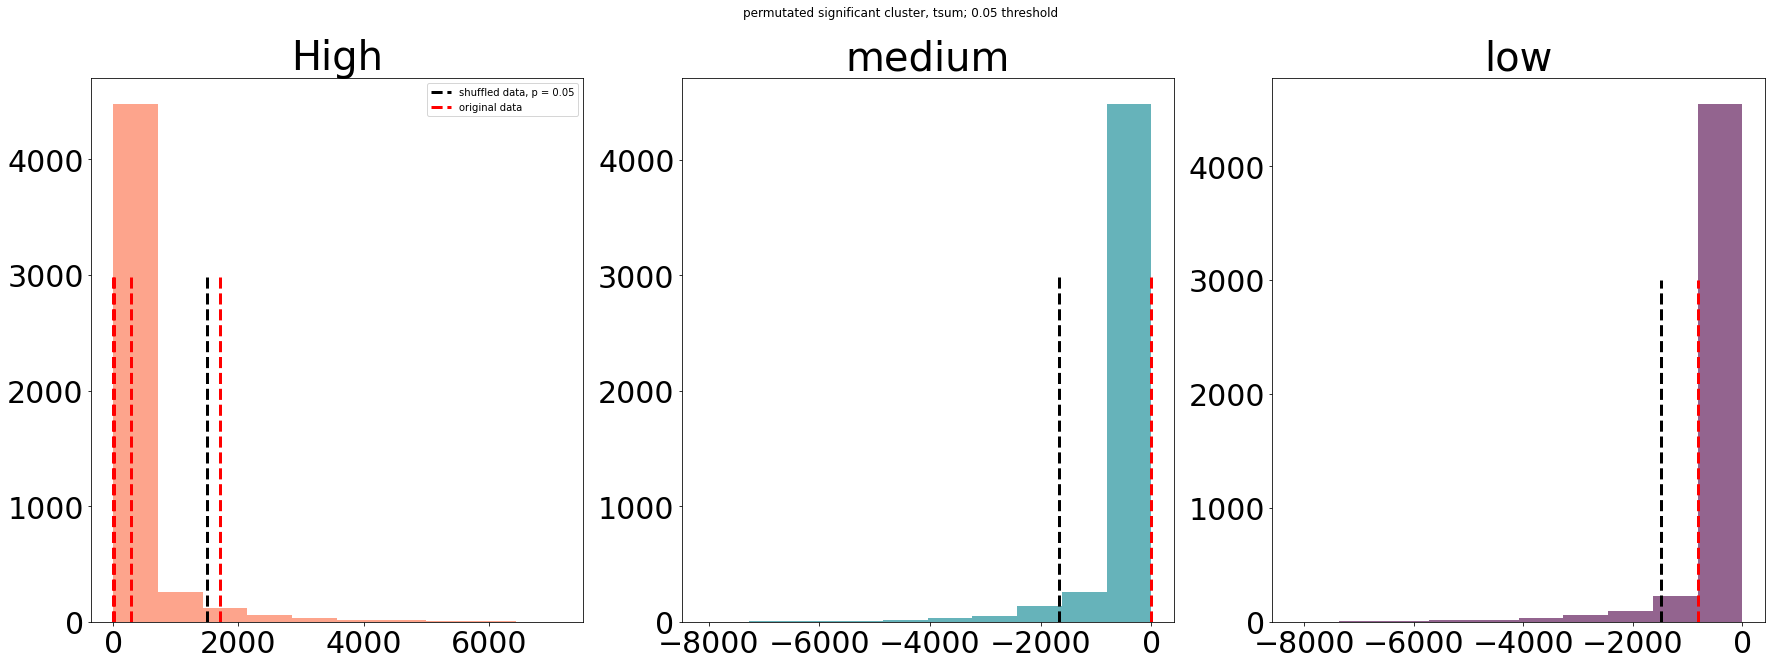

In [192]:
fs(30,10)
t1 = str(np.round(np.quantile(tCluster[0],0.95),2))
t2 = str(np.round(np.quantile(tCluster[1],0.05),2))
t3 = str(np.round(np.quantile(tCluster[2],0.05),2))


fig,ax = plt.subplots(ncols = 3)
ax[0].hist(tCluster[0],color = cList[0])
ax[0].vlines(x=np.quantile(tCluster[0],0.95),color = 'black',linewidth = 3,
           ymin = 0, ymax = 3000,linestyles='dashed',label = 'shuffled data, p = 0.05')
ax[0].vlines(x=allTH,color = 'red',linewidth = 3,
           ymin = 0, ymax = 3000,linestyles='dashed',label = 'original data')
ax[0].set_title('High',fontsize = 40)
ax[0].legend()
#ax[0].text(x = np.quantile(tCluster[0],0.95), y = 3000, s = t1)

ax[1].hist(tCluster[1],color = cList[4])
ax[1].vlines(x=np.quantile(tCluster[1],0.05),color = 'black',linewidth = 3,
           ymin = 0, ymax = 3000,linestyles='dashed')
ax[1].vlines(x=allTM,color = 'red',linewidth = 3,
           ymin = 0, ymax = 3000,linestyles='dashed')
ax[1].set_title('medium',fontsize = 40)
#ax[1].text(x = np.quantile(tCluster[1],0.05)-3000, y = 3000, s = t2)


ax[2].hist(tCluster[2],color = cList[2])
ax[2].vlines(x=np.quantile(tCluster[2],0.05),color = 'black',linewidth = 3,
           ymin = 0, ymax = 3000,linestyles='dashed')
ax[2].vlines(x=allTL,color = 'red',linewidth = 3,
           ymin = 0, ymax = 3000,linestyles='dashed')
ax[2].set_title('low',fontsize = 40)
#ax[2].text(x = np.quantile(tCluster[2],0.05)-3000, y = 3000, s = t3)
[ax[i].tick_params( labelsize=30) for i in range(3)]

plt.suptitle('permutated significant cluster, tsum; 0.05 threshold')

In [193]:
sum( tCluster[0] > allTH[0])/5000

0.0426

### compare across block

In [21]:
#permutation with tCluster
perms = 5000
dataN = 2500
tCluster = np.zeros(shape = (3,perms))

condList = ["['high']","['medium']","['low']"]


eg = retroEpo[np.sum(retroEpo.iloc[:,:dataN].isnull(),axis = 1) ==0].reset_index(drop = True)
eg = eg.iloc[:,np.r_[np.arange(0,dataN),-2,-3,]]

In [22]:
#downsample to 12.5hz to be the same as the pupil lab 
binlen = 80

In [23]:
eg12 = eg.iloc[:,:2500].groupby(np.arange(len(eg.columns)-2)//binlen, axis=1).mean()
eg12['cue_blk_validity'] = eg['cue_blk_validity']
eg12['cued_item'] = eg['cued_item']

In [31]:
eg12.iloc[randTrl,:2500]

0                   -33.323058
1                   -58.342122
2                   -78.106056
3                   -74.485325
4                   -11.479068
5                     3.966745
6                    -9.418469
7                   -22.803683
8                   -26.084431
9                   -30.644008
10                  -27.744749
11                  -26.190074
12                  -20.606626
13                  -10.710519
14                     4.19129
15                   28.157791
16                   80.329583
17                  142.255973
18                  204.229783
19                  249.157517
20                  270.979855
21                  305.853719
22                  321.698037
23                  307.294594
24                  275.427909
25                  249.598255
26                  232.152583
27                  236.149173
28                  268.901446
29                  313.357128
30                  353.867355
31                  376.783264
cue_blk_

Text(0.5, 1.0, 'mean')

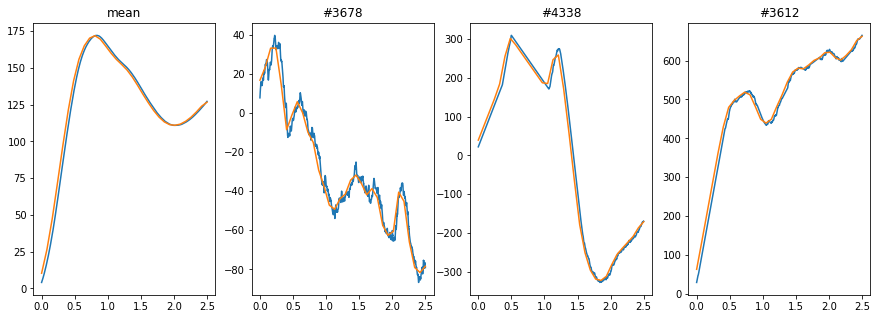

In [39]:
fs(15,5)
fig,ax = plt.subplots(ncols = 4)
ax[0].plot(np.linspace(0,2.5,2500),eg.iloc[:,:2500].mean())
ax[0].plot(np.linspace(0,2.5,32),eg12.iloc[:,:32].mean())

for i in range(1,4):
    randTrl = np.random.randint(13740)
    ax[i].plot(np.linspace(0,2.5,2500),eg.iloc[randTrl,:2500])
    ax[i].plot(np.linspace(0,2.5,32),eg12.iloc[randTrl,:32])
    ax[i].set_title('#'+str(randTrl))

ax[0].set_title('mean')


In [24]:
eg12

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,cue_blk_validity,cued_item
0,75.974318,149.098182,225.447045,302.272614,350.508409,374.745909,379.387386,381.426591,359.662247,349.551589,352.646625,356.177792,359.985763,369.412616,422.356136,473.041932,467.533977,418.222045,363.034545,333.865795,336.937955,355.949318,386.126023,422.166364,463.493636,496.923182,532.691932,572.969773,595.085682,614.868636,630.131705,634.452727,['high'],bri
1,-12.151023,-0.159646,37.858809,81.909442,125.960075,170.010708,218.413340,287.193295,300.722495,194.915817,74.336107,-46.243603,-166.750866,-208.232108,-153.301023,-70.418636,17.500682,90.521136,136.842159,160.176818,186.534205,220.731932,255.434205,289.854091,320.688750,332.521136,343.660909,363.130227,383.308068,400.175114,415.662614,420.842727,['medium'],dar
2,-4.185568,4.830909,45.426932,103.433750,161.078542,196.014242,229.347576,262.680909,295.954867,335.126364,350.725560,243.228734,88.754185,-65.728574,-210.520247,-258.236136,-226.921932,-127.460568,5.820114,119.525795,211.188295,264.492273,258.151932,215.961591,182.712159,194.916705,253.496250,331.501364,410.218409,476.165568,521.594545,540.551364,['low'],dar
3,-4.847219,-18.123428,-38.688328,-67.843737,-103.827194,-144.876235,-189.228400,-235.121228,-281.262044,-396.841057,-538.757614,-637.484318,-697.253068,-707.136591,-667.785455,-596.717273,-492.375227,-380.051364,-272.216705,-188.715568,-153.918977,-159.916705,-189.792841,-242.744545,-283.432614,-302.449659,-309.752500,-329.897955,-344.443409,-336.935455,-317.528068,-301.171818,['low'],dar
4,37.784091,69.688068,94.297159,110.791477,122.882386,113.385795,100.425000,91.581250,80.182386,60.731818,60.453977,79.306818,86.628409,65.403977,30.077273,-6.297727,-38.510227,-79.884091,-123.801136,-155.541477,-173.223295,-185.517045,-199.461932,-191.269886,-156.411932,-110.200568,-68.733523,-30.817614,12.476136,52.459091,93.202273,103.293182,['low'],bri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13735,39.983864,82.684984,137.188518,191.601477,236.602614,273.829318,306.332159,309.835000,306.827614,293.985000,260.481591,218.357159,182.216818,167.752614,171.403750,179.007727,194.977614,215.747500,228.256591,247.975909,260.189545,265.058295,259.946932,256.305455,256.036136,248.749205,237.717386,235.598636,219.225909,209.495227,201.846932,198.723636,['high'],bri
13736,8.759258,17.116076,25.728211,37.165390,47.319934,59.202097,70.236814,79.466340,73.295999,68.127702,67.904854,53.109826,32.114797,20.360825,8.893212,-2.756507,-18.808073,-28.154605,-37.745809,-50.730799,-64.070856,-73.367119,-90.725732,-114.417731,-120.412144,-123.281482,-125.247624,-129.392205,-131.699565,-126.481367,-127.005118,-126.254629,['low'],bri
13737,-11.960727,-13.093000,-19.257351,-11.493672,4.636705,34.373867,65.695227,103.048636,137.022410,153.283619,153.422500,151.447502,138.733716,125.730183,124.883634,119.860047,111.041250,105.956198,106.863924,114.222171,137.229317,167.773127,176.059432,183.974604,184.016178,168.485852,161.493523,162.274879,160.549773,162.094091,169.464171,166.081981,['medium'],bri
13738,20.342471,51.514415,82.695518,104.329510,109.746747,125.713826,141.225479,149.432268,144.441368,139.821518,122.605691,110.796390,108.843108,117.639512,125.438973,131.065291,148.553836,147.608035,148.198476,145.420671,147.491648,143.214353,146.005196,140.007711,146.912318,151.195909,157.023276,164.393352,171.060019,169.572188,176.479431,185.929716,['high'],bri


In [26]:
eg12.columns = eg12.columns.values.astype(str)

In [27]:
o = [pg.anova(data = eg12, dv = i,
              between = ['cued_item','cue_blk_validity'])[['F',
                                                           'p-unc']].iloc[2,:] for i in eg12.columns[:32].values]

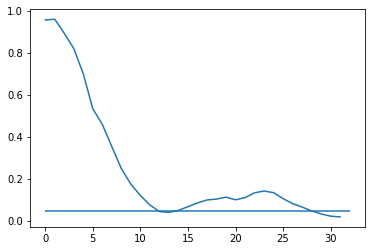

In [29]:
plt.plot(np.array(o)[:,1])
plt.hlines(0.05,0,32,)

In [24]:
eg12HL = eg12[eg12.cue_blk_validity != "['medium']"].reset_index(drop = True)
eg12HM = eg12[eg12.cue_blk_validity != "['low']"].reset_index(drop = True)
eg12ML = eg12[eg12.cue_blk_validity != "['high']"].reset_index(drop = True)

In [32]:
k = [pg.anova(data = eg12HL, dv = i,
              between = ['cued_item','cue_blk_validity'])[['F',
                                                           'p-unc']].iloc[2,:] for i in eg12HL.columns[:32].values]
q = [pg.anova(data = eg12HM, dv = i,
              between = ['cued_item','cue_blk_validity'])[['F',
                                                           'p-unc']].iloc[2,:] for i in eg12HM.columns[:32].values]
j = [pg.anova(data = eg12ML, dv = i,
              between = ['cued_item','cue_blk_validity'])[['F',
                                                           'p-unc']].iloc[2,:] for i in eg12ML.columns[:32].values]

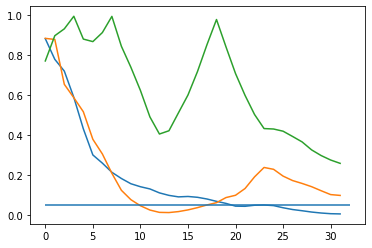

In [50]:
plt.plot(np.array(k)[:,1])
plt.plot(np.array(q)[:,1])
plt.plot(np.array(j)[:,1])

plt.hlines(0.05,0,32,)

In [ ]:
# for high vs medium

In [26]:
# for each iteraction
perms = 5000
fCluster = np.zeros(perms) # permutation iteration x data x f and p 

for n in range(perms):
        print(n)
        # shuffle block label
        eg12HM['randLabel'] = np.random.permutation(eg12HM.cue_blk_validity.values)

        # for each time point, 2 way anova with blk reliability and cued item as dv, and the data as dv
        # get the f score for the interaction effect
        fpThis = np.array([pg.anova(data = eg12HM, dv = i,
              between = ['cued_item','randLabel'])[['F','p-unc']].iloc[2,:] for i in eg12HM.columns[:32].values])
        fArr = fpThis[:,0]

        # find the clusters that exceed p value threshold
        consGroups = consecutive(np.where(fpThis[:,1] < 0.05)[0], stepsize=1,
                        findSame = False)
        
        # find the cluster with the largest length,then find its corresponding t values, sum it up
                #note: if no cluster is found, this will return 0
        fCluster[n] =  np.round(fArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)

# for the real data array, ran the anova test, get the f score clusters sum.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [28]:
#pd.DataFrame(fCluster).to_csv('permutation5000_elHM.csv')

(0.0, 300.0)

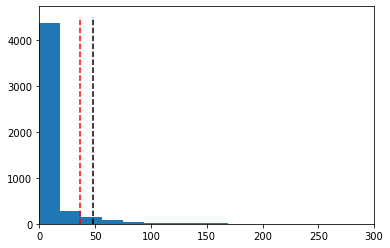

In [34]:
realF = np.array(q)[:,0]
realP = np.array(q)[:,1]

consGroups = consecutive(np.where(realP <= 0.05)[0], stepsize=1,
                        findSame = False)
fsum = [realF[i].sum() for i in consGroups]

plt.hist(fCluster,bins = 20)
plt.vlines([fsum],0,4500,linestyles = 'dashed',color ='r')
plt.vlines(np.percentile(fCluster,95),0,4500,linestyles = 'dashed',color ='black')
plt.xlim(0,300)

In [42]:
sum(fCluster > fsum[0])/5000

0.0728

In [45]:
consGroups[0]*80

array([ 800,  880,  960, 1040, 1120, 1200, 1280], dtype=int64)

In [ ]:
#for high vs low

In [160]:
# for each iteraction
perms = 5000
fCluster = np.zeros(perms) # permutation iteration x data x f and p 

for n in range(perms):
        print(n)
        # shuffle block label
        eg12HL['randLabel'] = np.random.permutation(eg12HL.cue_blk_validity.values)

        # for each time point, 2 way anova with blk reliability and cued item as dv, and the data as dv
        # get the f score for the interaction effect
        fpThis = np.array([pg.anova(data = eg12HL, dv = i,
              between = ['cued_item','randLabel'])[['F','p-unc']].iloc[2,:] for i in eg12HL.columns[:32].values])
        fArr = fpThis[:,0]

        # find the clusters that exceed p value threshold
        consGroups = consecutive(np.where(fpThis[:,1] < 0.05)[0], stepsize=1,
                        findSame = False)
        
        # find the cluster with the largest length,then find its corresponding t values, sum it up
                #note: if no cluster is found, this will return 0
        fCluster[n] =  np.round(fArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)

# for the real data array, ran the anova test, get the f score clusters sum.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [162]:
#pd.DataFrame(fCluster).to_csv('permutation5000_elHL.csv')

In [163]:
realF = np.array(k)[:,0]
realP = np.array(k)[:,1]

In [188]:
consGroups = consecutive(np.where(realP <= 0.05)[0], stepsize=1,
                        findSame = False)

In [189]:
consGroups

[array([20, 21, 22], dtype=int64),
 array([24, 25, 26, 27, 28, 29, 30, 31], dtype=int64)]

In [206]:
fsum = [realF[i].sum() for i in consGroups]
fsum

[11.933258272587695, 45.503317748240406]

In [195]:
np.percentile(fCluster,95)

50.752900000000054

(0.0, 300.0)

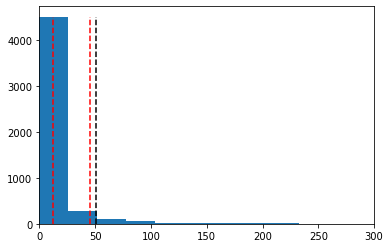

In [211]:
plt.hist(fCluster,bins = 20)
plt.vlines([fsum],0,4500,linestyles = 'dashed',color ='r')
plt.vlines(np.percentile(fCluster,95),0,4500,linestyles = 'dashed',color ='black')
plt.xlim(0,300)

In [205]:
sum(fCluster>fsum[1])/5000

0.0586

In [208]:
consGroups[1]*80

array([1920, 2000, 2080, 2160, 2240, 2320, 2400, 2480], dtype=int64)

### pupil grand

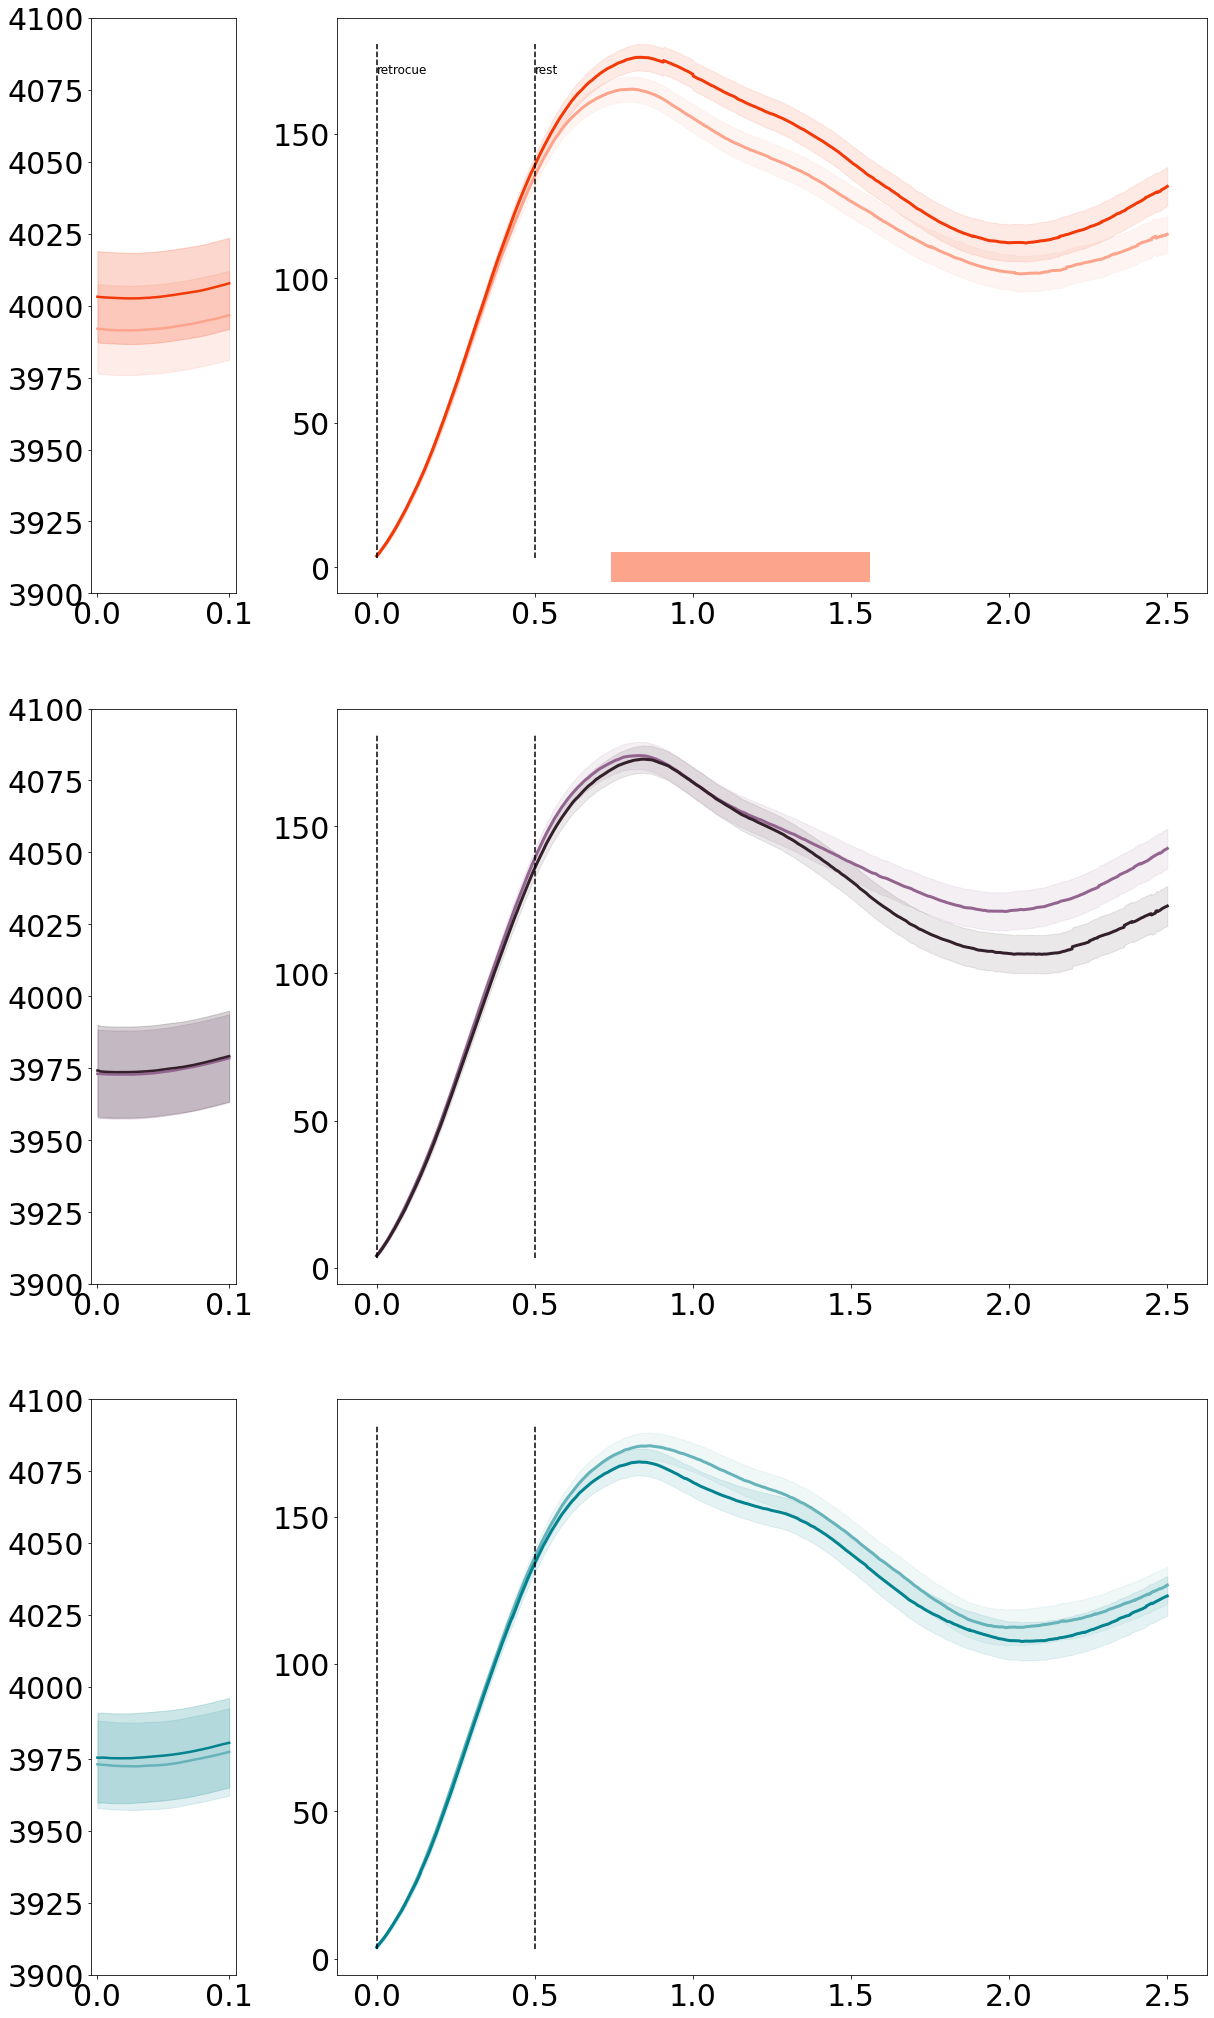

In [230]:
#grand - retro
highSig = consecutive(np.where(trueHP <  0.05)[0], stepsize=1,
               findSame = False)
normmean, norm_sterr = pupilPlot(normPup = retroEpo.iloc[:,np.r_[np.arange(0,2500),-4,-3,-2]],blPup = retroEpoBL.iloc[:,:-1],
          eventt = 2.5,levels=['cue_blk_validity', 'cued_item'],
          blt  = 0.1,cList = cList,pltRatio = [0.5,3],blHeight = [3900,4100],
          eventBoundary = epoch_array[2:-2]-0.75,
          eventName = epoch_name[2:-2],figW = 20,figH = 12,tickSize=30,
          tightPlot=False,
          sigPeriod = [highSig[0][0],highSig[0][-1]])



### pupil mean

In [50]:
pupMean500 = retroEpo.set_index('identifier').iloc[:,:2500].groupby(np.arange(2500)//500,axis =1).mean()
pupMean500 = pd.concat([pupMean500,retroEpo.set_index('identifier').iloc[:,-3:]],axis = 1)

In [63]:
pupMean500Subj = pupMean500.groupby(['subj','cue_blk_validity','cued_item']).mean().reset_index()
pupMean500Subj = pd.melt(pupMean500Subj, id_vars=['subj','cue_blk_validity','cued_item'], 
        value_vars=[0,1,2,3,4],var_name = 'epochIndex')

In [106]:
pval = np.zeros(5)
for n,i in enumerate([0,500,1000,1500,2000]):
    start = int(i)
    end = int((i+500))
    pupMeanDf = retroEpo.iloc[:,np.r_[np.arange(start,end),-4,-3,-2,-1]]
    pupMeanDf['meanPup'] = pupMeanDf.iloc[:,:start-end].mean(axis = 1)
    pval[n] = pg.rm_anova(data =pupMeanDf, dv = 'meanPup',
    within = ['cued_item', 'cue_blk_validity'],subject = 'subj',
    effsize = 'np2').iloc[2,:][['p-unc']].values

[Text(0.5, 1.0, '0.9'),
 Text(0.5, 1.0, '0.86'),
 Text(0.5, 1.0, '0.33'),
 Text(0.5, 1.0, '0.52'),
 Text(0.5, 1.0, '0.39')]

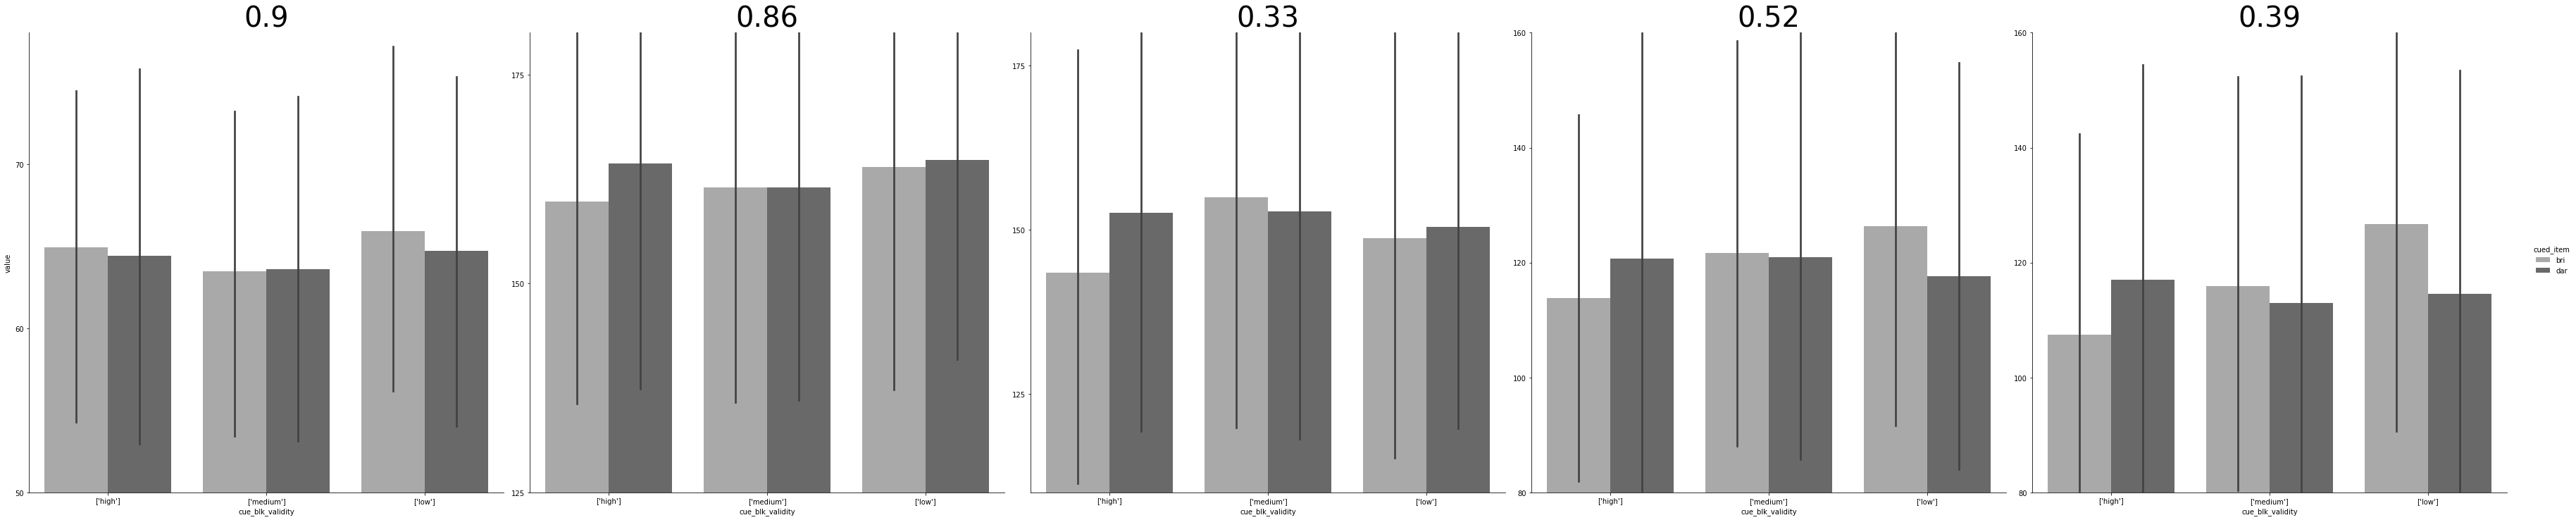

In [110]:
cat = sns.catplot(hue= 'cued_item', y = 'value',x = 'cue_blk_validity',palette=['darkgrey','dimgrey'],
                  order = ["['high']","['medium']","['low']"],height = 10,
                  col='epochIndex',data=pupMean500Subj,kind = 'bar',sharey = False)
axes = cat.axes
cat.set_yticklabels(fontsize = 10)

axes[0,0].set_ylim(50,78)
axes[0,1].set_ylim(125,180)
axes[0,2].set_ylim(110,180)
axes[0,3].set_ylim(80,160)
axes[0,4].set_ylim(80,160)

[i.set_title(round(j,2),fontsize = 40) for i,j in zip(axes[0,:],pval)]

In [107]:
pval

array([0.89853555, 0.85645263, 0.3310272 , 0.51656801, 0.38621977])

In [111]:
retroEpo

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,2755,2756,2757,2758,2759,2760,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794,2795,2796,2797,2798,2799,2800,2801,2802,2803,2804,2805,2806,2807,2808,2809,2810,2811,2812,2813,2814,2815,2816,2817,2818,2819,2820,2821,2822,2823,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833,2834,2835,2836,2837,2838,2839,2840,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,2853,2854,2855,2856,2857,2858,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,2885,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895,2896,2897,2898,2899,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999,u,identifier,cue_blk_validity,cued_item,subj
0,37.714091,38.623182,39.532273,40.850455,42.259545,43.350455,44.850455,46.305000,47.486818,48.759545,50.350455,51.941364,53.486818,54.941364,55.714091,56.214091,57.168636,57.759545,58.441364,59.032273,59.577727,59.850455,60.214091,60.759545,61.259545,61.668636,62.168636,62.668636,63.214091,63.441364,63.532273,64.532273,65.668636,66.577727,67.259545,67.895909,68.759545,69.623182,70.532273,71.668636,73.032273,74.214091,74.259545,74.168636,75.305000,76.395909,77.668636,78.805000,79.623182,80.395909,81.486818,82.577727,83.805000,86.077727,88.305000,89.441364,90.623182,91.668636,92.805000,94.259545,95.759545,97.395909,99.214091,100.986818,101.895909,102.941364,104.214091,105.532273,106.986818,108.486818,110.123182,111.532273,112.168636,112.441364,112.759545,113.895909,114.805000,115.077727,115.395909,115.759545,116.123182,116.577727,116.850455,117.123182,117.577727,118.259545,118.168636,118.259545,118.805000,119.214091,119.486818,120.259545,121.123182,122.077727,122.986818,123.850455,124.532273,125.168636,125.805000,127.168636,128.714091,130.259545,131.441364,132.532273,133.714091,134.986818,136.395909,137.714091,139.214091,140.850455,141.623182,142.214091,142.895909,143.486818,143.850455,144.350455,144.941364,145.577727,146.305000,147.032273,147.486818,148.077727,149.441364,150.850455,152.214091,153.441364,154.532273,155.486818,156.259545,157.214091,157.986818,158.941364,160.577727,161.532273,162.532273,163.532273,164.668636,165.805000,167.395909,169.032273,170.350455,171.668636,172.895909,173.441364,174.305000,174.986818,175.623182,176.532273,177.305000,177.805000,178.668636,179.623182,180.623182,181.759545,182.805000,183.395909,184.032273,185.032273,185.759545,186.714091,187.759545,188.759545,189.714091,190.577727,191.350455,192.305000,193.395909,194.714091,195.895909,197.123182,198.259545,199.441364,200.

In [112]:
pval = np.zeros(5)
for n,i in enumerate([0,500,1000,1500,2000]):
    start = int(i)
    end = int((i+500))
    pupMeanDf = retroEpo[retroEpo.cue_blk_validity!="['medium']"].iloc[:,np.r_[np.arange(start,end),-4,-3,-2,-1]]
    pupMeanDf['meanPup'] = pupMeanDf.iloc[:,:start-end].mean(axis = 1)
    pval[n] = pg.rm_anova(data =pupMeanDf, dv = 'meanPup',
    within = ['cued_item', 'cue_blk_validity'],subject = 'subj',
    effsize = 'np2').iloc[2,:][['p-unc']].values

In [113]:
pval

array([0.79975502, 0.72586052, 0.51588122, 0.25196052, 0.17789118])

In [114]:
pval = np.zeros(5)
for n,i in enumerate([0,500,1000,1500,2000]):
    start = int(i)
    end = int((i+500))
    pupMeanDf = retroEpo[retroEpo.cue_blk_validity!="['low']"].iloc[:,np.r_[np.arange(start,end),-4,-3,-2,-1]]
    pupMeanDf['meanPup'] = pupMeanDf.iloc[:,:start-end].mean(axis = 1)
    pval[n] = pg.rm_anova(data =pupMeanDf, dv = 'meanPup',
    within = ['cued_item', 'cue_blk_validity'],subject = 'subj',
    effsize = 'np2').iloc[2,:][['p-unc']].values

In [115]:
pval

array([0.8490692 , 0.82810594, 0.17962553, 0.37878011, 0.50367682])

In [100]:
start = 750
end = 1500
pupMeanDf = retroEpo.iloc[:,np.r_[np.arange(start,end),-3,-2,-1]]
pupMeanDf['meanPup'] = pupMeanDf.iloc[:,:start-end].mean(axis = 1)

(100.0, 200.0)

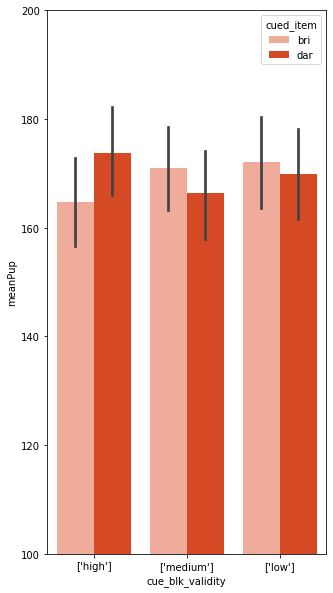

In [101]:
fs(5,10)

sns.barplot(hue= 'cued_item', y = 'meanPup',x = 'cue_blk_validity', 
            palette=cList,
            data = pupMeanDf)
plt.ylim([100,200])

In [102]:
pg.anova(data = pupMeanDf[['cued_item','meanPup','cue_blk_validity']],dv = 'meanPup',between = ['cued_item', 'cue_blk_validity'],)

,Source,SS,DF,MS,F,p-unc,np2
0,cued_item,1.426444e+03,1.0,1426.444021,0.033898,0.853927,0.000002
1,cue_blk_validity,1.348516e+04,2.0,6742.578377,0.160230,0.851950,0.000023
2,cued_item * cue_blk_validity,1.233295e+05,2.0,61664.761694,1.465393,0.231023,0.000212
3,Residual,5.829859e+08,13854.0,42080.693970,NaN,NaN,NaN


In [103]:
pupMeanDf = pupMeanDf.groupby(['subj','cue_blk_validity','cued_item']).meanPup.mean().reset_index()
pg.rm_anova(data =pupMeanDf, dv = 'meanPup',
    within = ['cued_item', 'cue_blk_validity'],subject = 'subj',
    effsize = 'np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cued_item,228.724618,1,48,228.724618,0.364591,0.548810,0.548810,0.007538,1.000000
1,cue_blk_validity,563.459865,2,96,281.729932,0.296429,0.744146,0.743893,0.006138,0.998835
2,cued_item * cue_blk_validity,249.178800,2,96,124.589400,0.199304,0.819639,0.806312,0.004135,0.939807


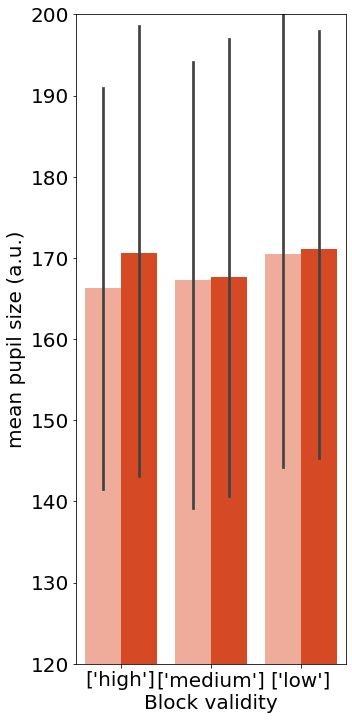

In [77]:
fs(5,10)
fig,ax = plt.subplots()
sns.barplot(hue= 'cued_item', y = 'meanPup',x = 'cue_blk_validity', 
            palette=cList,order = ["['high']","['medium']","['low']"],
            data = pupMeanDf.iloc[:,-4:].reset_index(drop = False))

plt.xlabel('Block validity', fontsize=20)
plt.ylabel('mean pupil size (a.u.)', fontsize=20)
plt.xticks(fontsize=20, )
plt.yticks(fontsize=20, )
fig.tight_layout()
ax.get_legend().set_visible(False)


plt.ylim([120,200])
plt.show()

In [228]:
pval = []
for i in [500,1000,1500,2000]:
    start = int(i)
    end = int(i+500)
    pupMeanDf = retroEpo.iloc[:,np.r_[np.arange(start,end),-3,-2,-1]]
    pupMeanDf['meanPup'] = pupMeanDf.iloc[:,:start-end].mean(axis = 1)
    pval.append(pg.rm_anova(data =pupMeanDf, dv = 'meanPup',
    within = ['cued_item', 'cue_blk_validity'],subject = 'subj',
    effsize = 'np2')[['p-unc']])

In [229]:
pval

[      p-unc
 0  0.913084
 1  0.561649
 2  0.855683,
       p-unc
 0  0.332350
 1  0.846610
 2  0.331314,
       p-unc
 0  0.820878
 1  0.621281
 2  0.516234,
       p-unc
 0  0.721488
 1  0.638671
 2  0.387191]

In [118]:
start = 1000
end = 1500
pupMeanDf = retroEpo.iloc[:,np.r_[np.arange(start,end),-3,-2,-1]]
pupMeanDf['meanPup'] = pupMeanDf.iloc[:,:start-end].mean(axis = 1)
pupMeanDf = pupMeanDf.groupby(['subj','cue_blk_validity','cued_item']).meanPup.mean().reset_index()

In [119]:
pg.rm_anova(data =pupMeanDf, dv = 'meanPup',
    within = ['cued_item', 'cue_blk_validity'],subject = 'subj',
    effsize = 'np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cued_item,843.807024,1,48,843.807024,0.958995,0.332350,0.332350,0.019588,1.000000
1,cue_blk_validity,501.243874,2,96,250.621937,0.166804,0.846610,0.838212,0.003463,0.960077
2,cued_item * cue_blk_validity,1921.788261,2,96,960.894130,1.117500,0.331314,0.329826,0.022752,0.963218


In [120]:
pupVal = pupMeanDf.iloc[1::2,:].meanPup.values - pupMeanDf.iloc[::2,:].meanPup.values

pupVal = pd.concat([pupMeanDf.iloc[1::2,:].reset_index(drop = True).iloc[:,:2],
           pd.DataFrame(pupVal)],axis = 1)
pupVal.rename(columns={0:'pupillaryMemorySignal'},inplace=True)

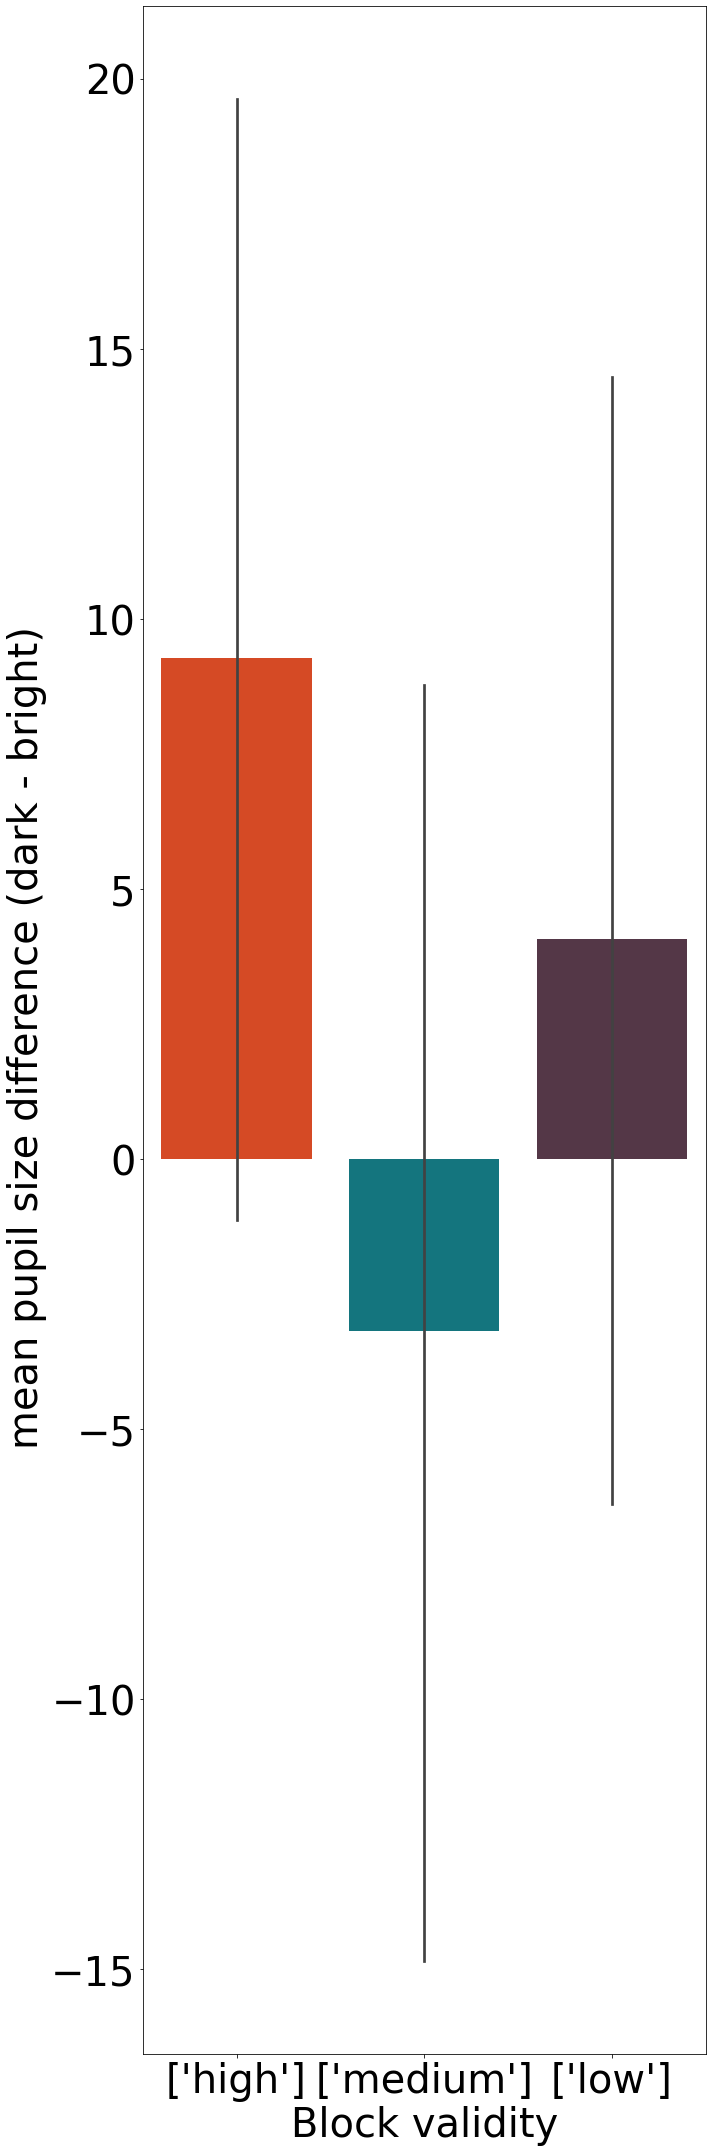

In [121]:
fs(10,30)
fig,ax = plt.subplots()
sns.barplot(x = 'cue_blk_validity', y = 'pupillaryMemorySignal',
            palette=cDict.values(),order = ["['high']","['medium']","['low']"],
            data = pupVal)

plt.xlabel('Block validity', fontsize=40)
plt.ylabel('mean pupil size difference (dark - bright) ', fontsize=40)
plt.xticks(fontsize=40, )
plt.yticks(fontsize=40, )
fig.tight_layout()


plt.show()

#z score each subj pupil

In [80]:
#take z score regarding to subj
retroEpoClean_z = pd.DataFrame()
for i in retroEpo.subj.unique():
    #take z value in regard to subj
    thisSubj = retroEpo[(retroEpo.subj == i)].iloc[:,:2500].values
    flattenedSubj = np.concatenate(thisSubj)
    thisSubj_z = stats.zscore(flattenedSubj,nan_policy = 'omit').reshape(thisSubj.shape)
    
    #replace the value with zscored value
    retroEpoClean_z = pd.concat([retroEpoClean_z,pd.DataFrame(thisSubj_z)],axis = 0)

In [81]:
retroEpoClean_z = pd.concat([retroEpoClean_z.reset_index(drop = True),retroEpo.iloc[:,-4:].reset_index(drop = True)],axis = 1)

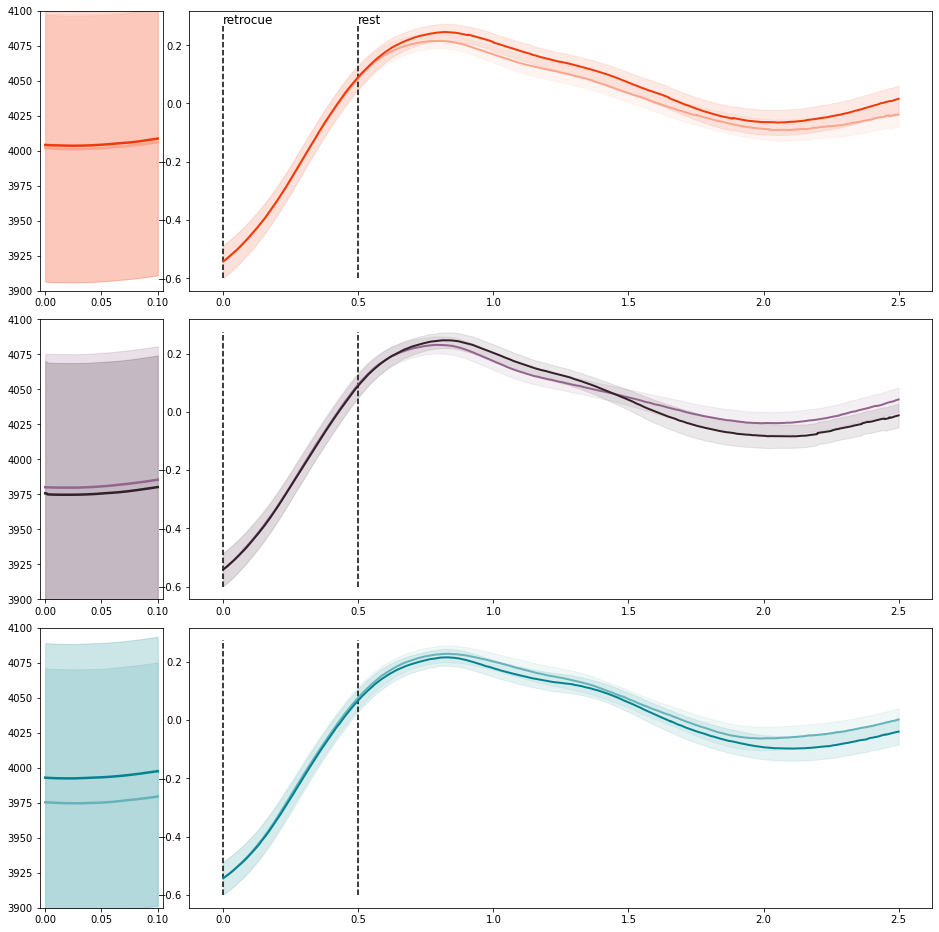

In [166]:
normmean, norm_sterr = pupilPlot(normPup = retroEpoClean_z.iloc[:,np.r_[np.arange(0,2500),-4,-3,-2,-1]],blPup = retroEpoBL.iloc[:,:],
          eventt = 2.5,levels=['cue_blk_validity', 'cued_item'],
          blt  = 0.1,cList = cList,pltRatio = [0.5,3],blHeight = [3900,4100],
          eventBoundary = epoch_array[2:-2]-0.75,textOffset = 0,
          eventName = epoch_name[2:-2],figW = 16,type = 'subj')
          #sigPeriod = [highSig[0][0],highSig[0][-1]])

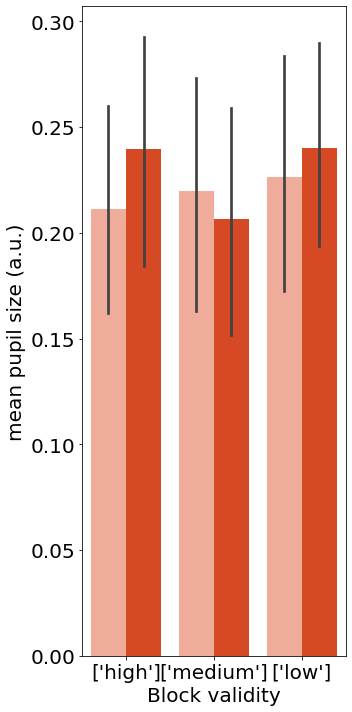

In [82]:
dataN = 2500
eg = retroEpoClean_z[np.sum(retroEpoClean_z.iloc[:,:dataN].isnull(),axis = 1) ==0].reset_index(drop = True)
eg = eg.set_index(['subj','cue_blk_validity']).iloc[:,np.r_[np.arange(0,dataN),-2,-1]]

start = 750
end = 1500
pupMeanDf = eg.iloc[:,np.r_[np.arange(start,end),-2,-1]]
pupMeanDf['meanPup'] = pupMeanDf.iloc[:,:start-end].mean(axis = 1)


pupMeanDf = pupMeanDf.reset_index().groupby(['subj','cue_blk_validity','cued_item']).meanPup.mean().reset_index()


fs(5,10)
fig,ax = plt.subplots()
sns.barplot(hue= 'cued_item', y = 'meanPup',x = 'cue_blk_validity', 
            palette=cList,order = ["['high']","['medium']","['low']"],
            data = pupMeanDf.iloc[:,-4:].reset_index(drop = False))

plt.xlabel('Block validity', fontsize=20)
plt.ylabel('mean pupil size (a.u.)', fontsize=20)
plt.xticks(fontsize=20, )
plt.yticks(fontsize=20, )
fig.tight_layout()
ax.get_legend().set_visible(False)


plt.show()

In [170]:
pg.rm_anova(data =pupMeanDf, dv = 'meanPup',
    within = ['cued_item', 'cue_blk_validity'],subject = 'subj',
    effsize = 'np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cued_item,0.006890,1,48,0.006890,0.433872,0.513243,0.513243,0.008958,1.000000
1,cue_blk_validity,0.020154,2,96,0.010077,0.499966,0.608122,0.603934,0.010309,0.977448
2,cued_item * cue_blk_validity,0.022417,2,96,0.011208,1.011686,0.367449,0.363307,0.020642,0.934066


# rolling correlation(temp)

In [ ]:
test = retroEpo.copy()
test = test.merge(psyFull[['identifier','abs_distance_to_probed_item','cue_condition']])

In [ ]:
#test['meanPup_750to1550'] = test.iloc[:,750:1550].mean(axis = 1)

In [ ]:
rBri = np.zeros(shape=(len(test.subj.unique()),2500))
rDar = np.zeros(shape=(len(test.subj.unique()),2500))

testBri = test[(test.cue_condition == 'valid')&
               (test.cued_item == 'bri')].reset_index(drop = True)
testDar = test[(test.cue_condition == 'valid')&
               (test.cued_item == 'dar')].reset_index(drop = True)

for n,i in enumerate(test.subj.unique()):
    thisBri = testBri[testBri.subj == i].reset_index(drop = True)
    thisDar = testDar[testDar.subj == i].reset_index(drop = True)

    rBri[n] = [thisBri.iloc[:,k].corr(thisBri.abs_distance_to_probed_item)for k in range(2500)]
    rDar[n] = [thisDar.iloc[:,k].corr(thisDar.abs_distance_to_probed_item)for k in range(2500)]

In [ ]:
rBriMean = rBri.mean(axis = 0)
rBriUpper = rBriMean + rBri.std(axis = 0)/ np.sqrt(49)
rBriLower = rBriMean - rBri.std(axis = 0)/ np.sqrt(49)

rDarMean = rDar.mean(axis = 0)
rDarUpper = rDarMean + rDar.std(axis = 0)/ np.sqrt(49)
rDarLower = rDarMean - rDar.std(axis = 0)/ np.sqrt(49)


In [ ]:
fs(10,5)

In [ ]:
#all
x = np.linspace(0,2.5,2500,)
plt.plot(x,rBriMean,color = 'grey',label = 'bright')
plt.fill_between(x,rBriLower,rBriUpper,alpha = 0.3,color = 'grey')


plt.plot(x,rDarMean,color = 'black',label = 'dark')
plt.fill_between(x,rDarLower,rDarUpper,alpha = 0.3,color = 'black')

plt.hlines(0,0,2.5,linestyles='dashed',colors='black')

plt.legend(prop={'size': 20})

plt.ylabel('r')
plt.xlabel('time')

plt.vlines(epoch_array[2:-2]-0.75,-0.05,0.05,
           linestyles = 'dashed',colors= 'black')
for i,m in zip(epoch_array[2:-2]-0.75,epoch_name[2:-1]):
    plt.text(i,0.05,m,c = 'black',size = 15)


plt.title('rolling correlation of pupil size and behavior, subject avgeraged ',size = 15)

In [ ]:
#select the first and second half
test['blkNum'] = [ast.literal_eval(i)[2] for i in test.identifier]


rFirst = np.zeros(shape=(len(test.subj.unique()),2500))
rLast = np.zeros(shape=(len(test.subj.unique()),2500))

testValid = test[(test.cue_condition == 'valid')].reset_index(drop = True)

for n,i in enumerate(test.subj.unique()):
    thisTest = testValid[testValid.subj == i].reset_index(drop = True)

    thisFirst = thisTest[thisTest.blkNum < 7].reset_index(drop = True)
    thisLast = thisTest[thisTest.blkNum >= 7].reset_index(drop = True)

    rFirst[n] = [thisFirst.iloc[:,k].corr(thisFirst.abs_distance_to_probed_item)for k in range(2500)]
    rLast[n] = [thisLast.iloc[:,k].corr(thisLast.abs_distance_to_probed_item)for k in range(2500)]


In [ ]:
rFirstMean = rFirst.mean(axis = 0)
rFirstUpperFirst = rFirstMean + rFirst.std(axis = 0)/ np.sqrt(49)
rFirstLowerFirst = rFirstMean - rFirst.std(axis = 0)/ np.sqrt(49)

rLastMean = rLast.mean(axis = 0)
rLastUpperLast = rLastMean + rLast.std(axis = 0)/ np.sqrt(49)
rLastLowerLast = rLastMean - rLast.std(axis = 0)/ np.sqrt(49)

In [ ]:
fs(10,5)

In [ ]:
#all
x = np.linspace(0,2.5,2500,)
plt.plot(x,rFirstMean,color = 'red',label = 'first half')
plt.fill_between(x,rFirstLowerFirst,rFirstUpperFirst,alpha = 0.3,color = 'red')

plt.plot(x,rLastMean,color = 'blue',label = 'second half')
plt.fill_between(x,rLastLowerLast,rLastUpperLast,alpha = 0.3,color = 'blue')


plt.hlines(0,0,2.5,linestyles='dashed',colors='black')

plt.legend(prop={'size': 20})

plt.ylabel('r')
plt.xlabel('time')

plt.vlines(epoch_array[2:-2]-0.75,-0.05,0.05,
           linestyles = 'dashed',colors= 'black')
for i,m in zip(epoch_array[2:-2]-0.75,epoch_name[2:-1]):
    plt.text(i,0.05,m,c = 'black',size = 15)


plt.title('rolling correlation of pupil size and behavior, subject avgeraged ',size = 15)

In [ ]:
testValid['meanPup2500'] = testValid.iloc[:,:2500].mean(axis = 1)
pupMeanBlk = testValid.groupby(['subj','blkNum'])[['abs_distance_to_probed_item','meanPup2500']].mean().reset_index()

In [ ]:
fs(10,5)
sns.lineplot(x = 'blkNum',y = 'meanPup2500',markers=True, dashes=False,
              color='black',
             data = pupMeanBlk)
plt.title('TEPR magnitude over blocks',size = 15)
plt.ylabel('mean pupil size of delay (2500ms)',size = 15)
plt.xlabel('blocks ',size = 15)


In [ ]:
rFirstBri = np.zeros(shape=(len(test.subj.unique()),2500))
rLastBri = np.zeros(shape=(len(test.subj.unique()),2500))
rFirstDar = np.zeros(shape=(len(test.subj.unique()),2500))
rLastDar = np.zeros(shape=(len(test.subj.unique()),2500))

testValidBri = test[(test.cue_condition == 'valid')&(test.cued_item == 'bri')].reset_index(drop = True)
testValidDar = test[(test.cue_condition == 'valid')&(test.cued_item == 'dar')].reset_index(drop = True)


for n,i in enumerate(test.subj.unique()):
    thisTestBri = testValidBri[testValidBri.subj == i].reset_index(drop = True)
    thisTestDar = testValidDar[testValidDar.subj == i].reset_index(drop = True)

    thisFirstBri = thisTestBri[thisTestBri.blkNum < 7].reset_index(drop = True)
    thisLastBri = thisTestBri[thisTestBri.blkNum >= 7].reset_index(drop = True)

    thisFirstDar = thisTestDar[thisTestDar.blkNum < 7].reset_index(drop = True)
    thisLastDar = thisTestDar[thisTestDar.blkNum >= 7].reset_index(drop = True)


    rFirstBri[n] = [thisFirstBri.iloc[:,k].corr(thisFirstBri.abs_distance_to_probed_item)for k in range(2500)]
    rLastBri[n] = [thisLastBri.iloc[:,k].corr(thisLastBri.abs_distance_to_probed_item)for k in range(2500)]
    rFirstDar[n] = [thisFirstDar.iloc[:,k].corr(thisFirstDar.abs_distance_to_probed_item)for k in range(2500)]
    rLastDar[n] = [thisLastDar.iloc[:,k].corr(thisLastDar.abs_distance_to_probed_item)for k in range(2500)]

In [ ]:
rFirstBriMean = rFirstBri.mean(axis = 0)
rFirstBriUpperFirstBri = rFirstBriMean + rFirstBri.std(axis = 0)/ np.sqrt(49)
rFirstBriLowerFirstBri = rFirstBriMean - rFirstBri.std(axis = 0)/ np.sqrt(49)

rLastBriMean = rLastBri.mean(axis = 0)
rLastBriUpperLastBri = rLastBriMean + rLastBri.std(axis = 0)/ np.sqrt(49)
rLastBriLowerLastBri = rLastBriMean - rLastBri.std(axis = 0)/ np.sqrt(49)


rFirstDarMean = rFirstDar.mean(axis = 0)
rFirstDarUpperFirstDar = rFirstDarMean + rFirstDar.std(axis = 0)/ np.sqrt(49)
rFirstDarLowerFirstDar = rFirstDarMean - rFirstDar.std(axis = 0)/ np.sqrt(49)

rLastDarMean = rLastDar.mean(axis = 0)
rLastDarUpperLastDar = rLastDarMean + rLastDar.std(axis = 0)/ np.sqrt(49)
rLastDarLowerLastDar = rLastDarMean - rLastDar.std(axis = 0)/ np.sqrt(49)

In [ ]:
#all
fs(20,5)
fig,ax = plt.subplots(ncols=2,sharex=True, sharey=True)
x = np.linspace(0,2.5,2500,)

ax[0].plot(x,rFirstBriMean,color = 'coral',label = 'First half,Bri', )
ax[0].fill_between(x,rFirstBriLowerFirstBri,rFirstBriUpperFirstBri,alpha = 0.3,color = 'coral')

ax[0].plot(x,rFirstDarMean,color = 'red',label = 'First half,Dar ')
ax[0].fill_between(x,rFirstDarLowerFirstDar,rFirstDarUpperFirstDar,alpha = 0.3,color = 'red')

ax[1].plot(x,rLastBriMean,color = 'cornflowerblue',label = 'Second half,Bri')
ax[1].fill_between(x,rLastBriLowerLastBri,rLastBriUpperLastBri,alpha = 0.3,color = 'cornflowerblue')
ax[1].plot(x,rLastDarMean,color = 'blue',label = 'second half,Dar')
ax[1].fill_between(x,rLastDarLowerLastDar,rLastDarUpperLastDar,alpha = 0.3,color = 'blue')


for k in [0,1]:
    ax[k].hlines(0,0,2.5,linestyles='dashed',colors='black')

    ax[k].legend(prop={'size': 10})

    ax[k].set_ylabel('r')
    ax[k].set_xlabel('time')

    ax[k].vlines(epoch_array[2:-2]-0.75,-0.05,0.05,
            linestyles = 'dashed',colors= 'black')
    for i,m in zip(epoch_array[2:-2]-0.75,epoch_name[2:-1]):
        ax[k].text(i,0.05,m,c = 'black',size = 15)
fig.tight_layout()

plt.title('rolling correlation of pupil size and behavior, subject avgeraged ',size = 15)

In [ ]:
testValid['meanPup2500'] = testValid.iloc[:,:2500].mean(axis = 1)
pupMeanBlk = testValid.groupby(['subj','blkNum','cued_item'])[['abs_distance_to_probed_item','meanPup2500']].mean().reset_index()

In [ ]:
psychoPLRBlk = pd.concat([pupMeanBlk.iloc[1::2,:2].reset_index(drop = True),
          pupMeanBlk.iloc[1::2,4].reset_index(drop = True) - pupMeanBlk.iloc[0::2,4].reset_index(drop = True)],axis = 1)

In [ ]:
fs(10,5)
sns.lineplot(x = 'blkNum',y = 'meanPup2500',color = 'black' ,
             dashes=False,data = psychoPLRBlk)
plt.title('psychosensory PLR magnitude over blocks',size = 15)
plt.ylabel('mean pupil size of delay (2500ms)',size = 15)
plt.xlabel('blocks ',size = 15)


In [ ]:
#calculate each subj's psychoPLR, and their mean baseline

pupMeanSubj = testValid.groupby(['subj','cued_item'])[['abs_distance_to_probed_item','meanPup2500']].mean().reset_index()

psychoPLRSubj = pd.concat([pupMeanSubj.iloc[1::2,0].reset_index(drop = True),
          pupMeanSubj.iloc[1::2,-1].reset_index(drop = True) - pupMeanSubj.iloc[0::2,-1].reset_index(drop = True)],axis = 1)

psychoPLRSubj = pd.concat([psychoPLRSubj,testValid.groupby(['subj'])['u'].mean().reset_index()],axis =1)
psychoPLRSubj = pd.concat([psychoPLRSubj,testValid.groupby(['subj'])['abs_distance_to_probed_item'].mean().reset_index()],axis =1)

In [ ]:
fs(5,5)
fig,ax = plt.subplots()
sns.regplot(x = 'u', y = 'meanPup2500', data = psychoPLRSubj,ax = ax)
ax.set(ylabel = 'psychosensory PLR magnitude')
plt.xlabel('baseline pupil size',size = 15)
plt.title('baseline pupil size v.s. psychosensory PLR magnitude',size = 15)

In [ ]:
stats.pearsonr(psychoPLRSubj.u,psychoPLRSubj.meanPup2500)

In [ ]:
fs(5,5)
fig,ax = plt.subplots()
sns.regplot(x = 'abs_distance_to_probed_item', y = 'meanPup2500', data = psychoPLRSubj,ax = ax)
ax.set(ylabel = 'psychosensory PLR magnitude')
plt.xlabel('avg rsp. error',size = 15)
plt.title('rsp. err v.s. psychosensory PLR magnitude  ',size = 15)

In [ ]:
stats.pearsonr(psychoPLRSubj.abs_distance_to_probed_item,psychoPLRSubj.meanPup2500)

In [ ]:
fs(1,5)
fs(5,5)
fig,ax = plt.subplots()
sns.regplot(x = 'u', y = 'abs_distance_to_probed_item', data = psychoPLRSubj,ax = ax)
ax.set(ylabel = 'memory error')
plt.xlabel('baseline pupil size',size = 15)

plt.title('correlation between baseline'+'\n' +'pupil size and response error',size = 15)


In [ ]:
r = np.zeros(shape=(len(test.subj.unique()),2500))


testValid = test[(test.cue_condition == 'valid')].reset_index(drop = True)

for n,i in enumerate(test.subj.unique()):
    thisTest = testValid[testValid.subj == i].reset_index(drop = True)

    r[n] = [thisTest.iloc[:,k].corr(thisTest.abs_distance_to_probed_item)for k in range(2500)]


In [ ]:
rMean = r.mean(axis = 0)
rUpper = rMean + r.std(axis = 0)/ np.sqrt(49)
rLower = rMean - r.std(axis = 0)/ np.sqrt(49)

In [ ]:
#all
x = np.linspace(0,2.5,2500,)
plt.plot(x,rMean,color = 'grey',label = 'aggregated')
plt.fill_between(x,rLower,rUpper,alpha = 0.3,color = 'grey')



plt.hlines(0,0,2.5,linestyles='dashed',colors='black')

plt.legend(prop={'size': 20})

plt.ylabel('r')
plt.xlabel('time')

plt.vlines(epoch_array[2:-2]-0.75,-0.05,0.05,
           linestyles = 'dashed',colors= 'black')
for i,m in zip(epoch_array[2:-2]-0.75,epoch_name[2:-1]):
    plt.text(i,0.05,m,c = 'black',size = 15)


plt.title('rolling correlation of pupil size and behavior, subject avgeraged ',size = 15)

# rolling correlation with other variables

In [ ]:
mouse = pd.read_csv('Z:/LiteBrite_YueyingDong/temp/elResults/mouseTrajProcessed.csv')

In [ ]:
mouseCorrVar = mouse[['identifier','initMoveRT','firstClickRT','firstClickErr','lastReleaseRT']]
test = test.merge(how = 'left', right = mouseCorrVar, on = 'identifier')

In [ ]:
rBri = np.zeros(shape=(len(test.subj.unique()),2500))
rDar = np.zeros(shape=(len(test.subj.unique()),2500))

testBri = test[(test.cue_condition == 'valid')&
               (test.cued_item == 'bri')].reset_index(drop = True)
testDar = test[(test.cue_condition == 'valid')&
               (test.cued_item == 'dar')].reset_index(drop = True)

for n,i in enumerate(test.subj.unique()):
    thisBri = testBri[testBri.subj == i].reset_index(drop = True)
    thisDar = testDar[testDar.subj == i].reset_index(drop = True)

    rBri[n] = [thisBri.iloc[:,k].corr(thisBri.lastReleaseRT)for k in range(2500)]
    rDar[n] = [thisDar.iloc[:,k].corr(thisDar.lastReleaseRT)for k in range(2500)]

In [ ]:
rBriMean = rBri.mean(axis = 0)
rBriUpper = rBriMean + rBri.std(axis = 0)/ np.sqrt(49)
rBriLower = rBriMean - rBri.std(axis = 0)/ np.sqrt(49)

rDarMean = rDar.mean(axis = 0)
rDarUpper = rDarMean + rDar.std(axis = 0)/ np.sqrt(49)
rDarLower = rDarMean - rDar.std(axis = 0)/ np.sqrt(49)


In [ ]:
#all
x = np.linspace(0,2.5,2500,)
plt.plot(x,rBriMean,color = 'grey',label = 'bright')
plt.fill_between(x,rBriLower,rBriUpper,alpha = 0.3,color = 'grey')


plt.plot(x,rDarMean,color = 'black',label = 'dark')
plt.fill_between(x,rDarLower,rDarUpper,alpha = 0.3,color = 'black')

plt.hlines(0,0,2.5,linestyles='dashed',colors='black')

plt.legend(prop={'size': 20})

plt.ylabel('r')
plt.xlabel('time')

plt.vlines(epoch_array[2:-2]-0.75,-0.05,0.05,
           linestyles = 'dashed',colors= 'black')
for i,m in zip(epoch_array[2:-2]-0.75,epoch_name[2:-1]):
    plt.text(i,0.05,m,c = 'black',size = 15)


plt.title('rolling correlation of pupil size and rt, subject avgeraged ',size = 15)

In [ ]:
mouseCorrVar

# rolling correlation results (don't modify)

In [ ]:
#low
x = np.linspace(0,2.5,2500,)
plt.plot(x,rBriMean,color = 'grey',label = 'bright')
plt.fill_between(x,rBriLower,rBriUpper,alpha = 0.3,color = 'grey')


plt.plot(x,rDarMean,color = 'black',label = 'dark')
plt.fill_between(x,rDarLower,rDarUpper,alpha = 0.3,color = 'black')

plt.hlines(0,0,2.5,linestyles='dashed',colors='black')

plt.legend(prop={'size': 20})

plt.ylabel('r')
plt.xlabel('time')

plt.vlines(epoch_array[2:-2]-0.75,-0.05,0.05,
           linestyles = 'dashed',colors= 'black')
for i,m in zip(epoch_array[2:-2]-0.75,epoch_name[2:-1]):
    plt.text(i,0.05,m,c = 'black',size = 15)


plt.title('rolling correlation of pupil size and behavior, subject avgeraged ',size = 15)

In [ ]:
#medium
x = np.linspace(0,2.5,2500,)
plt.plot(x,rBriMean,color = 'grey',label = 'bright')
plt.fill_between(x,rBriLower,rBriUpper,alpha = 0.3,color = 'grey')


plt.plot(x,rDarMean,color = 'black',label = 'dark')
plt.fill_between(x,rDarLower,rDarUpper,alpha = 0.3,color = 'black')

plt.hlines(0,0,2.5,linestyles='dashed',colors='black')

plt.legend(prop={'size': 20})

plt.ylabel('r')
plt.xlabel('time')

plt.vlines(epoch_array[2:-2]-0.75,-0.05,0.05,
           linestyles = 'dashed',colors= 'black')
for i,m in zip(epoch_array[2:-2]-0.75,epoch_name[2:-1]):
    plt.text(i,0.05,m,c = 'black',size = 15)


plt.title('rolling correlation of pupil size and behavior, subject avgeraged ',size = 15)

In [ ]:
#high
x = np.linspace(0,2.5,2500,)
plt.plot(x,rBriMean,color = 'grey',label = 'bright')
plt.fill_between(x,rBriLower,rBriUpper,alpha = 0.3,color = 'grey')


plt.plot(x,rDarMean,color = 'black',label = 'dark')
plt.fill_between(x,rDarLower,rDarUpper,alpha = 0.3,color = 'black')

plt.hlines(0,0,2.5,linestyles='dashed',colors='black')

plt.legend(prop={'size': 20})

plt.ylabel('r')
plt.xlabel('time')

plt.vlines(epoch_array[2:-2]-0.75,-0.05,0.05,
           linestyles = 'dashed',colors= 'black')
for i,m in zip(epoch_array[2:-2]-0.75,epoch_name[2:-1]):
    plt.text(i,0.05,m,c = 'black',size = 15)


plt.title('rolling correlation of pupil size and behavior, subject avgeraged ',size = 15)

# difference corr

In [ ]:
import scipy.spatial.distance as spatialCorr

In [ ]:
#select the valid trials
retroEpoSubjMean = test[(test.cue_condition == 'valid')].groupby(['subj','cued_item',]).mean().iloc[:,:2500].reset_index()

#get the psychoplr magnitude
psychoPLRSubj = pd.concat([retroEpoSubjMean.iloc[1::2,3:].reset_index(drop=True) - 
           retroEpoSubjMean.iloc[::2,3:].reset_index(drop=True),
           retroEpoSubjMean.iloc[::2,:2].reset_index(drop=True)],axis = 1)

#get the behavioral measurements,
behavSubj_validTrl = test[test.cue_condition == 'valid'].iloc[:,3000:].groupby(['subj',]).mean().reset_index().drop(columns='u')

#merge the two
psychoPLRSubj = psychoPLRSubj.merge(behavSubj_validTrl,on = ['subj'],how = 'left')

#get rolling correlation and p value for the err
rErrAll = [spatialCorr.correlation(psychoPLRSubj.iloc[:,k].values,psychoPLRSubj.abs_distance_to_probed_item.values)  for k in range(2500)]
#pErrAll = [spatialCorr.correlation(psychoPLRSubj.iloc[:,k],psychoPLRSubj.abs_distance_to_probed_item) [1] for k in range(2500)]

#get rolling correlation and p value for the rt
rRtAll = [spatialCorr.correlation(psychoPLRSubj.iloc[:,k],psychoPLRSubj.lastReleaseRT)  for k in range(2500)]
#pRtAll = [spatialCorr.correlation(psychoPLRSubj.iloc[:,k],psychoPLRSubj.lastReleaseRT) [1] for k in range(2500)]

In [ ]:
rRtInitAll = [spatialCorr.correlation(psychoPLRSubj.iloc[:,k].values,psychoPLRSubj.initMoveRT.values)  for k in range(2500)]
rErrFstClickAll = [spatialCorr.correlation(psychoPLRSubj.iloc[:,k].values,psychoPLRSubj.firstClickErr.values)  for k in range(2500)]
rRtFstClickAll = [spatialCorr.correlation(psychoPLRSubj.iloc[:,k].values,psychoPLRSubj.firstClickRT.values)  for k in range(2500)]


In [ ]:
#get rolling correlation and p value for the init rt
rRtInitAll = [stats.pearsonr(psychoPLRSubj.iloc[:,k],psychoPLRSubj.initMoveRT) [0] for k in range(2500)]
pRtInitAll = [stats.pearsonr(psychoPLRSubj.iloc[:,k],psychoPLRSubj.initMoveRT) [1] for k in range(2500)]

#get rolling correlation and p value for the firstClickErr
rErrFstClickAll = [stats.pearsonr(psychoPLRSubj.iloc[:,k],psychoPLRSubj.firstClickErr) [0] for k in range(2500)]
pErrFstClickAll = [stats.pearsonr(psychoPLRSubj.iloc[:,k],psychoPLRSubj.firstClickErr) [1] for k in range(2500)]

#get rolling correlation and p value for the firstClickErr
rRtFstClickAll = [stats.pearsonr(psychoPLRSubj.iloc[:,k],psychoPLRSubj.firstClickRT) [0] for k in range(2500)]
pRtFstClickAll = [stats.pearsonr(psychoPLRSubj.iloc[:,k],psychoPLRSubj.firstClickRT) [1] for k in range(2500)]

In [ ]:
fs(10,5)
x = np.linspace(0,2.5,2500,)
plt.plot(x,rErrAll,color = 'cornflowerblue',label = 'final response error')
plt.plot(x,rErrFstClickAll,color = 'b',label = 'first click response error')

plt.plot(x,rRtAll,color = 'coral',label ='final rt' )
plt.plot(x,rRtFstClickAll,color = 'r',label = 'first click rt')

plt.plot(x,rRtInitAll,color = 'yellow',label = 'movement initialization rt')

#plt.hlines(0.,0,2.5,linestyles='dashed',colors='black')

plt.legend(prop={'size': 20},bbox_to_anchor=[1, 0.5])

plt.ylabel('r')
plt.xlabel('time')

plt.vlines(epoch_array[2:-2]-0.75,0.6,1.25,
           linestyles = 'dashed',colors= 'black')
for i,m in zip(epoch_array[2:-2]-0.75,epoch_name[2:-1]):
    plt.text(i,1.25,m,c = 'black',size = 15)


plt.title('rolling correlation of psychoPLR and behavioral metrics, subject avgeraged ',size = 15)
plt.show()

In [ ]:
x = np.linspace(0,2.5,2500,)
plt.plot(x,pErrAll,color = 'cornflowerblue',label = 'final response error')
plt.plot(x,pErrFstClickAll,color = 'b',label = 'first click response error')

plt.plot(x,pRtAll,color = 'coral',label ='final rt' )
plt.plot(x,pRtFstClickAll,color = 'r',label = 'first click rt')

plt.plot(x,pRtInitAll,color = 'yellow',label = 'movement initialization rt')

plt.hlines(0.05,0,2.5,linestyles='dashed',colors='black')

plt.legend(prop={'size': 20},bbox_to_anchor=[1, 0.5])

plt.ylabel('p')
plt.xlabel('time')

plt.vlines(epoch_array[2:-2]-0.75,0,1,
           linestyles = 'dashed',colors= 'black')
for i,m in zip(epoch_array[2:-2]-0.75,epoch_name[2:-1]):
    plt.text(i,1,m,c = 'black',size = 15)

plt.title('rolling correlation p values of psychoPLR and behavioral metrics, subject avgeraged ',size = 15)

In [ ]:
retroEpoSubjMean = test[test.cue_condition == 'valid'].groupby(['subj','cue_blk_validity','cued_item',]).mean().iloc[:,:2500].reset_index()

#get the psychoplr magnitude
psychoPLRSubj = pd.concat([retroEpoSubjMean.iloc[1::2,3:].reset_index(drop=True) - 
           retroEpoSubjMean.iloc[::2,3:].reset_index(drop=True),
           retroEpoSubjMean.iloc[::2,:2].reset_index(drop=True)],axis = 1)
#get the behavioral measurements,
behavSubj_validTrl = test[test.cue_condition == 'valid'].iloc[:,3000:].groupby(['subj','cue_blk_validity']).mean().reset_index().drop(columns='u')

psychoPLRSubj = psychoPLRSubj.merge(behavSubj_validTrl,on = ['subj','cue_blk_validity'],how = 'left')

In [ ]:
testH = psychoPLRSubj[psychoPLRSubj.cue_blk_validity == "['high']"].reset_index(drop = True)
testM = psychoPLRSubj[psychoPLRSubj.cue_blk_validity == "['medium']"].reset_index(drop = True)
testL = psychoPLRSubj[psychoPLRSubj.cue_blk_validity == "['low']"].reset_index(drop = True)


rH = [stats.pearsonr(testH.iloc[:,k],testH.abs_distance_to_probed_item) [0] for k in range(2500)]
rM = [stats.pearsonr(testM.iloc[:,k],testM.abs_distance_to_probed_item)[0]for k in range(2500)]
rL = [stats.pearsonr(testL.iloc[:,k],testL.abs_distance_to_probed_item)[0]for k in range(2500)]


pH = [stats.pearsonr(testH.iloc[:,k],testH.abs_distance_to_probed_item) [1] for k in range(2500)]
pM = [stats.pearsonr(testM.iloc[:,k],testM.abs_distance_to_probed_item)[1]for k in range(2500)]
pL = [stats.pearsonr(testL.iloc[:,k],testL.abs_distance_to_probed_item)[1]for k in range(2500)]

In [ ]:
#medium
x = np.linspace(0,2.5,2500,)
plt.plot(x,rH,color = cList[1],label = 'high')
plt.plot(x,rM,color = cList[5],label = 'medium')
plt.plot(x,rL,color = cList[3],label = 'low')

plt.hlines(0,0,2.5,linestyles='dashed',colors='black')

plt.legend(prop={'size': 20})

plt.ylabel('r')
plt.xlabel('time')

plt.vlines(epoch_array[2:-2]-0.75,-0.3,0.3,
           linestyles = 'dashed',colors= 'black')
for i,m in zip(epoch_array[2:-2]-0.75,epoch_name[2:-1]):
    plt.text(i,0.3,m,c = 'black',size = 15)


plt.title('rolling correlation of psychoPLR and response error, subject avgeraged ',size = 15)

In [ ]:
x = np.linspace(0,2.5,2500,)
plt.plot(x,pH,color = cList[1],label = 'high')
plt.plot(x,pM,color = cList[5],label = 'medium')
plt.plot(x,pL,color = cList[3],label = 'low')


In [ ]:
psychoPLRSubj['pupMean_1500to2500'] = psychoPLRSubj.iloc[:,1500:2500].mean(axis = 1)

In [ ]:
sns.lmplot(x = 'pupMean_1500to2500',y = 'firstClickErr',data = psychoPLRSubj)
plt.xlabel('mean pupil size, 1500 to 2500 ms, subj avg.',size = 15)
plt.ylabel('first click error',size = 15)

In [ ]:
sns.lmplot(x = 'pupMean_1500to2500',y = 'lastReleaseRT',data = psychoPLRSubj)
plt.xlabel('mean pupil size, 1500 to 2500 ms, subj avg.',size = 15)
plt.ylabel('last release rt',size = 15)

### pupil diff

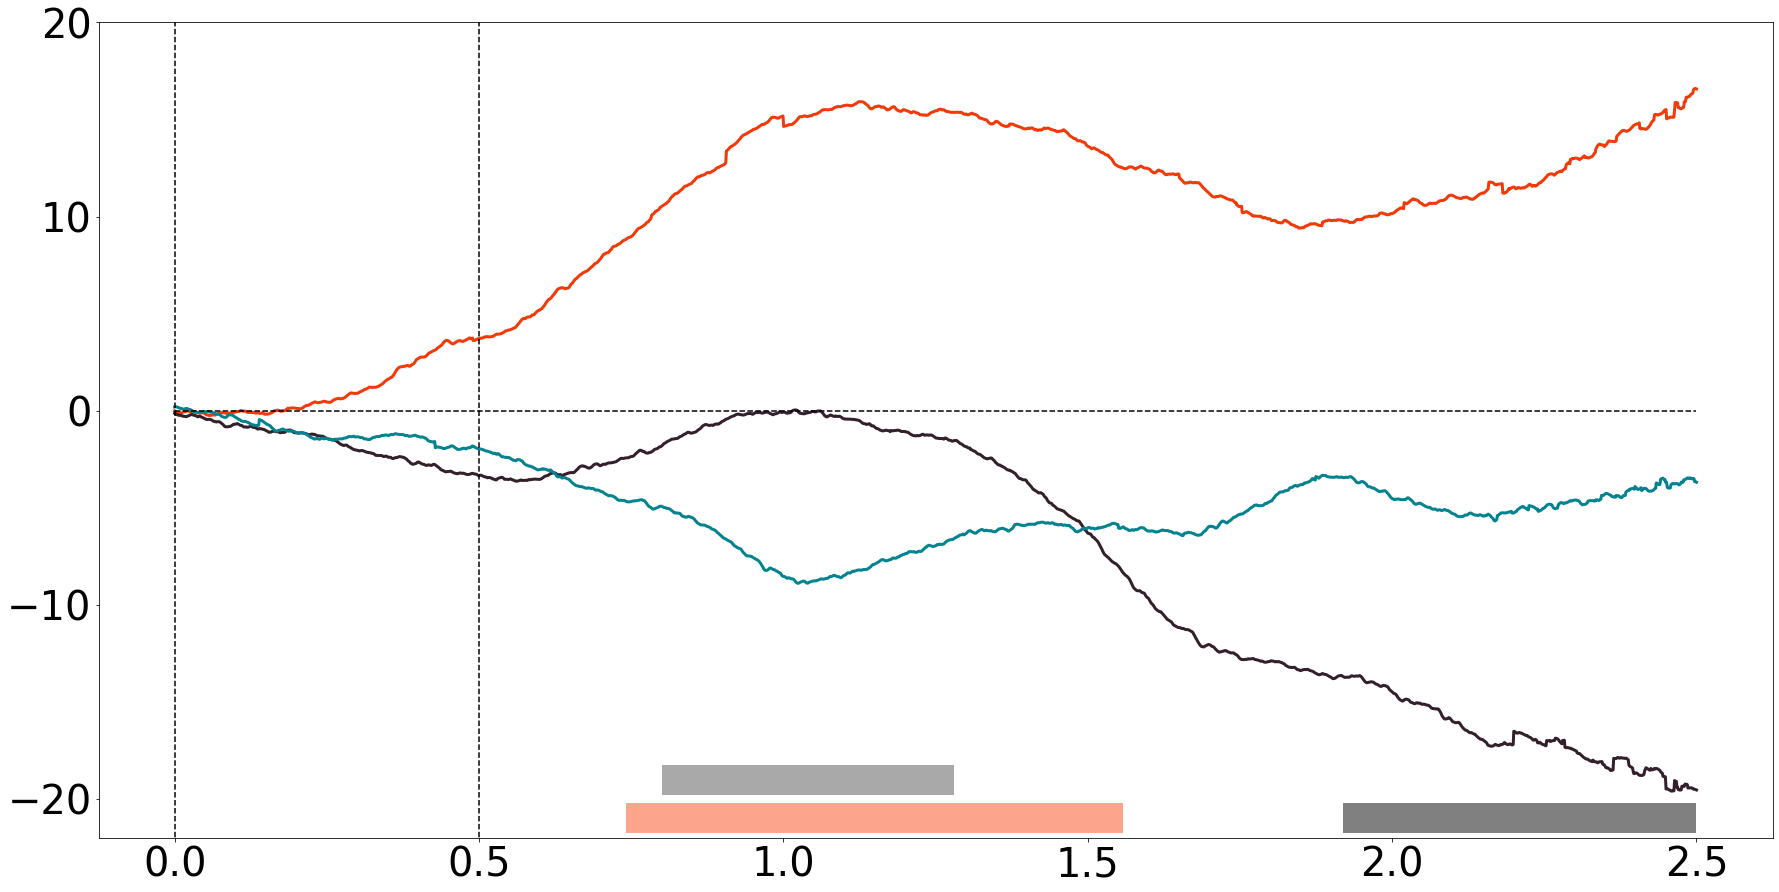

In [254]:
fs(30,15)
cDict = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#33202a'}
fig,ax= plt.subplots(nrows= 1)
x = np.linspace(0,2.5,normmean.shape[1])

for f in normmean.index.get_level_values('cue_blk_validity').unique():
    diff = normmean.loc[f,'dar'] - normmean.loc[f,'bri']
    plt.plot(x,diff,color = cDict[f],label = f,linewidth = 3)

plt.vlines(epoch_array[2:-2]-0.75,-30,30,
           linestyles = 'dashed',colors= 'black')
plt.hlines(0,0,epoch_array[-2]-0.75,linestyles = 'dashed',colors= 'black')
plt.hlines(-21,x[highSig[0][0]],x[highSig[0][-1]],colors = cList[0],
           linewidth = 30)
plt.hlines(-21,1.92,2.5,colors = 'grey',
           linewidth = 30)
plt.hlines(-19,0.8,1.28,colors = 'darkgray',
           linewidth = 30)


plt.ylim(-22,20)
#plt.title('Pupillary memory effect',size = 40)
#plt.legend(prop={'size': 20},loc=3,)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

plt.tick_params(labelsize = 40)
plt.show()

# pupil vviq

## vviq dist

In [19]:
vviq = pd.read_csv('Z:/LiteBrite_YueyingDong/temp/vviq.csv')[['id','vviq']].reset_index(drop = True).iloc[2:,:].reset_index(drop = True).astype(float)

In [21]:
vviq.shape

(49, 2)

In [22]:
vviq.describe()

,id,vviq
count,49.000000,49.000000
mean,172.530612,54.408163
std,14.726821,12.392737
min,148.000000,16.000000
25%,160.000000,47.000000
50%,173.000000,56.000000
75%,185.000000,62.000000
max,197.000000,76.000000


(0.0, 80.0)

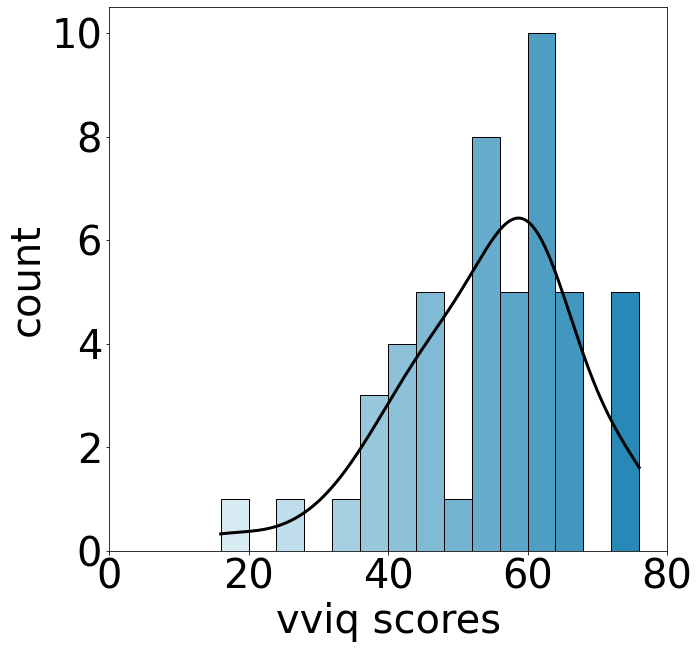

In [22]:
fs(10,10)
colors = [ '#d8ebf2','#2889b7',] # first color is light blue, last is dark blue
binNum = 15
ax = sns.histplot(x = 'vviq', kde = True, data = vviq,
    line_kws=dict(linewidth=3,color = 'black'),linewidth = 1,bins = binNum,color = 'black')

#create the colored bins
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=binNum)
[p.set(color = cm(n),linewidth = 1,edgecolor = 'black') for n,p in enumerate(ax.patches)]


#plt.title('vviq scores histogram',size = 40)
plt.xlabel('vviq scores',size = 40)
plt.ylabel('count',size = 40)
plt.tick_params( labelsize=40)
plt.xlim(0,80)

In [24]:
vviqCutOff = np.percentile(vviq.vviq,[33,67])
vviqhigh = vviq[vviq.vviq >= vviqCutOff[1]].id.astype(float)
vviqlow = vviq[vviq.vviq <= vviqCutOff[0]].id.astype(float)
vviqmed = vviq[(vviq.vviq > vviqCutOff[0])&(vviq.vviq < vviqCutOff[1])].id.astype(float)
len(vviqlow),len(vviqmed),len(vviqhigh)

(16, 16, 17)

## vviq 1/3 split, pupil

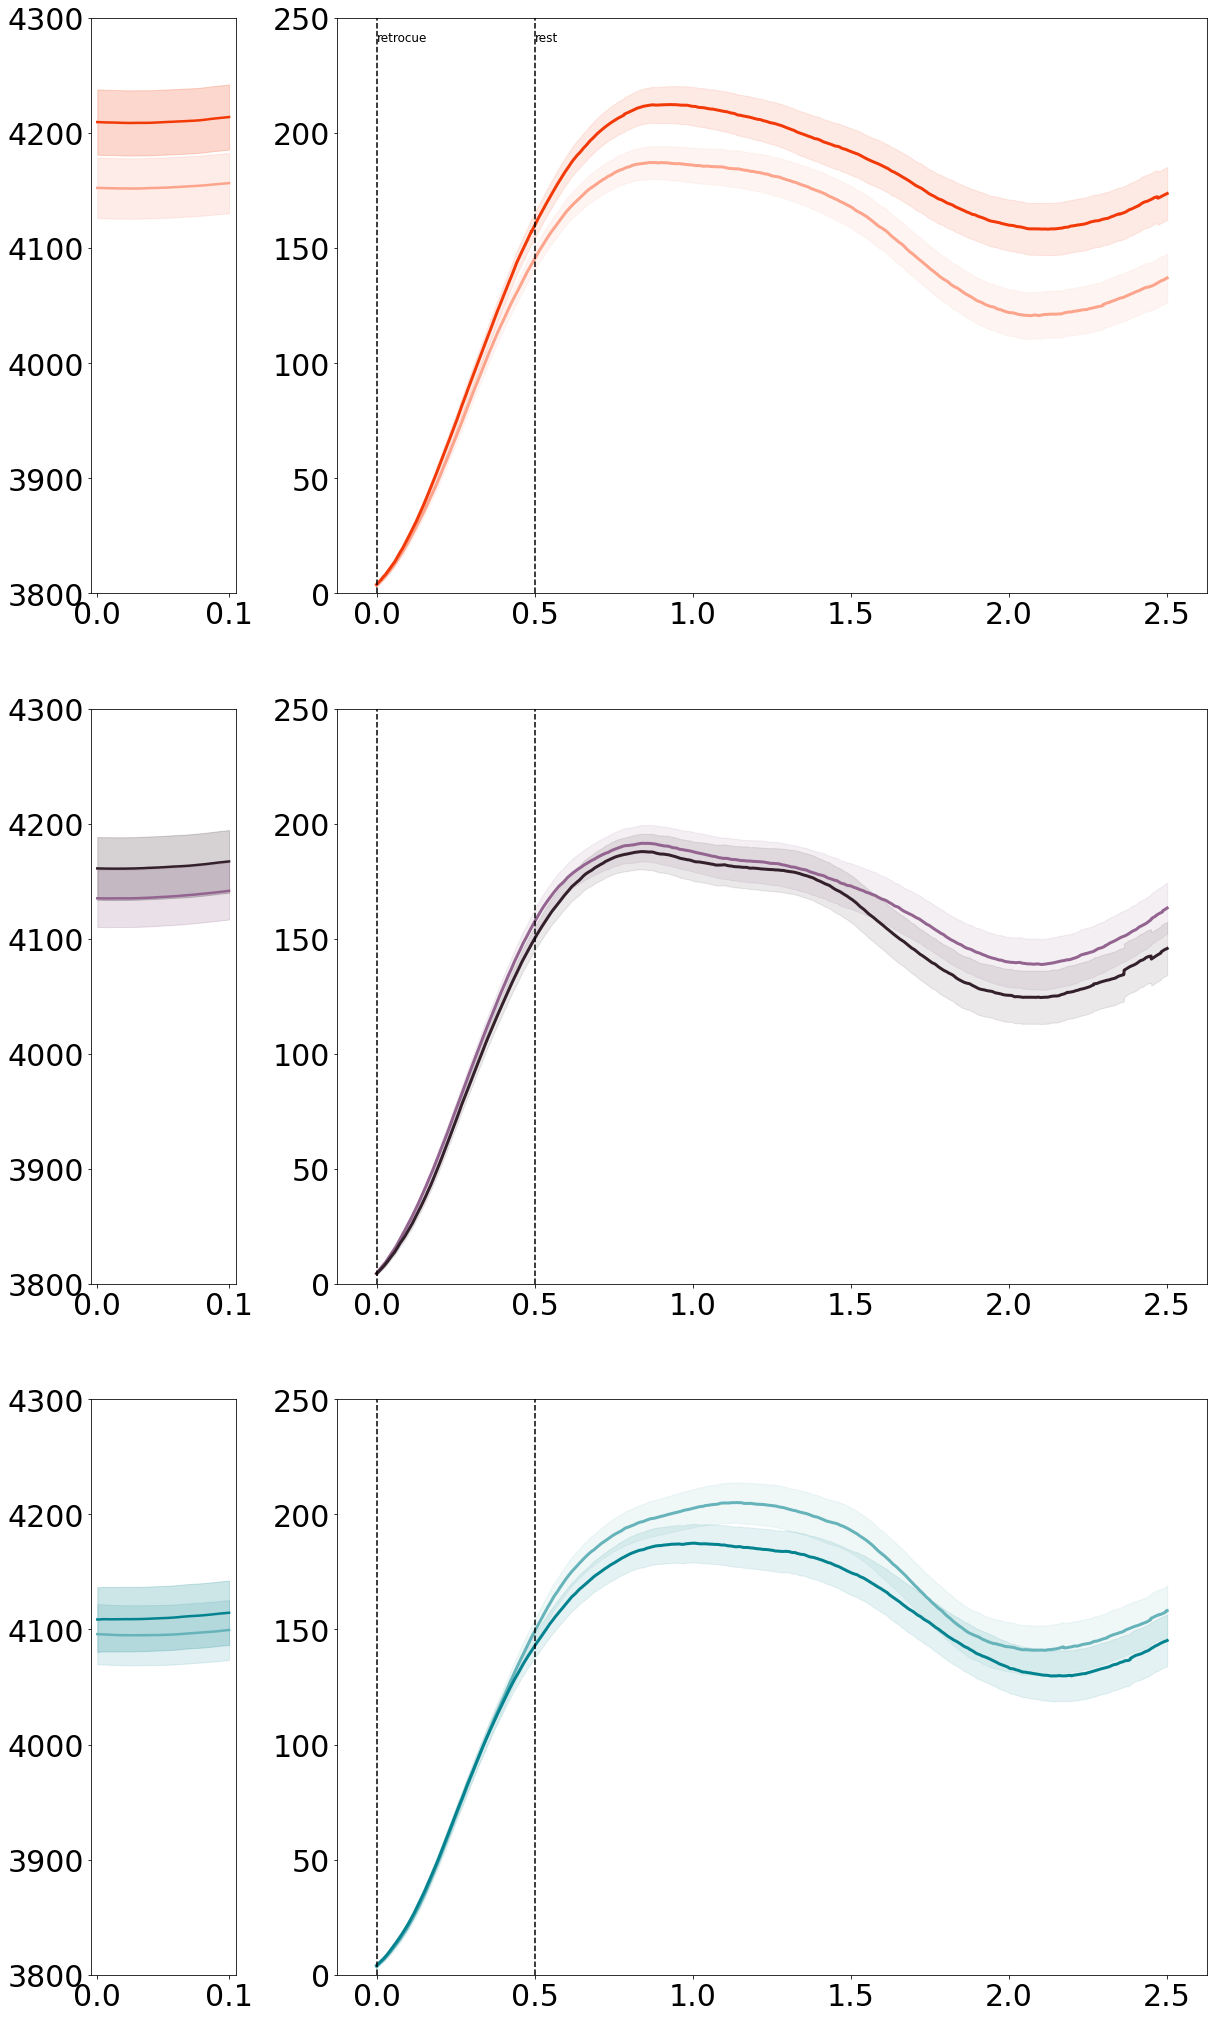

In [25]:
#grand - retro; high vviq subj
normmean, norm_sterr = pupilPlot(normPup = retroEpo[retroEpo.subj.isin(vviqhigh)].reset_index(drop = True),
                                 blPup = retroEpoBL[retroEpoBL.subj.isin(vviqhigh)].iloc[:,:-1].reset_index(drop = True),
          eventt = 2.5,levels=['cue_blk_validity', 'cued_item'],
          blt  = 0.1,cList = cList,pltRatio = [0.5,3],blHeight = [3800,4300],mainFigHeight = [0,250],
          eventBoundary = epoch_array[2:-2]-0.75,
          eventName = epoch_name[2:-2],figW = 20,figH = 12,tickSize=30,
          tightPlot=False)

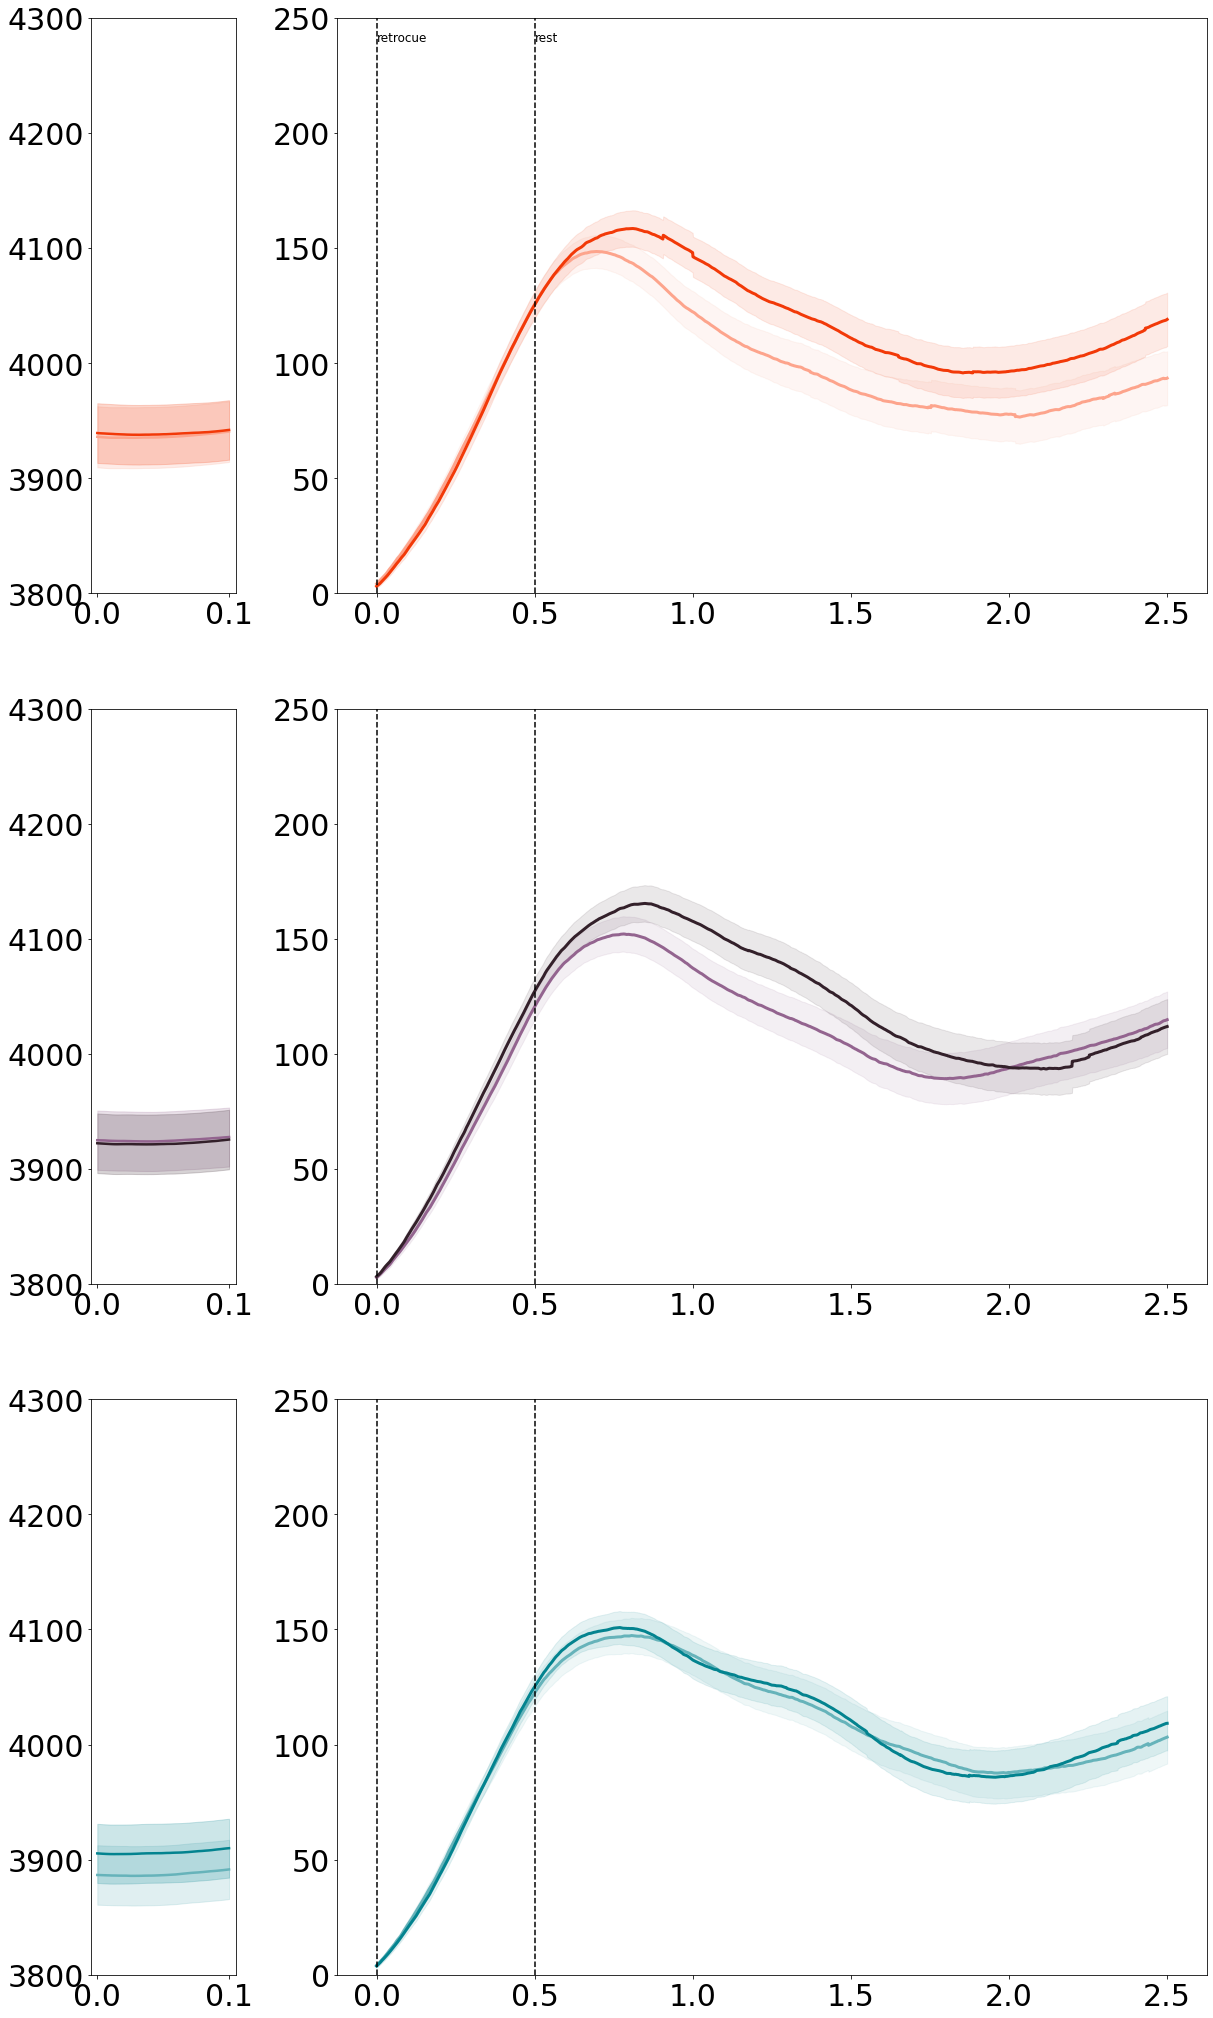

In [26]:
#grand - retro
normmean, norm_sterr = pupilPlot(normPup = retroEpo[retroEpo.subj.isin(vviqmed)].reset_index(drop = True),
                                 blPup = retroEpoBL[retroEpoBL.subj.isin(vviqmed)].iloc[:,:-1].reset_index(drop = True),
          eventt = 2.5,levels=['cue_blk_validity', 'cued_item'],
          blt  = 0.1,cList = cList,pltRatio = [0.5,3],blHeight = [3800,4300],mainFigHeight = [0,250],
          eventBoundary = epoch_array[2:-2]-0.75,
          eventName = epoch_name[2:-2],figW = 20,figH = 12,tickSize=30,
          tightPlot=False)

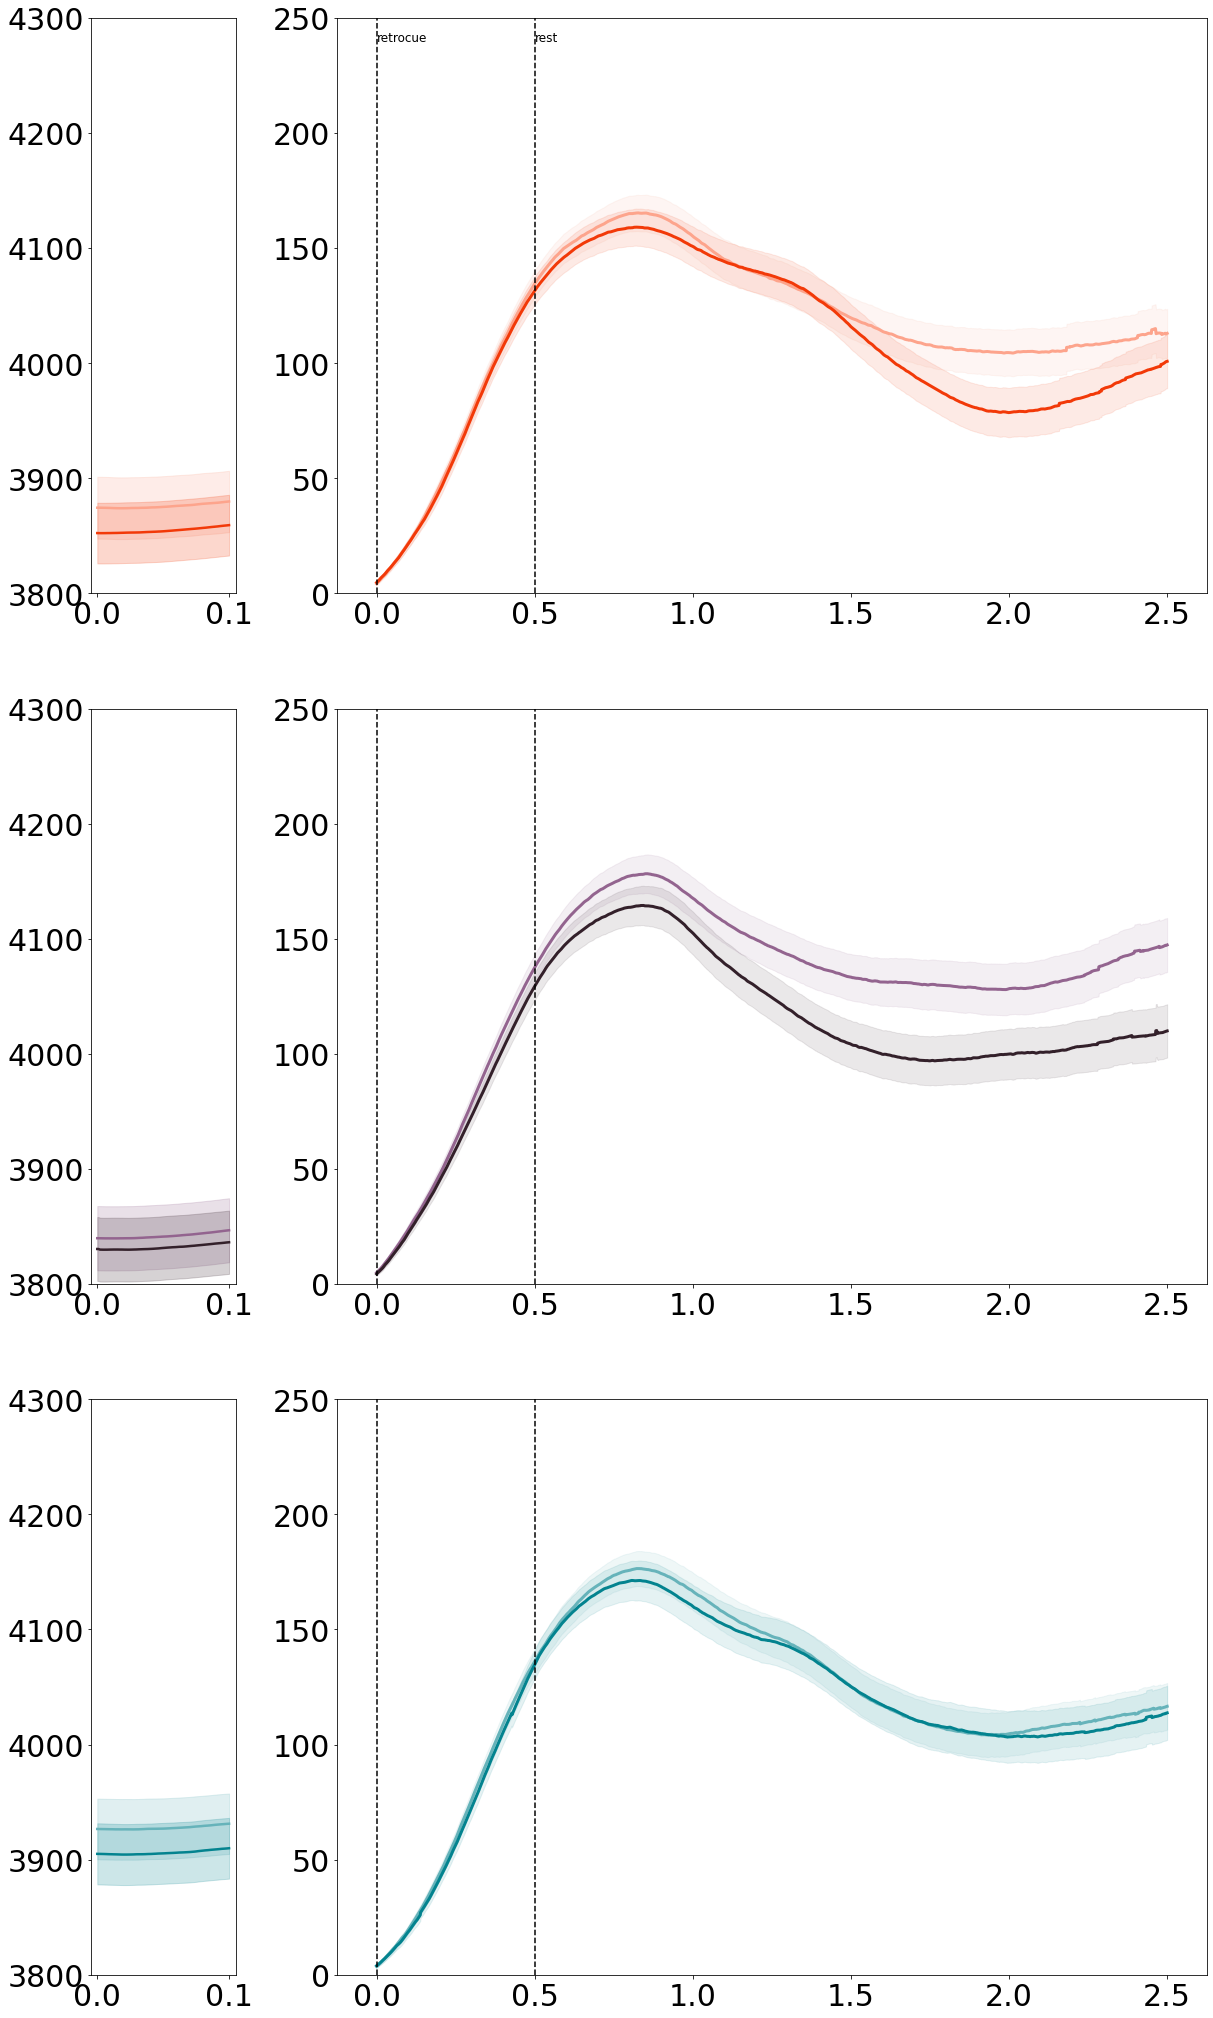

In [27]:
#grand - retro
normmean, norm_sterr = pupilPlot(normPup = retroEpo[retroEpo.subj.isin(vviqlow)].reset_index(drop = True),
                                 blPup = retroEpoBL[retroEpoBL.subj.isin(vviqlow)].iloc[:,:-1].reset_index(drop = True),
          eventt = 2.5,levels=['cue_blk_validity', 'cued_item'],
          blt  = 0.1,cList = cList,pltRatio = [0.5,3],blHeight = [3800,4300],mainFigHeight = [0,250],
          eventBoundary = epoch_array[2:-2]-0.75,
          eventName = epoch_name[2:-2],figW = 20,figH = 12,tickSize=30,
          tightPlot=False)

## vviq continuous

### vviq and aggregated pupil mean

In [28]:
dataN1= int(0.75*1000)
dataN2= int(1.5*1000)

In [29]:
#create a df with the mean pupil for each subj, for  trl conditions
vviqPupMean = retroEpo.groupby(['subj','cued_item']).mean().iloc[:,dataN1:dataN2].mean(axis = 1).reset_index()
vviqPupMean.rename(columns = {0:'meanPup_750to1500'},inplace = True)
vviqPupMean = vviqPupMean.merge(vviq,left_on = 'subj',right_on = 'id').drop(columns = 'id')

#get the psychosensoryPLR
tempDiff = pd.concat([vviqPupMean.loc[::2,['subj','vviq']].reset_index(drop = True),
    vviqPupMean.loc[1::2,'meanPup_750to1500'].reset_index(drop = True) - vviqPupMean.loc[::2,'meanPup_750to1500'].reset_index(drop = True)],axis = 1)

Text(0.5, 1.0, 'Vviq v.s. Psychosensory PLR magnitude')

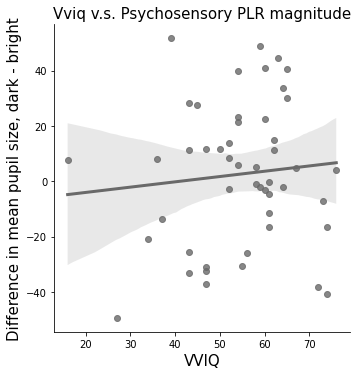

In [30]:
sns.lmplot(x = 'vviq',y = 'meanPup_750to1500',line_kws = dict(linewidth=3,color = 'dimgray'),
            scatter_kws = dict(color = 'dimgray'),
            data = tempDiff)

plt.xlabel('VVIQ',size = 15)
plt.ylabel('Difference in mean pupil size, dark - bright',size = 15)
plt.title('Vviq v.s. Psychosensory PLR magnitude',size = 15)


### vviq and pupil mean over block conditions

In [31]:
data1 = int(0.5*1000)
data2 = int(2.5*1000)

In [32]:
#create a df with the mean pupil for each subj, for  trl conditions & block
vviqPupMean = retroEpo.groupby(['subj','cue_blk_validity','cued_item']).mean().iloc[:,data1:data2].mean(axis = 1).reset_index()
vviqPupMean.rename(columns = {0:'meanPup_delay'},inplace = True)
vviqPupMean = vviqPupMean.merge(vviq,left_on = 'subj',right_on = 'id').drop(columns = 'id')

tempDiff_blk = pd.concat([vviqPupMean.loc[::2,['subj','cue_blk_validity','vviq']].reset_index(drop = True),
    vviqPupMean.loc[1::2,'meanPup_delay'].reset_index(drop = True) - vviqPupMean.loc[::2,'meanPup_delay'].reset_index(drop = True)],axis = 1)

In [33]:
tempDiff_blk

,subj,cue_blk_validity,vviq,meanPup_delay
0,148.0,['high'],54.0,-4.061860
1,148.0,['low'],54.0,17.950737
2,148.0,['medium'],54.0,15.981463
3,149.0,['high'],52.0,16.965191
4,149.0,['low'],52.0,-34.706918
...,...,...,...,...
142,196.0,['low'],54.0,13.790104
143,196.0,['medium'],54.0,0.923313
144,197.0,['high'],43.0,-43.327269
145,197.0,['low'],43.0,-22.495096


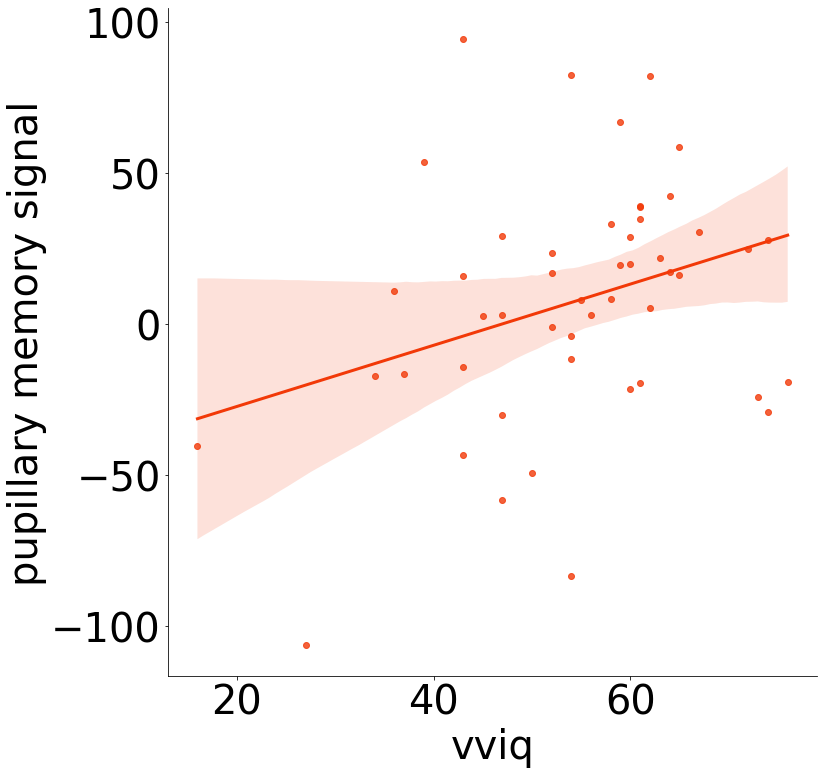

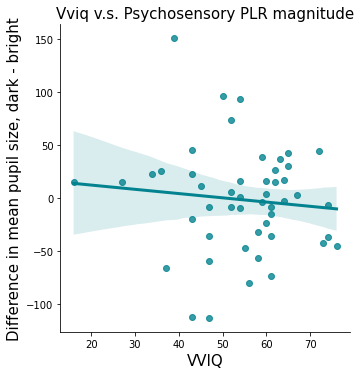

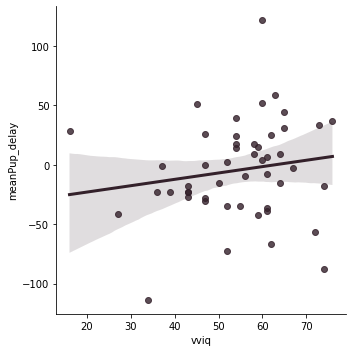

In [34]:
#for plotting, I set the label of the block column
tempDiff_blk.rename(columns = {'cue_blk_validity':'blockReliabilty'},inplace = True)

sns.lmplot(x = 'vviq',y = 'meanPup_delay',
                scatter_kws = dict(color = cList[1]),line_kws = dict(linewidth=3,color = cList[1]),
                data = tempDiff_blk[tempDiff_blk.blockReliabilty == "['high']"],height = 10,aspect = 1)
plt.xlabel('vviq',fontsize = 40)
plt.ylabel('pupillary memory signal',fontsize = 40)
plt.tick_params(labelsize = 40)

sns.lmplot(x = 'vviq',y = 'meanPup_delay',
                scatter_kws = dict(color = cList[5]),line_kws = dict(linewidth=3,color = cList[5]),
                data = tempDiff_blk[tempDiff_blk.blockReliabilty == "['medium']"],)


plt.xlabel('VVIQ',size = 15)
plt.ylabel('Difference in mean pupil size, dark - bright',size = 15)
plt.title('Vviq v.s. Psychosensory PLR magnitude',size = 15)
sns.lmplot(x = 'vviq',y = 'meanPup_delay',
                scatter_kws = dict(color = cList[3]),line_kws = dict(linewidth=3,color = cList[3]),
                data = tempDiff_blk[tempDiff_blk.blockReliabilty == "['low']"],)




#fig.tight_layout()

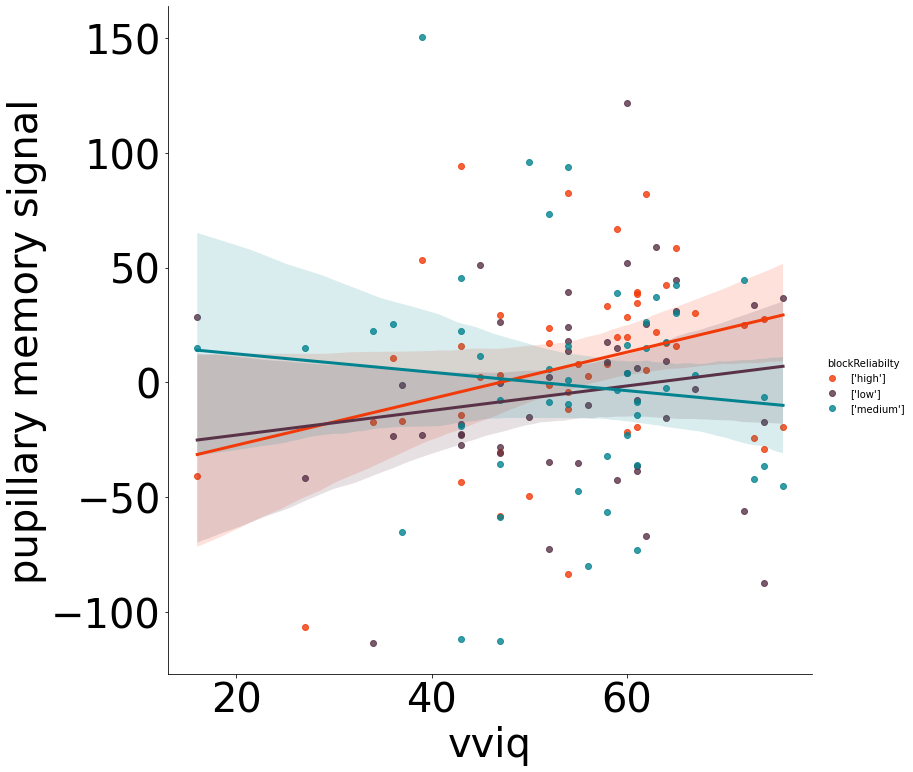

In [35]:
sns.lmplot(x = 'vviq',y = 'meanPup_delay',hue = 'blockReliabilty',palette=['#f23908',  '#593247','#03838f',],
                line_kws = dict(linewidth=3),
                data = tempDiff_blk,height = 10,aspect = 1)
plt.xlabel('vviq',fontsize = 40)
plt.ylabel('pupillary memory signal',fontsize = 40)
plt.tick_params(labelsize = 40)

In [36]:
tempDiff_blk['blockReliabilty'] = [ast.literal_eval(i)[0] for i in tempDiff_blk['blockReliabilty']]

In [37]:
model = smf.mixedlm("meanPup_delay ~  vviq + C(blockReliabilty,) + vviq:C(blockReliabilty,)",
                   re_formula='1+C(blockReliabilty,)',
                    data=tempDiff_blk,
                    groups= "subj").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Mixed Linear Model Regression Results
===============================================================================================================
Model:                              MixedLM                  Dependent Variable:                  meanPup_delay
No. Observations:                   147                      Method:                              REML         
No. Groups:                         49                       Scale:                               1266.0113    
Min. group size:                    3                        Log-Likelihood:                      -749.3920    
Max. group size:                    3                        Converged:                           Yes          
Mean group size:                    3.0                                                                        
---------------------------------------------------------------------------------------------------------------
                                                                  Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                                         -47.616   24.970 -1.907 0.057 -96.556   1.325
C(blockReliabilty, )[T.low]                                        13.956   37.883  0.368 0.713 -60.293  88.205
C(blockReliabilty, )[T.medium]                                     68.076   39.978  1.703 0.089 -10.280 146.432
vviq                                                                1.013    0.448  2.263 0.024   0.136   1.891
vviq:C(blockReliabilty, )[T.low]                                   -0.478    0.679 -0.703 0.482  -1.809   0.854
vviq:C(blockReliabilty, )[T.medium]                                -1.414    0.717 -1.972 0.049  -2.819  -0.009
subj Var                                                          211.580                                      
subj x C(blockReliabilty, )[T.low] Cov                           -326.779                                      
C(blockReliabilty, )[T.low] Var                                   868.955                                      
subj x C(blockReliabilty, )[T.medium] Cov                        -103.220                                      
C(blockReliabilty, )[T.low] x C(blockReliabilty, )[T.medium] Cov  190.728                                      
C(blockReliabilty, )[T.medium] Var                               1255.583                                      
===============================================================================================================

"""

# vviq vs behav

In [62]:
#readin exp1 files, merge with exp2
psyFull_pl = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper_Pl/cleanBehav_Pl.csv').iloc[:,1:]
plSubj = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper_Pl/cleanPup_parsedByIndex/cleanPup_retrocue2Probe.csv').iloc[:,1:].participant.unique()
psyFull_pl = psyFull_pl[psyFull_pl.participant.isin(plSubj)].reset_index(drop = True)
vviq_pl = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper_Pl/vviqPupilLab.csv')[['id','vviq']].reset_index(drop = True).astype(float)
vviq_elpl = pd.concat([vviq,vviq_pl]).reset_index(drop = True)

relcols = ['participant','blk_validity','cue_condition','abs_distance_to_probed_item']
psyFull_plel = pd.concat([psyFull[relcols],psyFull_pl[relcols]]).reset_index(drop = True)

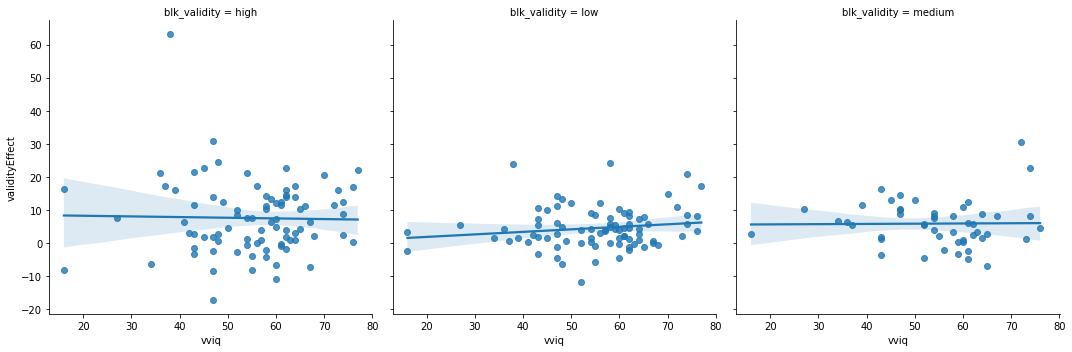

In [23]:
#merge the psychopy and the vviq
subjErr = psyFull_plel[['participant','blk_validity','cue_condition','abs_distance_to_probed_item']].groupby(['participant','blk_validity','cue_condition']).mean().reset_index()
errVVIQSubj = subjErr.merge(vviq_elpl,how = 'left',left_on = 'participant',right_on='id')

#calculate the validity effect for every subj
validityEffect = errVVIQSubj.iloc[::2].abs_distance_to_probed_item.values - errVVIQSubj.iloc[1::2].abs_distance_to_probed_item.values
validityEffect = pd.concat([errVVIQSubj.iloc[::2].reset_index(drop = True),pd.DataFrame(validityEffect)],axis = 1)
validityEffect.rename(columns={0: 'validityEffect'},inplace=True)

#plot
sns.lmplot(x = 'vviq',y = 'validityEffect',
           col = 'blk_validity',data = validityEffect)

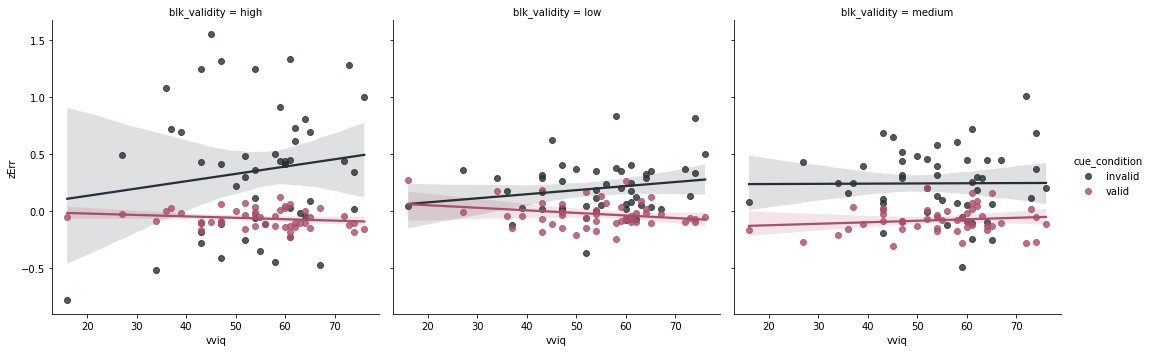

In [24]:
#zscore the error for each subj, then calculate their mean for the block reliability x cue validity 
q = psyFull[['participant','abs_distance_to_probed_item']].pivot(columns = 'participant',values='abs_distance_to_probed_item').apply(lambda x: stats.zscore(x,nan_policy = 'omit'))
q = q.sum(axis = 1)#_plel
subjErrZ = pd.concat([psyFull[['participant','blk_validity','cue_condition','abs_distance_to_probed_item']],q],axis = 1)#_plel
subjErrZ_blkCue = subjErrZ.groupby(['participant','blk_validity','cue_condition']).mean().reset_index().rename(columns={0: 'zErr'},inplace=False)
subjErrZ_blkCue = subjErrZ_blkCue.merge(vviq_elpl,how = 'left',left_on = 'participant',right_on='id')

sns.lmplot(x = 'vviq',y = 'zErr',hue = 'cue_condition',palette=['#292F36','#AB4E68'],
           col = 'blk_validity',data = subjErrZ_blkCue)


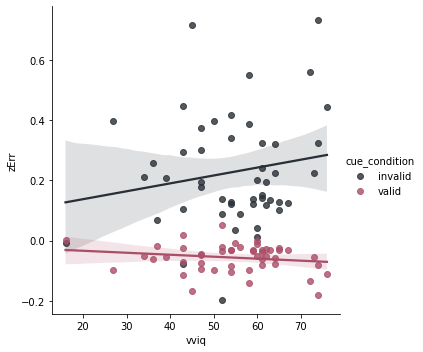

In [26]:
subjErrZ_cue = subjErrZ.groupby(['participant','cue_condition']).mean().reset_index().rename(columns={0: 'zErr'},inplace=False).merge(vviq_elpl,how = 'left',left_on = 'participant',right_on='id')
sns.lmplot(x = 'vviq',y = 'zErr',hue = 'cue_condition',palette=['#292F36','#AB4E68'],data = subjErrZ_cue)

In [27]:
validityEffect = subjErrZ_cue.iloc[::2].zErr.values - subjErrZ_cue.iloc[1::2].zErr.values
validityEffect = pd.concat([subjErrZ_cue.iloc[::2].reset_index(drop = True),pd.DataFrame(validityEffect)],axis = 1)
validityEffect.rename(columns={0: 'validityEffect'},inplace=True)

In [28]:
validityEffect_exp1 = validityEffect.copy()

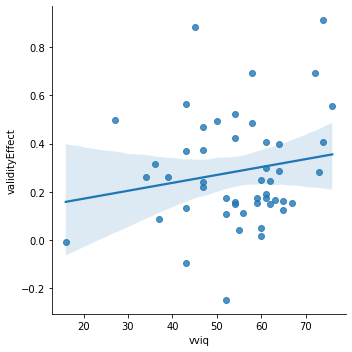

In [29]:
sns.lmplot(x = 'vviq',y = 'validityEffect',data = validityEffect)

In [30]:
pg.anova(data = validityEffect,dv = 'validityEffect',between = 'vviq',effsize = 'np2')

,Source,ddof1,ddof2,F,p-unc,np2
0,vviq,26,22,2.141678,0.036828,0.7168


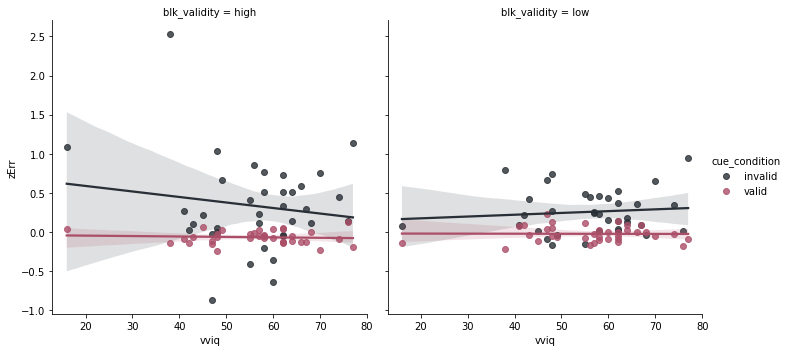

In [31]:
#zscore the error for each subj, then calculate their mean for the block reliability x cue validity 
q = psyFull_pl[['participant','abs_distance_to_probed_item']].pivot(columns = 'participant',values='abs_distance_to_probed_item').apply(lambda x: stats.zscore(x,nan_policy = 'omit'))
q = q.sum(axis = 1)#_plel
subjErrZ = pd.concat([psyFull_pl[['participant','blk_validity','cue_condition','abs_distance_to_probed_item']],q],axis = 1)#_plel
subjErrZ_blkCue = subjErrZ.groupby(['participant','blk_validity','cue_condition']).mean().reset_index().rename(columns={0: 'zErr'},inplace=False)
subjErrZ_blkCue = subjErrZ_blkCue.merge(vviq_elpl,how = 'left',left_on = 'participant',right_on='id')

sns.lmplot(x = 'vviq',y = 'zErr',hue = 'cue_condition',palette=['#292F36','#AB4E68'],
           col = 'blk_validity',data = subjErrZ_blkCue)


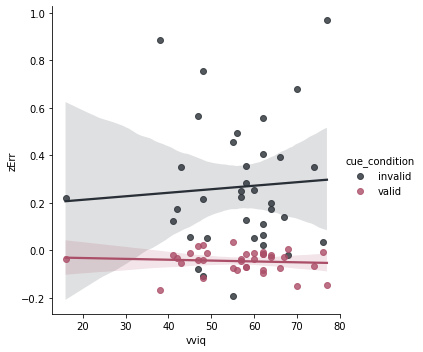

In [32]:
subjErrZ_cue = subjErrZ.groupby(['participant','cue_condition']).mean().reset_index().rename(columns={0: 'zErr'},inplace=False).merge(vviq_elpl,how = 'left',left_on = 'participant',right_on='id')
sns.lmplot(x = 'vviq',y = 'zErr',hue = 'cue_condition',palette=['#292F36','#AB4E68'],data = subjErrZ_cue)

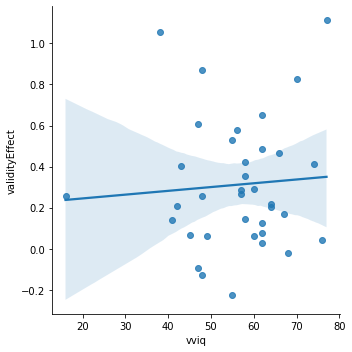

In [33]:
validityEffect = subjErrZ_cue.iloc[::2].zErr.values - subjErrZ_cue.iloc[1::2].zErr.values
validityEffect = pd.concat([subjErrZ_cue.iloc[::2].reset_index(drop = True),pd.DataFrame(validityEffect)],axis = 1)
validityEffect.rename(columns={0: 'validityEffect'},inplace=True)
sns.lmplot(x = 'vviq',y = 'validityEffect',data = validityEffect)

In [34]:
pg.anova(data = validityEffect,dv = 'validityEffect',between = 'vviq',effsize = 'np2')

,Source,ddof1,ddof2,F,p-unc,np2
0,vviq,22,13,0.856326,0.638181,0.591698


In [35]:
validityEffect['exp'] = '1'
validityEffect_exp1['exp'] = '2'

In [36]:
validityEffect = pd.concat([validityEffect,validityEffect_exp1],axis = 0).reset_index(drop = True)

In [37]:
stats.pearsonr(validityEffect.validityEffect,validityEffect.vviq)

(0.1255909201059474, 0.2520897220506842)

In [38]:
mdl = smf.ols('validityEffect~ vviq + exp + vviq * exp',data = validityEffect).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         validityEffect   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.5099
Date:                Mon, 30 Oct 2023   Prob (F-statistic):              0.677
Time:                        11:29:45   Log-Likelihood:                -7.5737
No. Observations:                  85   AIC:                             23.15
Df Residuals:                      81   BIC:                             32.92
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2081      0.217      0.957      0.342      -0.225       0.641
exp[T.2]         -0.1023      0.280     -0.366      0.715      -0.659       0.454
vviq              0.0018      0.004      0.487      0.628      -0.006       0.009
vviq:exp[T.2]     0.0014      0.005      0.292      0.771      -0.008       0.011
==============================================================================
Omnibus:                       10.091   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                9.992
Skew:                           0.769   Prob(JB):                      0.00676
Kurtosis:                       3.674   Cond. No.                         759.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
#zscore the error for each subj, then calculate their mean for the block reliability x cue validity 
q = psyFull_plel[['participant','abs_distance_to_probed_item']].pivot(columns = 'participant',values='abs_distance_to_probed_item').apply(lambda x: stats.zscore(x,nan_policy = 'omit'))
q = q.sum(axis = 1)
subjErrZ = pd.concat([psyFull_plel[['participant','blk_validity','cue_condition','abs_distance_to_probed_item']],q],axis = 1)
subjErrZ_blkCue = subjErrZ.groupby(['participant','blk_validity','cue_condition']).mean().reset_index().rename(columns={0: 'zErr'},inplace=False)
subjErrZ_blkCue = subjErrZ_blkCue.merge(vviq_elpl,how = 'left',left_on = 'participant',right_on='id')

In [69]:
subjErrZ_blkCue['exp'] = np.where(subjErrZ_blkCue.participant < 148,'1','2')

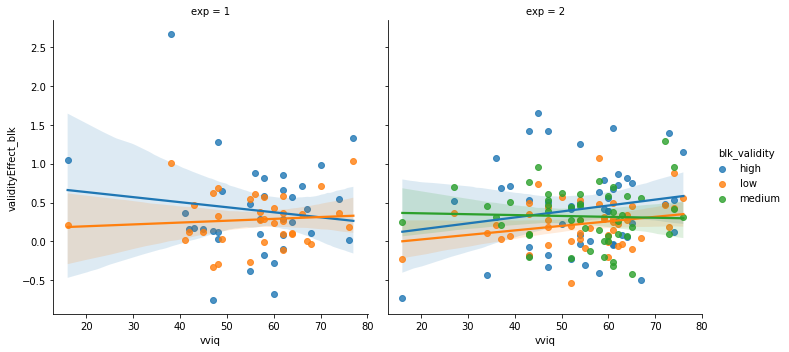

In [71]:
validityEffect_blk = subjErrZ_blkCue.iloc[::2].zErr.values - subjErrZ_blkCue.iloc[1::2].zErr.values
validityEffect_blk = pd.concat([subjErrZ_blkCue.iloc[::2].reset_index(drop = True),pd.DataFrame(validityEffect_blk)],axis = 1)
validityEffect_blk.rename(columns={0: 'validityEffect_blk'},inplace=True)
sns.lmplot(x = 'vviq',y = 'validityEffect_blk',hue = 'blk_validity',col = 'exp',data = validityEffect_blk)

In [73]:
validityEffect_blk

,participant,blk_validity,cue_condition,abs_distance_to_probed_item,zErr,id,vviq,exp,validityEffect_blk
0,101.0,high,invalid,18.000000,-0.042598,101.0,62.0,1,-0.099846
1,101.0,low,invalid,21.125000,0.135699,101.0,62.0,1,0.262027
2,102.0,high,invalid,40.000000,1.038827,102.0,48.0,1,1.278657
3,102.0,low,invalid,34.172414,0.736069,102.0,48.0,1,0.685533
4,104.0,high,invalid,40.500000,0.511714,104.0,64.0,1,0.567615
...,...,...,...,...,...,...,...,...,...
214,196.0,low,invalid,17.600000,0.006021,196.0,54.0,2,0.026719
215,196.0,medium,invalid,24.105263,0.397714,196.0,54.0,2,0.451279
216,197.0,high,invalid,33.800000,0.433593,197.0,43.0,2,0.532903
217,197.0,low,invalid,31.285714,0.316219,197.0,43.0,2,0.494026


In [90]:
exp1Temp = validityEffect_blk[validityEffect_blk.exp == '1'].reset_index(drop = True)
exp2Temp = validityEffect_blk[validityEffect_blk.exp == '2'].reset_index(drop = True)

In [91]:
model = smf.mixedlm("validityEffect_blk ~  vviq + C(blk_validity,) + vviq:C(blk_validity,)",
                   re_formula='1+C(blk_validity,) ',
                    data=exp1Temp,
                    groups= "participant").fit()

model.summary()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
=====================================================================================
Model:                   MixedLM        Dependent Variable:        validityEffect_blk
No. Observations:        72             Method:                    REML              
No. Groups:              36             Scale:                     0.0643            
Min. group size:         2              Log-Likelihood:            -50.0259          
Max. group size:         2              Converged:                 No                
Mean group size:         2.0                                                         
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                   0.765    0.472  1.622 0.105 -0.160  1.689
C(blk_validity, )[T.low]                   -0.617    0.418 -1.478 0.139 -1.436  0.201
vviq                                       -0.006    0.008 -0.791 0.429 -0.023  0.010
vviq:C(blk_validity, )[T.low]               0.009    0.007  1.220 0.223 -0.005  0.023
participant Var                             0.281                                    
participant x C(blk_validity, )[T.low] Cov -0.184                                    
C(blk_validity, )[T.low] Var                0.142                                    
=====================================================================================

"""

In [92]:
model = smf.mixedlm("validityEffect_blk ~  vviq + C(blk_validity,) + vviq:C(blk_validity,)",
                   re_formula='1+C(blk_validity,) ',
                    data=exp2Temp,
                    groups= "participant").fit()

model.summary()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Mixed Linear Model Regression Results
=====================================================================================================
Model:                         MixedLM             Dependent Variable:             validityEffect_blk
No. Observations:              147                 Method:                         REML              
No. Groups:                    49                  Scale:                          0.1012            
Min. group size:               3                   Log-Likelihood:                 -86.5787          
Max. group size:               3                   Converged:                      No                
Mean group size:               3.0                                                                   
-----------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept                                                   0.002    0.318  0.006 0.995 -0.621  0.624
C(blk_validity, )[T.low]                                   -0.093    0.337 -0.277 0.781 -0.754  0.567
C(blk_validity, )[T.medium]                                 0.382    0.392  0.976 0.329 -0.386  1.151
vviq                                                        0.008    0.006  1.345 0.179 -0.004  0.019
vviq:C(blk_validity, )[T.low]                              -0.002    0.006 -0.304 0.761 -0.014  0.010
vviq:C(blk_validity, )[T.medium]                           -0.009    0.007 -1.252 0.211 -0.023  0.005
participant Var                                             0.138    0.139                           
participant x C(blk_validity, )[T.low] Cov                 -0.095    0.130                           
C(blk_validity, )[T.low] Var                                0.067    0.015                           
participant x C(blk_validity, )[T.medium] Cov              -0.132    0.151                           
C(blk_validity, )[T.low] x C(blk_validity, )[T.medium] Cov  0.086    0.171                           
C(blk_validity, )[T.medium] Var                             0.162    0.168                           
=====================================================================================================

"""

Text(34.90980902777778, 0.5, 'subj avg err, invalid - valid')

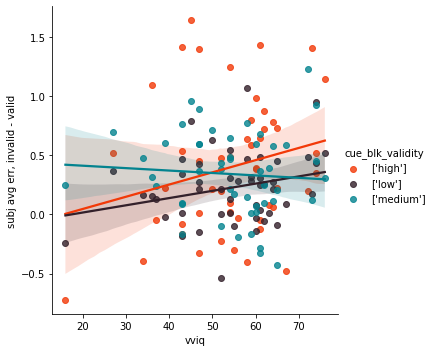

In [ ]:
tempDiff2 = pd.concat([temp.loc[::2,['cue_blk_validity','subj','auc','vviq']].reset_index(drop = True),
    temp.loc[::2,'zscoredErr'].reset_index(drop = True) - temp.loc[1::2,'zscoredErr'].reset_index(drop = True)],axis = 1)
sns.lmplot(x = 'vviq',y = 'zscoredErr',hue = 'cue_blk_validity',palette = cList[1::2],data = tempDiff2)
plt.ylabel('subj avg err, invalid - valid')

In [ ]:
tempAggDiff2 = pd.concat([tempAgg.loc[::2,['subj','vviq']].reset_index(drop = True),
    tempAgg.loc[::2,'zscoredErr'].reset_index(drop = True) - tempAgg.loc[1::2,'zscoredErr'].reset_index(drop = True)],axis = 1)

Text(12.425000000000011, 0.5, 'subj avg err, invalid - valid')

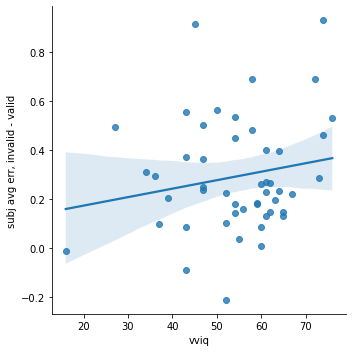

In [ ]:
sns.lmplot(x = 'vviq',y = 'zscoredErr',data = tempAggDiff2)
plt.ylabel('subj avg err, invalid - valid')

In [ ]:
#mixed anova on the beh Diff, vviq as between, block validity as within subject predictors
pg.mixed_anova(data=tempDiff2, dv='zscoredErr', between = 'vviq',subject='subj',
            within='cue_blk_validity', )

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,vviq,6.806382,26,22,0.261784,1.535723,0.155062,NaN,0.644753,NaN,NaN,NaN,NaN
1,cue_blk_validity,0.778192,2,44,0.389096,2.257730,0.116572,0.115131,0.093073,0.727384,False,0.62521,0.000016
2,Interaction,8.115806,52,44,0.156073,0.905616,0.636427,NaN,0.516972,NaN,NaN,NaN,NaN


# 200hz

In [224]:
retroEpo200Hz = retroEpo.iloc[:,:2500].groupby(np.arange(2500)//5,axis = 1).mean()
retroEpo200Hz = pd.concat([retroEpo200Hz,retroEpo.iloc[:,-5:]],axis = 1)

In [235]:
retroEpo200Hz.to_csv('cleanPupRetroNorm_byEvents200Hz.csv')

# behavior plots

In [20]:
psyFull.shape

(14310, 205)

In [21]:
#get the aveage rt and response error
rtSubj = psyFull.groupby(['blk_validity','cue_condition','participant']).rt.mean().reset_index(drop = False)
memoryErrorSubj = psyFull.groupby(['blk_validity','cue_condition','participant']).abs_distance_to_probed_item.mean().reset_index(drop = False)


#for memory and rt, the diff between valid &invalid, for high/med/low
errorDiff = memoryErrorSubj.sort_values(by =['participant','blk_validity']).reset_index(drop = True)

temp = pd.DataFrame(errorDiff.iloc[::2].abs_distance_to_probed_item.values - errorDiff[1::2].abs_distance_to_probed_item.values)
temp[['blk_validity','participant']] = errorDiff.iloc[::2][['blk_validity','participant']].values
temp = temp.rename(columns={0:'memory'})

rtDiff = rtSubj.sort_values(by =['participant','blk_validity']).reset_index(drop = True)

tempRT = pd.DataFrame(rtDiff.iloc[::2].rt.values - rtDiff[1::2].rt.values)
tempRT[['blk_validity','participant']] = rtDiff.iloc[::2][['blk_validity','participant']].values
tempRT = tempRT.rename(columns={0:'rt'})


## stats

In [22]:
#t test, rt and memory error - welch t test since not equal variance
print('rt difference, high',stats.ttest_ind(rtSubj[(rtSubj.blk_validity== 'high')&(rtSubj.cue_condition== 'valid')].rt,
               rtSubj[(rtSubj.blk_validity== 'high')&(rtSubj.cue_condition== 'invalid')].rt,equal_var = False)),
print('rt difference, medium',stats.ttest_ind(rtSubj[(rtSubj.blk_validity== 'medium')&(rtSubj.cue_condition== 'valid')].rt,
               rtSubj[(rtSubj.blk_validity== 'medium')&(rtSubj.cue_condition== 'invalid')].rt,equal_var = False))
print('rt difference, low',stats.ttest_ind(rtSubj[(rtSubj.blk_validity== 'low')&(rtSubj.cue_condition== 'valid')].rt,
               rtSubj[(rtSubj.blk_validity== 'low')&(rtSubj.cue_condition== 'invalid')].rt,equal_var = False))

rt difference, high Ttest_indResult(statistic=-2.601892149169789, pvalue=0.010851531885270901)
rt difference, medium Ttest_indResult(statistic=-1.8284637784704263, pvalue=0.0706250862539714)
rt difference, low Ttest_indResult(statistic=-1.8369855278612275, pvalue=0.06931857259735785)


In [23]:
#t test for error
print('error difference, high',stats.ttest_ind(memoryErrorSubj[(memoryErrorSubj.blk_validity== 'high')&(memoryErrorSubj.cue_condition== 'valid')].abs_distance_to_probed_item,
               memoryErrorSubj[(memoryErrorSubj.blk_validity== 'high')&(memoryErrorSubj.cue_condition== 'invalid')].abs_distance_to_probed_item,equal_var = False)),
print('error difference, high',stats.ttest_ind(memoryErrorSubj[(memoryErrorSubj.blk_validity== 'medium')&(memoryErrorSubj.cue_condition== 'valid')].abs_distance_to_probed_item,
               memoryErrorSubj[(memoryErrorSubj.blk_validity== 'medium')&(memoryErrorSubj.cue_condition== 'invalid')].abs_distance_to_probed_item,equal_var = False))
print('error difference, high',stats.ttest_ind(memoryErrorSubj[(memoryErrorSubj.blk_validity== 'low')&(memoryErrorSubj.cue_condition== 'valid')].abs_distance_to_probed_item,
               memoryErrorSubj[(memoryErrorSubj.blk_validity== 'low')&(memoryErrorSubj.cue_condition== 'invalid')].abs_distance_to_probed_item,equal_var = False))

error difference, high Ttest_indResult(statistic=-4.178410615155082, pvalue=8.851895121186711e-05)
error difference, high Ttest_indResult(statistic=-3.752149616464556, pvalue=0.0003280374112055534)
error difference, high Ttest_indResult(statistic=-3.008187930329657, pvalue=0.0034231604693353863)


In [24]:
#anova
aovrm2way = AnovaRM(memoryErrorSubj, 'abs_distance_to_probed_item', 'participant', within=['cue_condition', 'blk_validity'])
res2way = aovrm2way.fit()
res2way.summary()

,F Value,Num DF,Den DF,Pr > F
cue_condition,62.0206,1.0000,48.0000,0.0000
blk_validity,1.8172,2.0000,96.0000,0.1680
cue_condition:blk_validity,3.4343,2.0000,96.0000,0.0363


In [25]:
pg.rm_anova(data =memoryErrorSubj, dv = 'abs_distance_to_probed_item',
    within = ['cue_condition', 'blk_validity'],subject = 'participant',
    effsize = 'np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cue_condition,2565.825623,1,48,2565.825623,62.020602,3.399773e-10,3.399773e-10,0.563718,1.000000
1,blk_validity,85.281460,2,96,42.640730,1.817189,1.680262e-01,1.753228e-01,0.036477,0.820763
2,cue_condition * blk_validity,157.524012,2,96,78.762006,3.434329,3.626031e-02,4.734500e-02,0.066771,0.799906


In [26]:
aovrm2way = AnovaRM(rtSubj, 'rt', 'participant', within=['cue_condition', 'blk_validity'])
res2way = aovrm2way.fit()
res2way.summary()

,F Value,Num DF,Den DF,Pr > F
cue_condition,42.0227,1.0000,48.0000,0.0000
blk_validity,2.1685,2.0000,96.0000,0.1199
cue_condition:blk_validity,2.1351,2.0000,96.0000,0.1238


In [27]:
pg.rm_anova(data =rtSubj, dv = 'rt',
    within = ['cue_condition', 'blk_validity'],subject = 'participant',
    effsize = 'np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cue_condition,0.676709,1,48,0.676709,42.022713,4.575106e-08,4.575106e-08,0.466801,1.000000
1,blk_validity,0.068229,2,96,0.034115,2.168525,1.199155e-01,1.302742e-01,0.043225,0.818941
2,cue_condition * blk_validity,0.030350,2,96,0.015175,2.135069,1.238175e-01,1.376961e-01,0.042586,0.752997


# signed err avg

In [122]:
fs(21,7)

In [123]:
cList

['#fda48c', '#f23908', '#93648f', '#33202a', '#66b3ba', '#03838f']

Text(0.5, 39.5, 'Low')

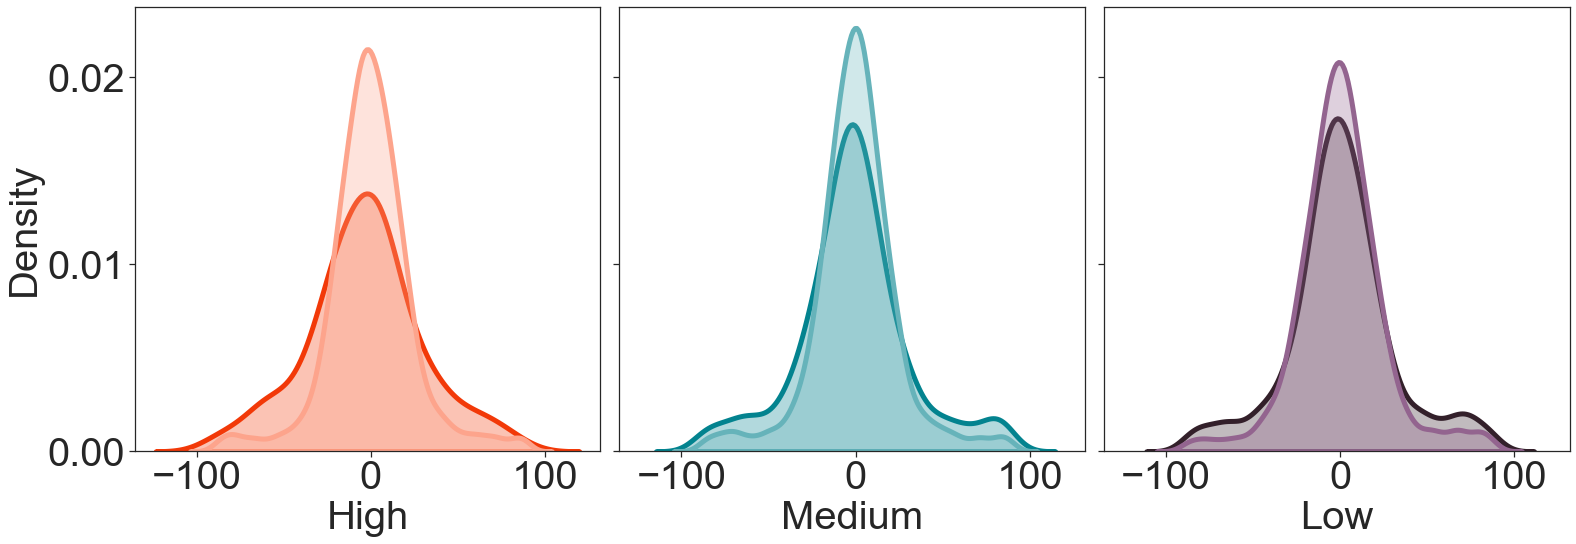

In [124]:
fig,ax = plt.subplots(ncols = 3,sharex=True, sharey=True)
sns.kdeplot(x = 'rel_distance_to_probed_item',hue = 'cue_condition',
            fill=True, common_norm=False, palette=['#fda48c','#f23908',],
            alpha=.3, linewidth=5,
            data = psyFull[psyFull['blk_validity'] == 'high'],ax = ax[0],)

ax[0].get_legend().set_visible(False)

sns.kdeplot(x = 'rel_distance_to_probed_item',hue = 'cue_condition',
            fill=True, common_norm=False, palette=['#66b3ba','#03838f',],
            alpha=.3, linewidth=5,
            data = psyFull[psyFull['blk_validity'] == 'medium'],ax = ax[1])
ax[1].get_legend().set_visible(False)

sns.kdeplot(x = 'rel_distance_to_probed_item',hue = 'cue_condition',
            fill=True, common_norm=False, palette=['#93648f', '#33202a'],
            alpha=.3, linewidth=5,
            data = psyFull[psyFull['blk_validity'] == 'low'],ax = ax[2])
ax[2].get_legend().set_visible(False)
           
fig.tight_layout()
[ax[i].tick_params( labelsize=40) for i in range(3) ]
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(0.01))

ax[0].set_ylabel('Density',fontsize = 40)
ax[0].set_xlabel('High',fontsize = 40)
ax[1].set_xlabel('Medium',fontsize = 40)
ax[2].set_xlabel('Low',fontsize = 40)



## subj avg error plots

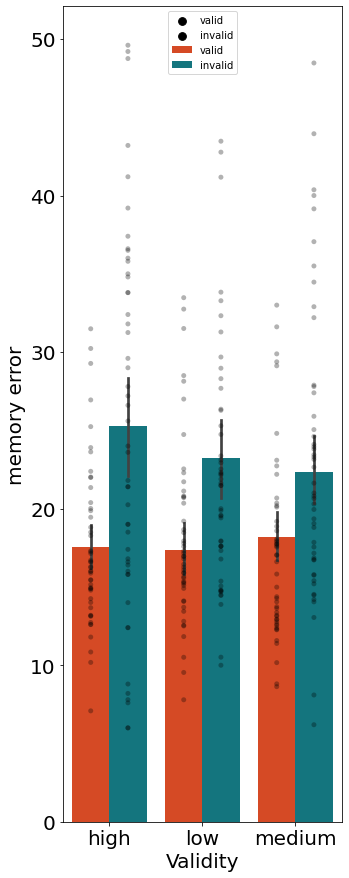

In [34]:
fs(5,15)
sns.barplot(x = 'blk_validity',hue ='cue_condition' ,y = 'abs_distance_to_probed_item',hue_order=['valid','invalid'], 
            order = ["high","medium","low"],
            palette=cDict.values(),data = memoryErrorSubj)
sns.stripplot(x = 'blk_validity',y ='abs_distance_to_probed_item',hue ='cue_condition',hue_order=['valid','invalid'],palette = ['black'],
                data = memoryErrorSubj,s = 5,zorder=10, marker = "o",dodge=True,jitter=False,alpha = 0.3)

plt.legend(prop={'size': 10}) 
plt.xlabel('Validity', fontsize=20)
plt.ylabel('memory error', fontsize=20)
plt.xticks(fontsize=20, )
plt.yticks(fontsize=20, )
fig.tight_layout()
plt.show()

In [109]:
ax.get_xticks()

array([0, 1])

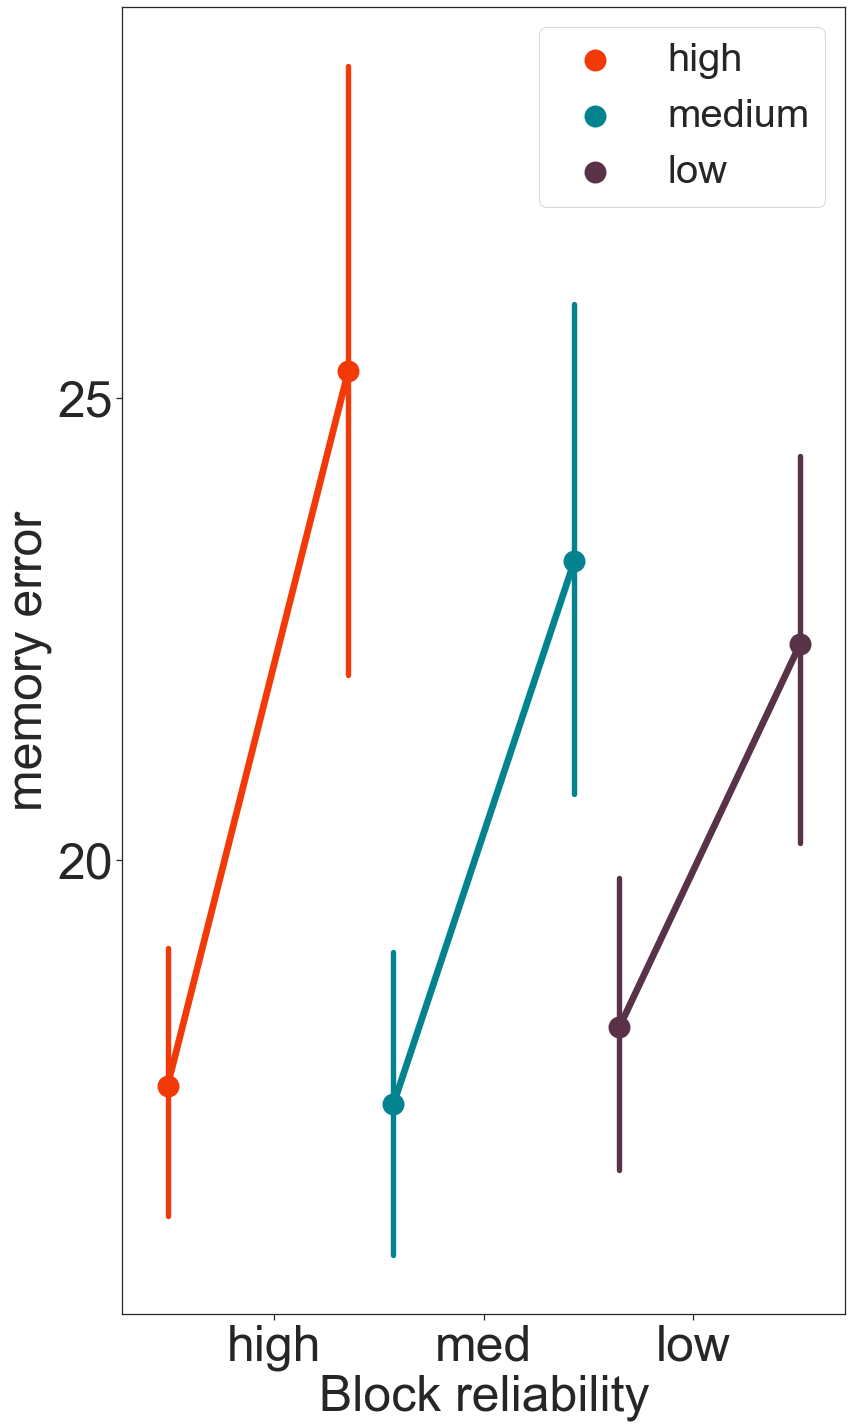

In [115]:
fig,ax = plt.subplots(figsize=(12,20))
sns.set(style="ticks", rc={"lines.linewidth": 3})

sns.pointplot(hue = 'blk_validity',x ='cue_condition' ,y = 'abs_distance_to_probed_item',dodge=2.5,
              order=['valid','invalid'], hue_order = ["high",'medium',"low"],scale = 1.25,
           palette=cDict.values(),data = memoryErrorSubj)#




ax.set(xlim=(-1.5,2.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

plt.legend(prop={'size': 40}) 
plt.xlabel('Block reliability', fontsize=50)
plt.xticks(ticks = [-0.66,0.5,1.66], labels = ['high','med','low'])
plt.ylabel('memory error', fontsize=50)

plt.xticks(fontsize=50, )
plt.yticks(fontsize=50, )
fig.tight_layout()
plt.show()

Text(0, 0.5, 'Response Error Difference')

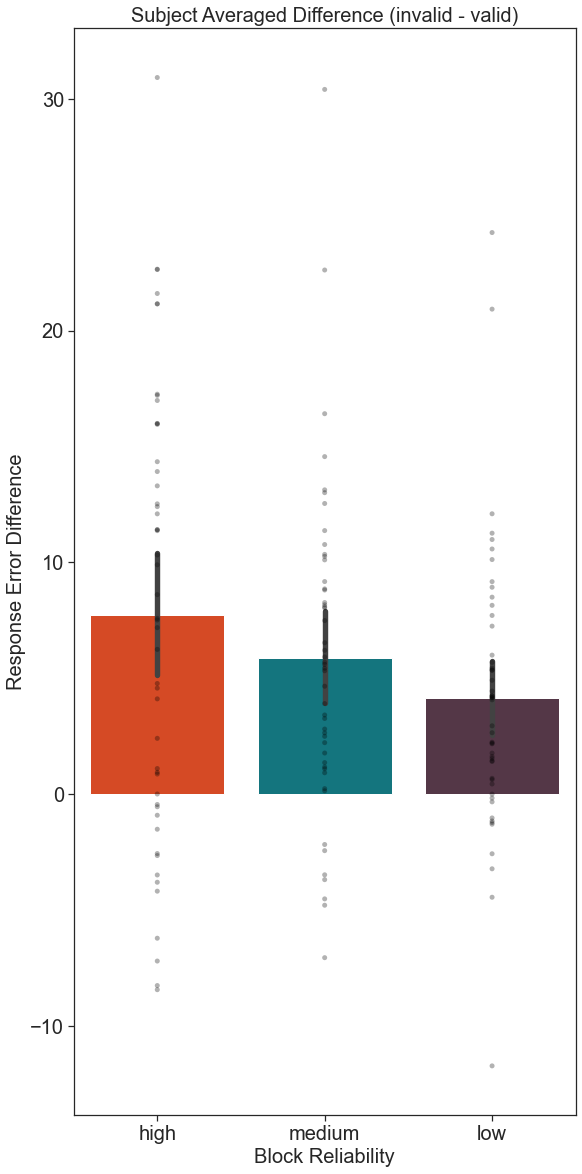

In [125]:
fs(9,20)
cDict = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#593247'} #{"['high']":'red',"['medium']":'green',"['low']":'blue'}

fig,ax = plt.subplots(nrows = 1,)
sns.barplot(x = 'blk_validity',y ='memory',
            order = ["high","medium","low"],ax = ax,
            palette=cDict.values(),data = temp,)

sns.stripplot(x = 'blk_validity',y ='memory',order = ["high","medium","low"],
                data = temp,s = 5,palette=['black'],zorder=10, marker = "o",jitter=False,alpha = .3)

plt.xticks(fontsize=20, )
plt.yticks(fontsize=20, )
plt.title('Subject Averaged Difference (invalid - valid)',size = 20)
plt.xlabel('Block Reliability',size = 20)
plt.ylabel('Response Error Difference',size = 20)


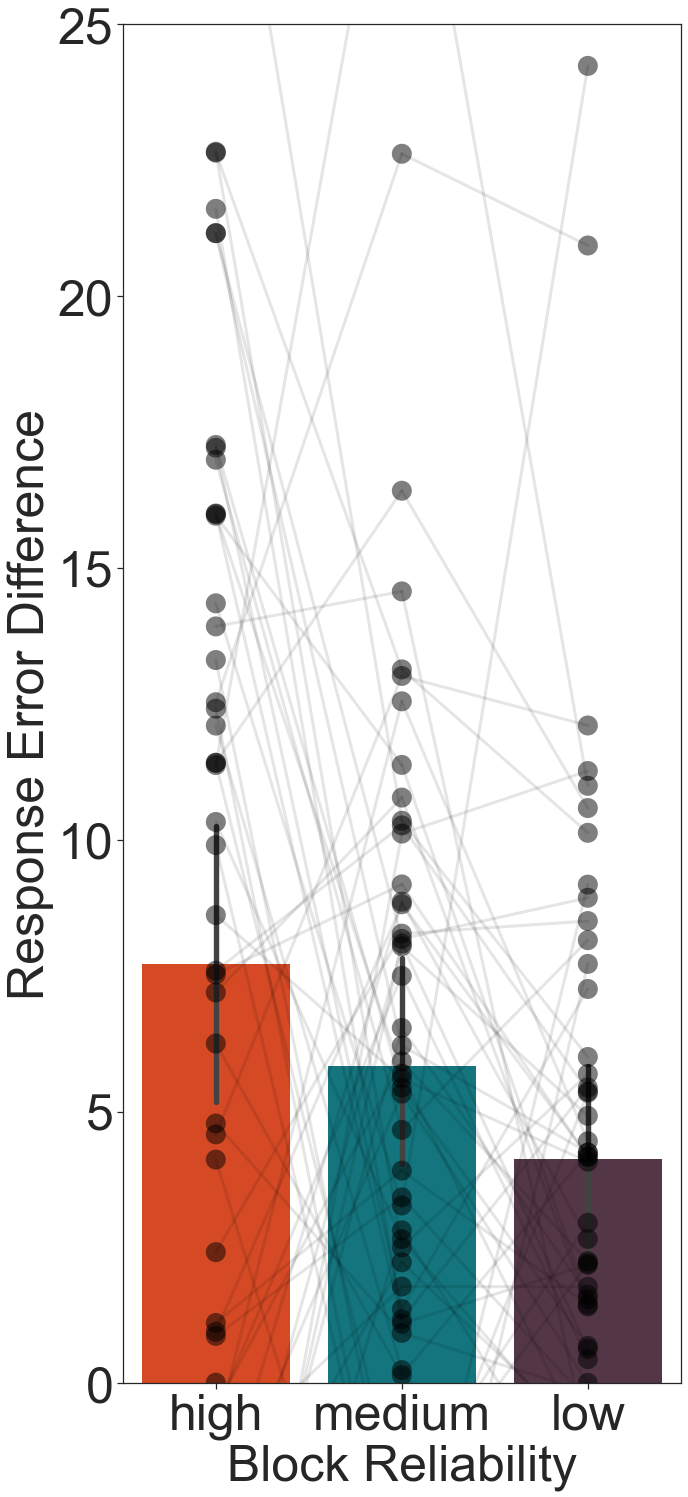

In [131]:
fs(9,15)
cDict = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#593247'} #{"['high']":'red',"['medium']":'green',"['low']":'blue'}

fig,ax = plt.subplots(nrows = 1,figsize=(10,25))


sns.stripplot(x = 'blk_validity',y ='memory',order = ["high",'medium',"low"],
                data = temp,s = 20,palette=['black'],zorder=10, marker = "o",jitter=False,alpha = .5)

locs1 = ax.get_children()[0].get_offsets().data
locs2 = ax.get_children()[1].get_offsets().data
locs3 = ax.get_children()[2].get_offsets().data

for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.1)

    x = [locs2[i, 0], locs3[i, 0]]
    y = [locs2[i, 1], locs3[i, 1]]
    
    ax.plot(x, y, color="black", alpha=0.1)



sns.barplot(x = 'blk_validity',y ='memory',
            order = ["high",'medium',"low"],ax = ax,
            palette=cDict.values(),data = temp,zorder = 0)
plt.xticks(fontsize=50, )
plt.yticks(fontsize=50, )
#plt.title('Subject Averaged Difference \n (invalid - valid)',size =35)
plt.xlabel('Block Reliability',size = 50)
plt.ylabel('Response Error Difference',size = 50)
plt.ylim(0,25)
plt.show()

In [ ]:
fs(10,20)
#combined plot of the previous two, it's the same thing but looks better
cDict = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#593247'} #{"['high']":'red',"['medium']":'green',"['low']":'blue'}

fig,ax = plt.subplots(nrows = 2,gridspec_kw={'height_ratios': [1.2,2.4],})
sns.barplot(x = 'blk_validity',y ='memory',
            order = ["high","medium","low"],ax = ax[0],
            palette=cDict.values(),data = temp)
sns.stripplot(x = 'blk_validity',y ='abs_distance_to_probed_item',hue ='cue_condition',hue_order=['valid','invalid'],palette = ['black'],
                data = memoryErrorSubj,s = 7,zorder=10, marker = "o",dodge=True,jitter=False,alpha = 0.3,ax = ax[1],)

plt.xticks(fontsize=20, )
plt.yticks(fontsize=20, )
sns.barplot(x = 'blk_validity',hue ='cue_condition' ,y = 'abs_distance_to_probed_item',hue_order=['valid','invalid'], 
            order = ["high","medium","low"],ax = ax[1],
            palette=cDict.values(),data = memoryErrorSubj)
sns.stripplot(x = 'blk_validity',y ='memory',order = ["high","medium","low"],ax = ax[0],
                data = temp,s = 7,palette=['black'],zorder=10, marker = "o",jitter=False,alpha = .3)

plt.legend(prop={'size': 30}) 
plt.xlabel('Validity', fontsize=20)
plt.ylabel('memory error', fontsize=20)
plt.xticks(fontsize=20, )
plt.yticks(fontsize=20, )
fig.tight_layout()
ax[1].get_legend().set_visible(False)

plt.show()

## subj avg rt

In [ ]:
fs(5,15)
sns.barplot(x = 'blk_validity',hue ='cue_condition' ,y = 'rt',hue_order=['valid','invalid'], 
            order = ["high","medium","low"],
            palette=cDict.values(),data = rtSubj)
sns.stripplot(x = 'blk_validity',y ='rt',hue ='cue_condition',hue_order=['valid','invalid'],palette = ['black'],
                data = rtSubj,s = 5,zorder=10, marker = "o",dodge=True,jitter=False,alpha = 0.3)

plt.legend(prop={'size': 10}) 
plt.xlabel('Validity', fontsize=20)
plt.ylabel('rt', fontsize=20)
plt.xticks(fontsize=20, )
plt.yticks(fontsize=20, )
fig.tight_layout()
plt.show()

In [ ]:
fs(3,15)
cDict = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#593247'} #{"['high']":'red',"['medium']":'green',"['low']":'blue'}

fig,ax = plt.subplots(nrows = 1,)
sns.barplot(x = 'blk_validity',y ='rt',
            order = ["high","medium","low"],ax = ax,
            palette=cDict.values(),data = tempRT,)

sns.stripplot(x = 'blk_validity',y ='rt',order = ["high","medium","low"],
                data = tempRT,s = 5,palette=['black'],zorder=10, marker = "o",jitter=False,alpha = .3)

plt.xticks(fontsize=20, )
plt.yticks(fontsize=20, )
plt.title('Subject Averaged Difference (invalid - valid)',size = 20)
plt.xlabel('Block Reliability',size = 20)
plt.ylabel('RT Difference',size = 20)


In [ ]:
fs(10,20)
#combined plot of the previous two, it's the same thing but looks better
cDict = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#593247'} #{"['high']":'red',"['medium']":'green',"['low']":'blue'}

fig,ax = plt.subplots(nrows = 2,gridspec_kw={'height_ratios': [1.2,2.4],})
sns.barplot(x = 'blk_validity',y ='rt',
            order = ["high","medium","low"],ax = ax[0],
            palette=cDict.values(),data = tempRT)
sns.stripplot(x = 'blk_validity',y ='rt',hue ='cue_condition',hue_order=['valid','invalid'],palette = ['black'],
                data = rtSubj,s = 7,zorder=10, marker = "o",dodge=True,jitter=False,alpha = 0.3,ax = ax[1],)

plt.xticks(fontsize=20, )
plt.yticks(fontsize=20, )
sns.barplot(x = 'blk_validity',hue ='cue_condition' ,y = 'rt',hue_order=['valid','invalid'], 
            order = ["high","medium","low"],ax = ax[1],
            palette=cDict.values(),data = rtSubj)
sns.stripplot(x = 'blk_validity',y ='rt',order = ["high","medium","low"],ax = ax[0],
                data = tempRT,s = 7,palette=['black'],zorder=10, marker = "o",jitter=False,alpha = .3)


plt.legend(prop={'size': 30}) 
plt.xlabel('Validity', fontsize=20)
plt.ylabel('rt', fontsize=20)
plt.xticks(fontsize=20, )
plt.yticks(fontsize=20, )
fig.tight_layout()
ax[1].get_legend().set_visible(False)

plt.show()


# pupil plots

# pup sacc

In [20]:
towardFreq = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeshift2d/freqRelX_towardRetro.csv').iloc[:,1:]
awayFreq = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeshift2d/freqRelX_awayRetro.csv').iloc[:,1:]


In [28]:
commonTrls = list(set(towardFreq.identifier) & set(retroEpo.identifier))

In [38]:
retroEpoShared = retroEpo[retroEpo.identifier.isin(commonTrls)].reset_index(drop = True)
towardFreqShared = towardFreq[towardFreq.identifier.isin(commonTrls)].reset_index(drop = True)
awayFreqShared = awayFreq[awayFreq.identifier.isin(commonTrls)].reset_index(drop = True)

sum(retroEpoShared.identifier != towardFreqShared.identifier),sum(retroEpoShared.identifier != awayFreqShared.identifier)

0

In [208]:
freqStart = 200
freqEnd = 1000

pupStart = 500
pupEnd = 1500

freqMeanLabel = 'towardFreqMean_' + str(freqStart) +'to'+str(freqEnd)
freqMeanLabel_away = 'awayFreqMean_' + str(freqStart)+'to'+str(freqEnd)
pupMeanLabel = 'pupMean_' + str(pupStart)+'to'+str(pupEnd)

In [209]:
meanPupSacc = pd.concat([towardFreqShared.iloc[:,freqStart:freqEnd,].mean(axis = 1),retroEpoShared.iloc[:,pupStart:pupEnd,].mean(axis = 1)],axis = 1)
meanPupSacc = pd.concat([meanPupSacc,retroEpoShared[['identifier','cue_blk_validity','cued_item','subj']]],axis =1)

meanPupSacc[freqMeanLabel_away] = awayFreqShared.iloc[:,freqStart:freqEnd,].mean(axis = 1)
meanPupSacc.rename(columns={0:freqMeanLabel,1:pupMeanLabel},inplace=True)
meanPupSacc['freqDiff'] = meanPupSacc[freqMeanLabel] - meanPupSacc[freqMeanLabel_away]

In [210]:
corrVal_pupDiff = meanPupSacc.groupby(['subj','cued_item'])[pupMeanLabel,'freqDiff'].corr().iloc[::2,].reset_index()

corrVal_pupToward = meanPupSacc.groupby(['subj','cued_item'])[pupMeanLabel,freqMeanLabel].corr().iloc[::2,].reset_index()
corrVal_pupAway = meanPupSacc.groupby(['subj','cued_item'])[pupMeanLabel,freqMeanLabel_away].corr().iloc[::2,].reset_index()

<AxesSubplot:xlabel='cued_item', ylabel='towardFreqMean_200to1000'>

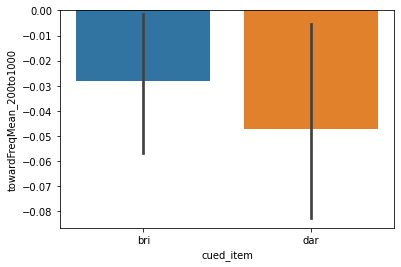

In [211]:
sns.barplot(data = corrVal_pupToward,x = 'cued_item',y = freqMeanLabel)

<AxesSubplot:xlabel='cued_item', ylabel='awayFreqMean_200to1000'>

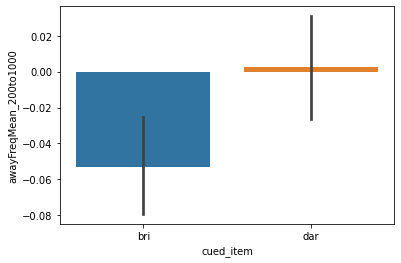

In [212]:
sns.barplot(data = corrVal_pupAway,x = 'cued_item',y = freqMeanLabel_away)

<AxesSubplot:xlabel='cued_item', ylabel='freqDiff'>

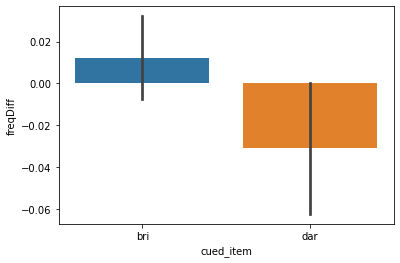

In [213]:
sns.barplot(data = corrVal_pupDiff,x = 'cued_item',y = 'freqDiff')

# <font color= 'red'> below is all wip

In [ ]:
saccTemp = pd.read_csv('Z:/LiteBrite_Yueying/temp/saccPixelXY/saccPixelXY_Masked.csv').reset_index()

In [ ]:
saccTemp

In [ ]:
x = np.linspace(0,5,included)

saccClean = saccTemp.iloc[:,1:included+1].apply(lambda y: linearInterpolate(x,y,method='nearest'),axis = 1,raw = True)


In [ ]:
saccPosPerc_x = (saccClean.loc['x'] -960)*100/960
saccPosPerc_y = (saccClean.loc['y'] -540)*100/540


In [ ]:
saccPosPerc_x = pd.concat([saccPosPerc_x,saccPosPerc_y])


In [ ]:
#interpolation of gaze data
x = np.linspace(0,5,included)
saccClean_x = saccTemp.iloc[:,1:included+1].apply(lambda y: linearInterpolate(x,y,method='nearest'),axis = 1,raw = True)
saccClean_x.insert(0,'TRIALID',saccTemp.TRIALID)

saccClean_y = saccTemp_y.iloc[:,1:included+1].apply(lambda y: linearInterpolate(x,y,method='nearest'),axis = 1,raw = True)
saccClean_y.insert(0,'TRIALID',saccTemp.TRIALID)

### re-unit & reject

In [ ]:
#transform into percentage 
saccPosPerc_x = (saccClean_x.iloc[:,1:]-960)*100/960
saccPosPerc_x = pd.concat([saccClean_x.iloc[:,0],saccPosPerc_x],axis = 1)

saccPosPerc_y = (saccClean_y.iloc[:,1:]-540)*100/540
saccPosPerc_y = pd.concat([saccClean_y.iloc[:,0],saccPosPerc_y],axis = 1)

In [ ]:
yval = saccPosPerc_y.iloc[:,saccBLWindow[0]:saccBLWindow[1]].mean(axis = 1)
xval = saccPosPerc_x.iloc[:,saccBLWindow[0]:saccBLWindow[1]].mean(axis = 1)

#1.5 visual degree is roughly 52 pixel for both x and y
#the euclean distance threshold is this
deg1VADeviation = np.sqrt((52*100/960)**2+(52*100/540)**2)

#reject trials with drifted fixation: 
normSaccY = saccPosPerc_y[(np.sqrt(xval**2 + yval**2) <= deg1VADeviation)].reset_index(drop = True)
normSaccX = saccPosPerc_x[(np.sqrt(xval**2 + yval**2) <= deg1VADeviation)].reset_index(drop = True)

normSaccX['axis'] = 'x'
normSaccY['axis'] = 'y'

normSacc = pd.concat([normSaccX,normSaccY]).sort_index(axis = 0,).reset_index(drop = True)
normSacc.set_index('axis',inplace= True)

In [ ]:
#smooth 

In [ ]:
x = np.linspace(0,5,included)


In [ ]:
saccTemp['axis'] = 'x'
saccTemp_y['axis'] = 'y'


In [ ]:
xEg = saccTemp.iloc[np.random.randint(10000),1:]

In [ ]:
interpMethod = [ 'linear', 'nearest', 'zero',  'quadratic', 'cubic', 'previous',  'next']

In [ ]:
plt.scatter(range(5000),xEg)
[plt.plot(range(5000),linearInterpolate(x,xEg.values.astype(float),method = i),
          label = i
          ) for i in interpMethod]
plt.legend()

# save

In [ ]:
mackClean.to_csv()
pupClean
saccClean_x
saccClean_y


In [ ]:
dx = find_abs_speed_sacc(gazex)
dy = find_abs_speed_sacc(gazey)

In [ ]:
q = np.arctan2(gazey.astype(float),gazex.astype(float))*180/np.pi

In [ ]:
q = (q + 360) % 360  

In [ ]:
fs(10,5)
plt.plot(q.values)
plt.vlines(np.array(eventIndex[1:-3])-500,0,360,linestyles = 'dashed',colors = 'black')

In [ ]:
eg = retroEpo[np.sum(retroEpo.iloc[:,:dataN].isnull(),axis = 1) ==0].reset_index(drop = True)
eg = eg.set_index(['cue_blk_validity']).iloc[:,np.r_[np.arange(0,dataN),-2,-3,-1]]
egH = eg.loc["['high']"]
egM = eg.loc["['medium']"]
egL = eg.loc["['low']"]
egHmean = egH.groupby(['cued_item','subj',]).mean()
egMmean = egM.groupby(['cued_item','subj',]).mean()
egLmean = egL.groupby(['cued_item','subj',]).mean()
trueHT,trueHP = stats.ttest_rel(egHmean.loc['bri'].iloc[:,:dataN],
                                egHmean.loc['dar'].iloc[:,:dataN],
                axis=0, nan_policy='propagate',alternative = 'less')
trueMT,trueMP = stats.ttest_rel(egMmean.loc['bri'].iloc[:,:dataN],
                                egMmean.loc['dar'].iloc[:,:dataN],
                axis=0, nan_policy='propagate',alternative = 'two-sided')
trueLT,trueLP = stats.ttest_rel(egLmean.loc['bri'].iloc[:,:dataN],
                                egLmean.loc['dar'].iloc[:,:dataN],
                axis=0, nan_policy='propagate',alternative = 'two-sided')